In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set directory to location of OULAD dataset in google drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [4]:
ls

anonymisedOUDataSet/  Deadline/  StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [5]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# Module FFF

## Setup

### Load dataset and remove column features that are not used in module

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_FFF_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # fail course = 0 | pass course = 1
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [7]:
df[0].head()

code_presentation  id_student gender  ...   subpage  url mean_click
0             2013B       33915      F  ...  1.857143  1.0   0.902172
1             2013B       35544      M  ...  1.000000  0.0   0.425926
2             2013B       35860      M  ...  1.545455  1.0   0.802525
3             2013B       42668      M  ...  1.000000  0.0   0.724265
4             2013B       43273      M  ...  0.000000  0.0   0.055556

[5 rows x 27 columns]

In [ ]:
df[0].final_result.value_counts()

1    3217
0    1353
Name: final_result, dtype: int64

In [ ]:
df[0].code_presentation.value_counts()

2013J    1391
2014J    1318
2013B    1033
2014B     828
Name: code_presentation, dtype: int64

## Helper functions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [ ]:
def plot_confusion_matrix(result):
  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [ ]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare(deadline_list,result,labels,title):
  for i in range(len(result)):
    result[i] = np.array(result[i])
    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=result[i][:,1],marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("F1 Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare_npv(deadline_list,result,labels,title):
 
  for i in range(len(result)):   
    npv = []

    for j in result[i][:,4]:
      tn, fp, fn, tp = j.ravel()

      # Prevent zero division error
      if fn == 0:
        npv.append(0)
      else:
        npv.append(tn/(tn+fn))

    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Negative Predictive Value")
  plt_days.set_title(title)

In [ ]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [ ]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [ ]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [ ]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [ ]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [ ]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [ ]:
df[0].columns

Index(['code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'dualpane', 'forumng',
       'glossary', 'homepage', 'htmlactivity', 'oucollaborate', 'oucontent',
       'ouelluminate', 'ouwiki', 'page', 'questionnaire', 'quiz', 'resource',
       'subpage', 'url', 'mean_click'],
      dtype='object')

In [ ]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [ ]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Feature correlation
 

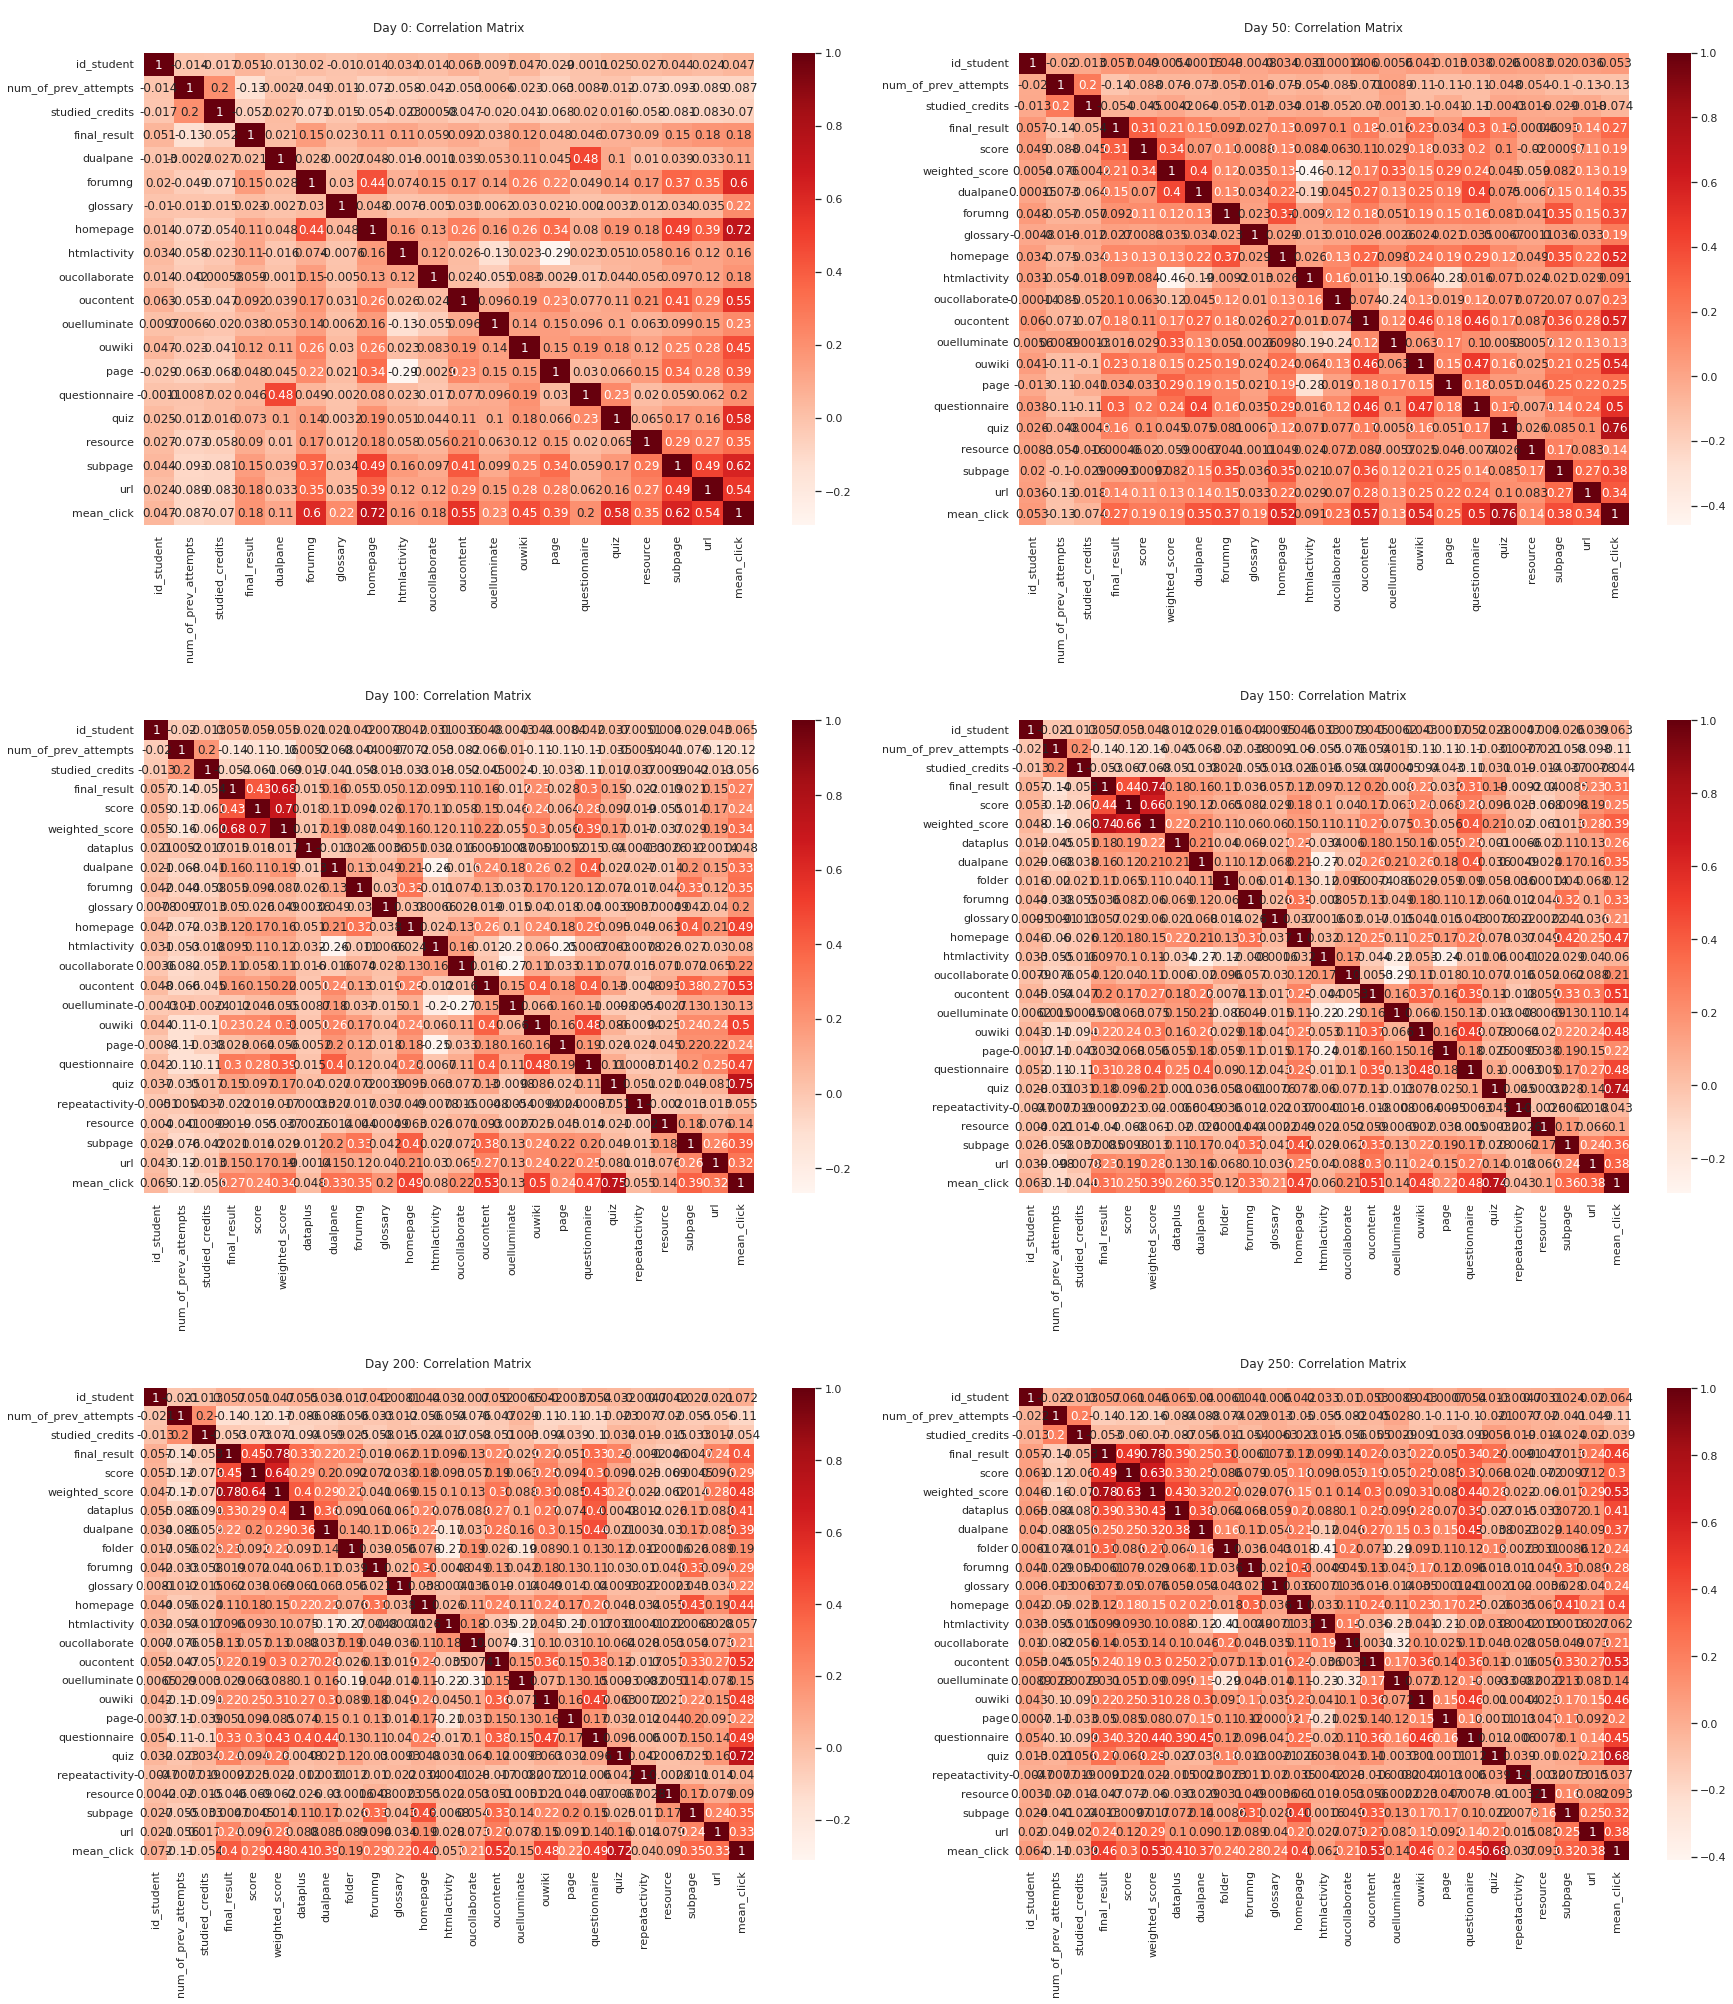

In [ ]:
plot_correlation_matrix(df)

## Make predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [ ]:
demographic_df = {}
for i in df.keys():
  demographic_df[i] = split_dataframe_by_data_type(df[i], ['demographic'], include_final_result=True)

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(demographic_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')


In [ ]:
X_train[0].shape

(1391, 35)

###### Undersampling

In [ ]:
Y_train[0].value_counts()

1    984
0    407
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 984, 0: 407})
Resample dataset shape Counter({0: 407, 1: 407})
Sampling for day 50
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 100
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 150
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 200
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 250
Original dataset shape: Counter({1: 1028, 0: 425})
Resample dataset shape Counter({0: 425, 1: 425})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0    1    2    3    4    5    6   ...   13   14   15   16   17   18   19
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  1.0  0.0
1     0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0  0.0  0.0
2     0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0  0.0  0.0
3     0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  1.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1448  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
1449  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
1450  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0
1451  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0
1452  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0

[1453 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

demographic_results_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_du.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.485
Best parameters set:
Accuracy: 0.5060698027314112, F1 Score: 0.6052152819890844, Precision: 0.7595129375951294, Recall: 0.5030241935483871


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best

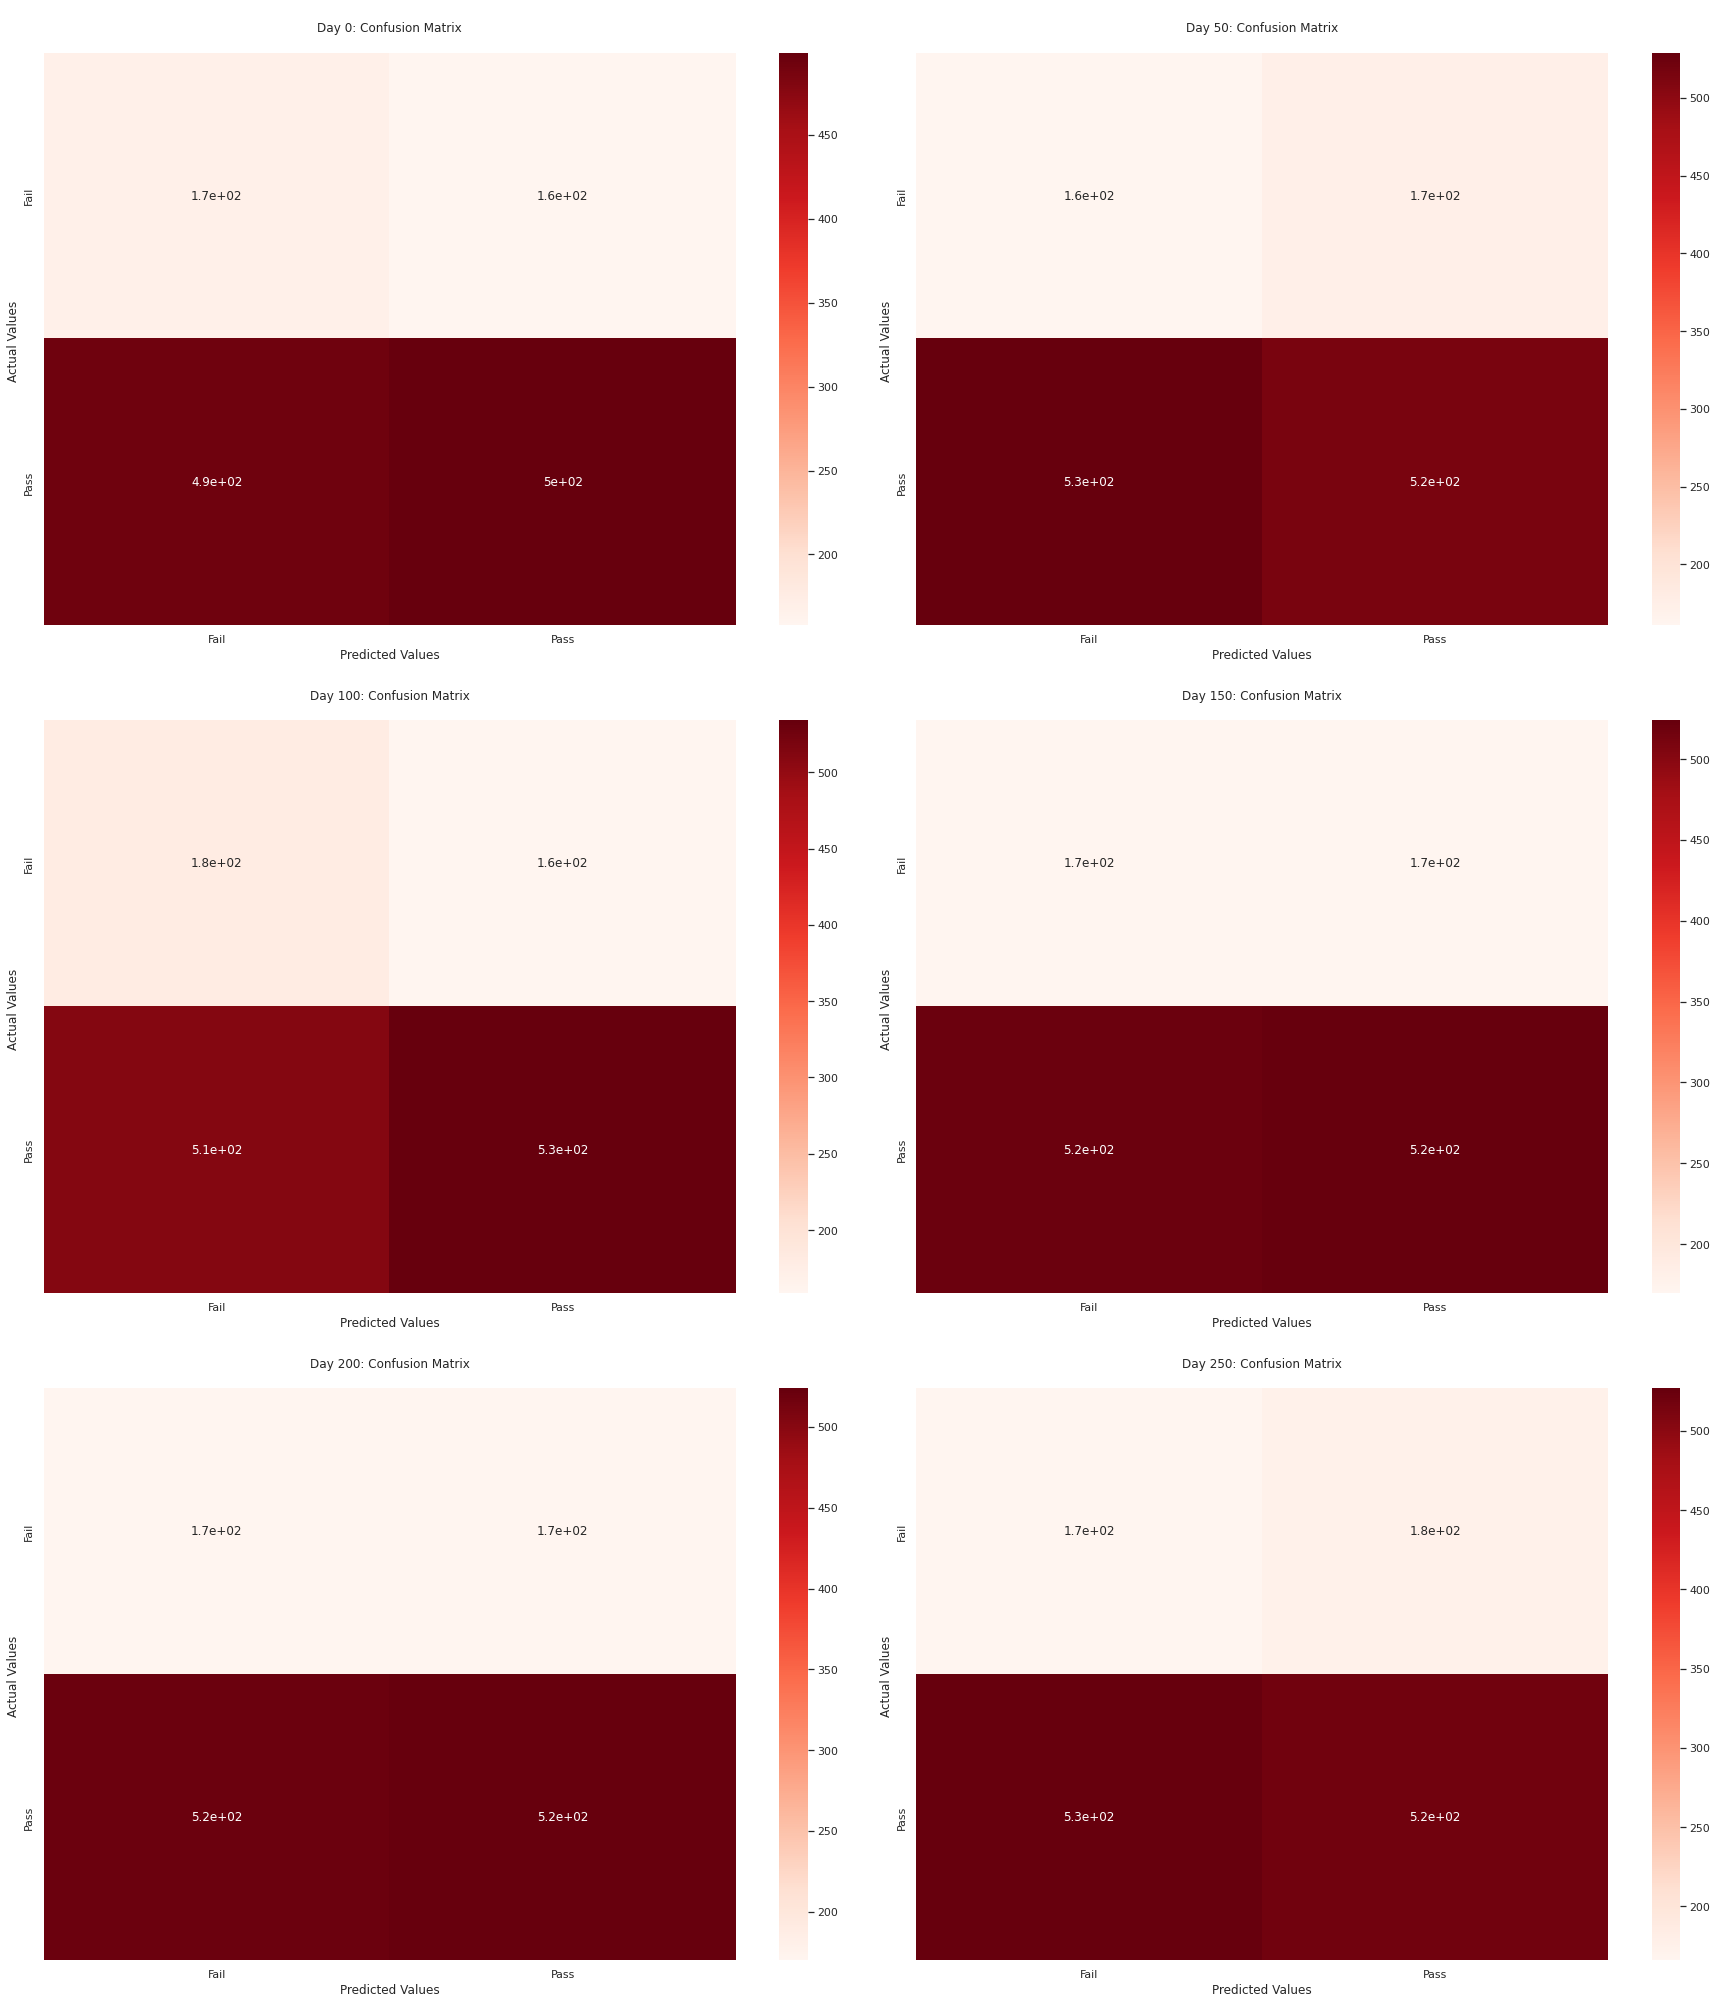

In [ ]:
plot_confusion_matrix(demographic_results_du)

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

demographic_results_nb = []

pipeline = Pipeline([
    ('clf', BernoulliNB(binarize=None)),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_nb.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.562
Best parameters set:
Accuracy: 0.7071320182094082, F1 Score: 0.8118908382066277, Precision: 0.7858490566037736, Recall: 0.8397177419354839


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.7150108774474256, F1 Score: 0.8203017832647463, Precision: 0.7847769028871391, Recall: 0.8591954022988506


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.713150289017341, F1 Score: 0.818969448244414, Precision: 0.7822299651567944, Recall: 0.8593301435406698


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.558
Best p

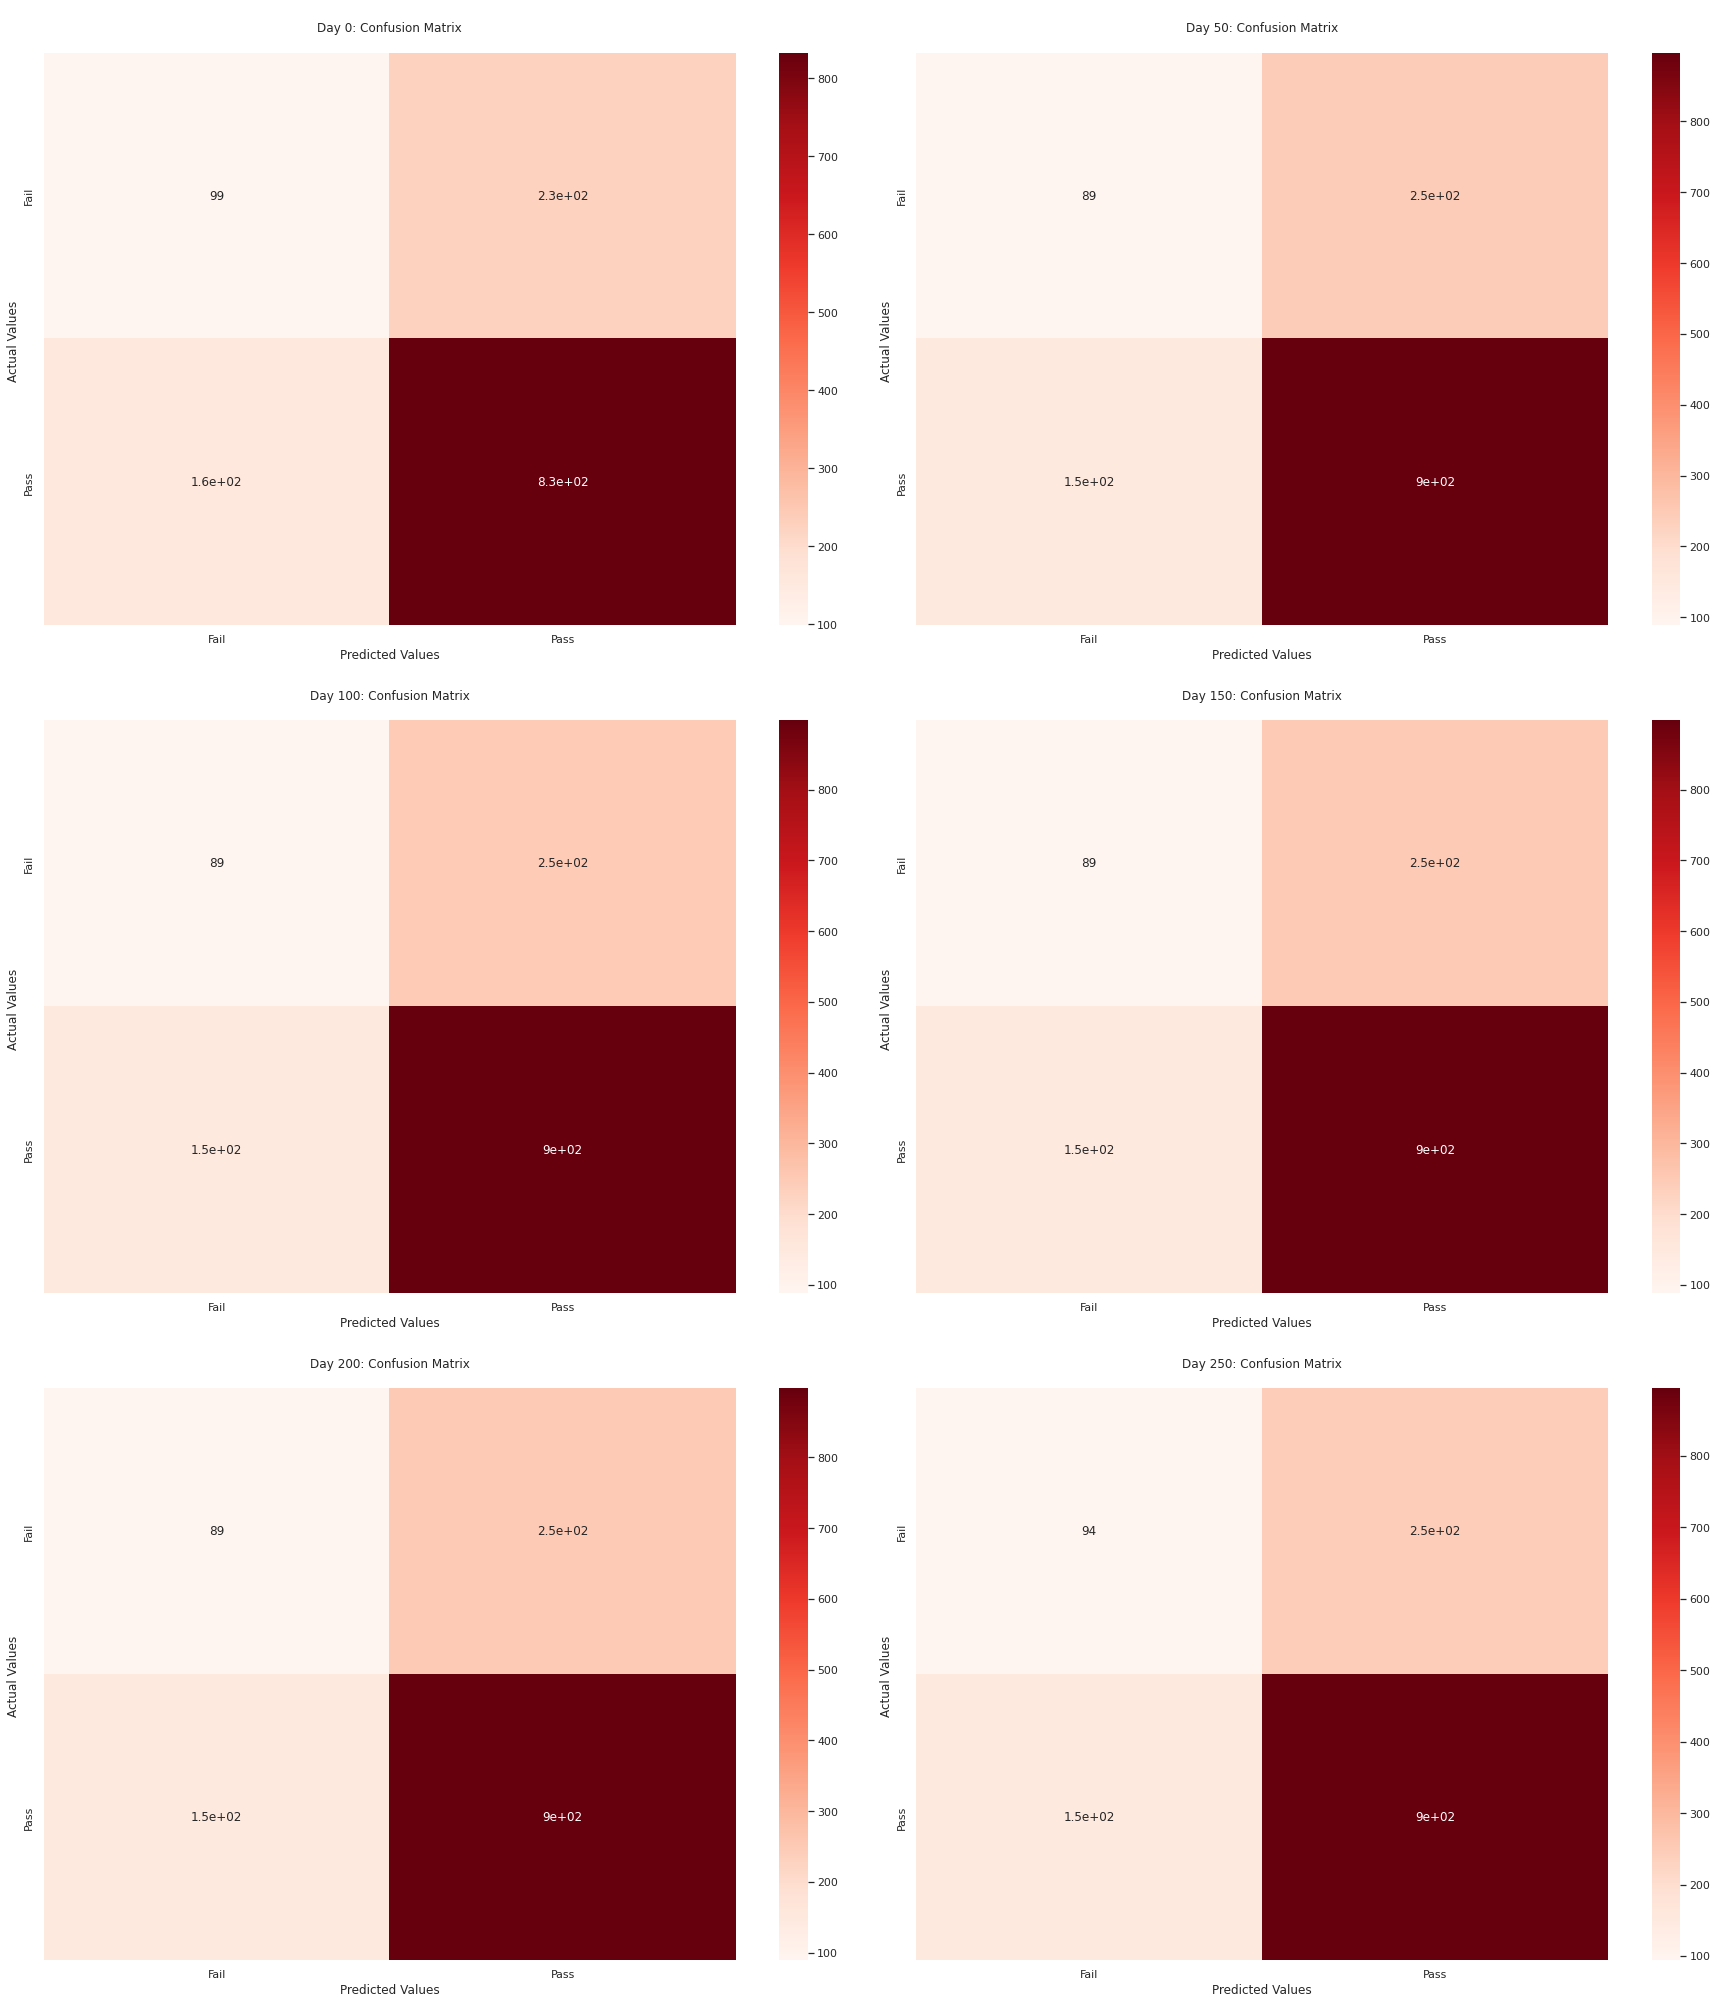

In [ ]:
plot_confusion_matrix(demographic_results_nb)

##### LogisticRegression

ovr is used for binary problems

In [ ]:
from sklearn.linear_model import LogisticRegression

demographic_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr')),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lr.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.516
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7503793626707133, F1 Score: 0.8524001794526692, Precision: 0.7679870654810024, Recall: 0.9576612903225806


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7469180565627266, F1 Score: 0.8505353319057816, Precision: 0.7691711851278079, Recall: 0.9511494252873564


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.744942196531792, F1 Score: 0.849209739427595, Precision: 0.7669753086419753, Recall: 0.9511961722488

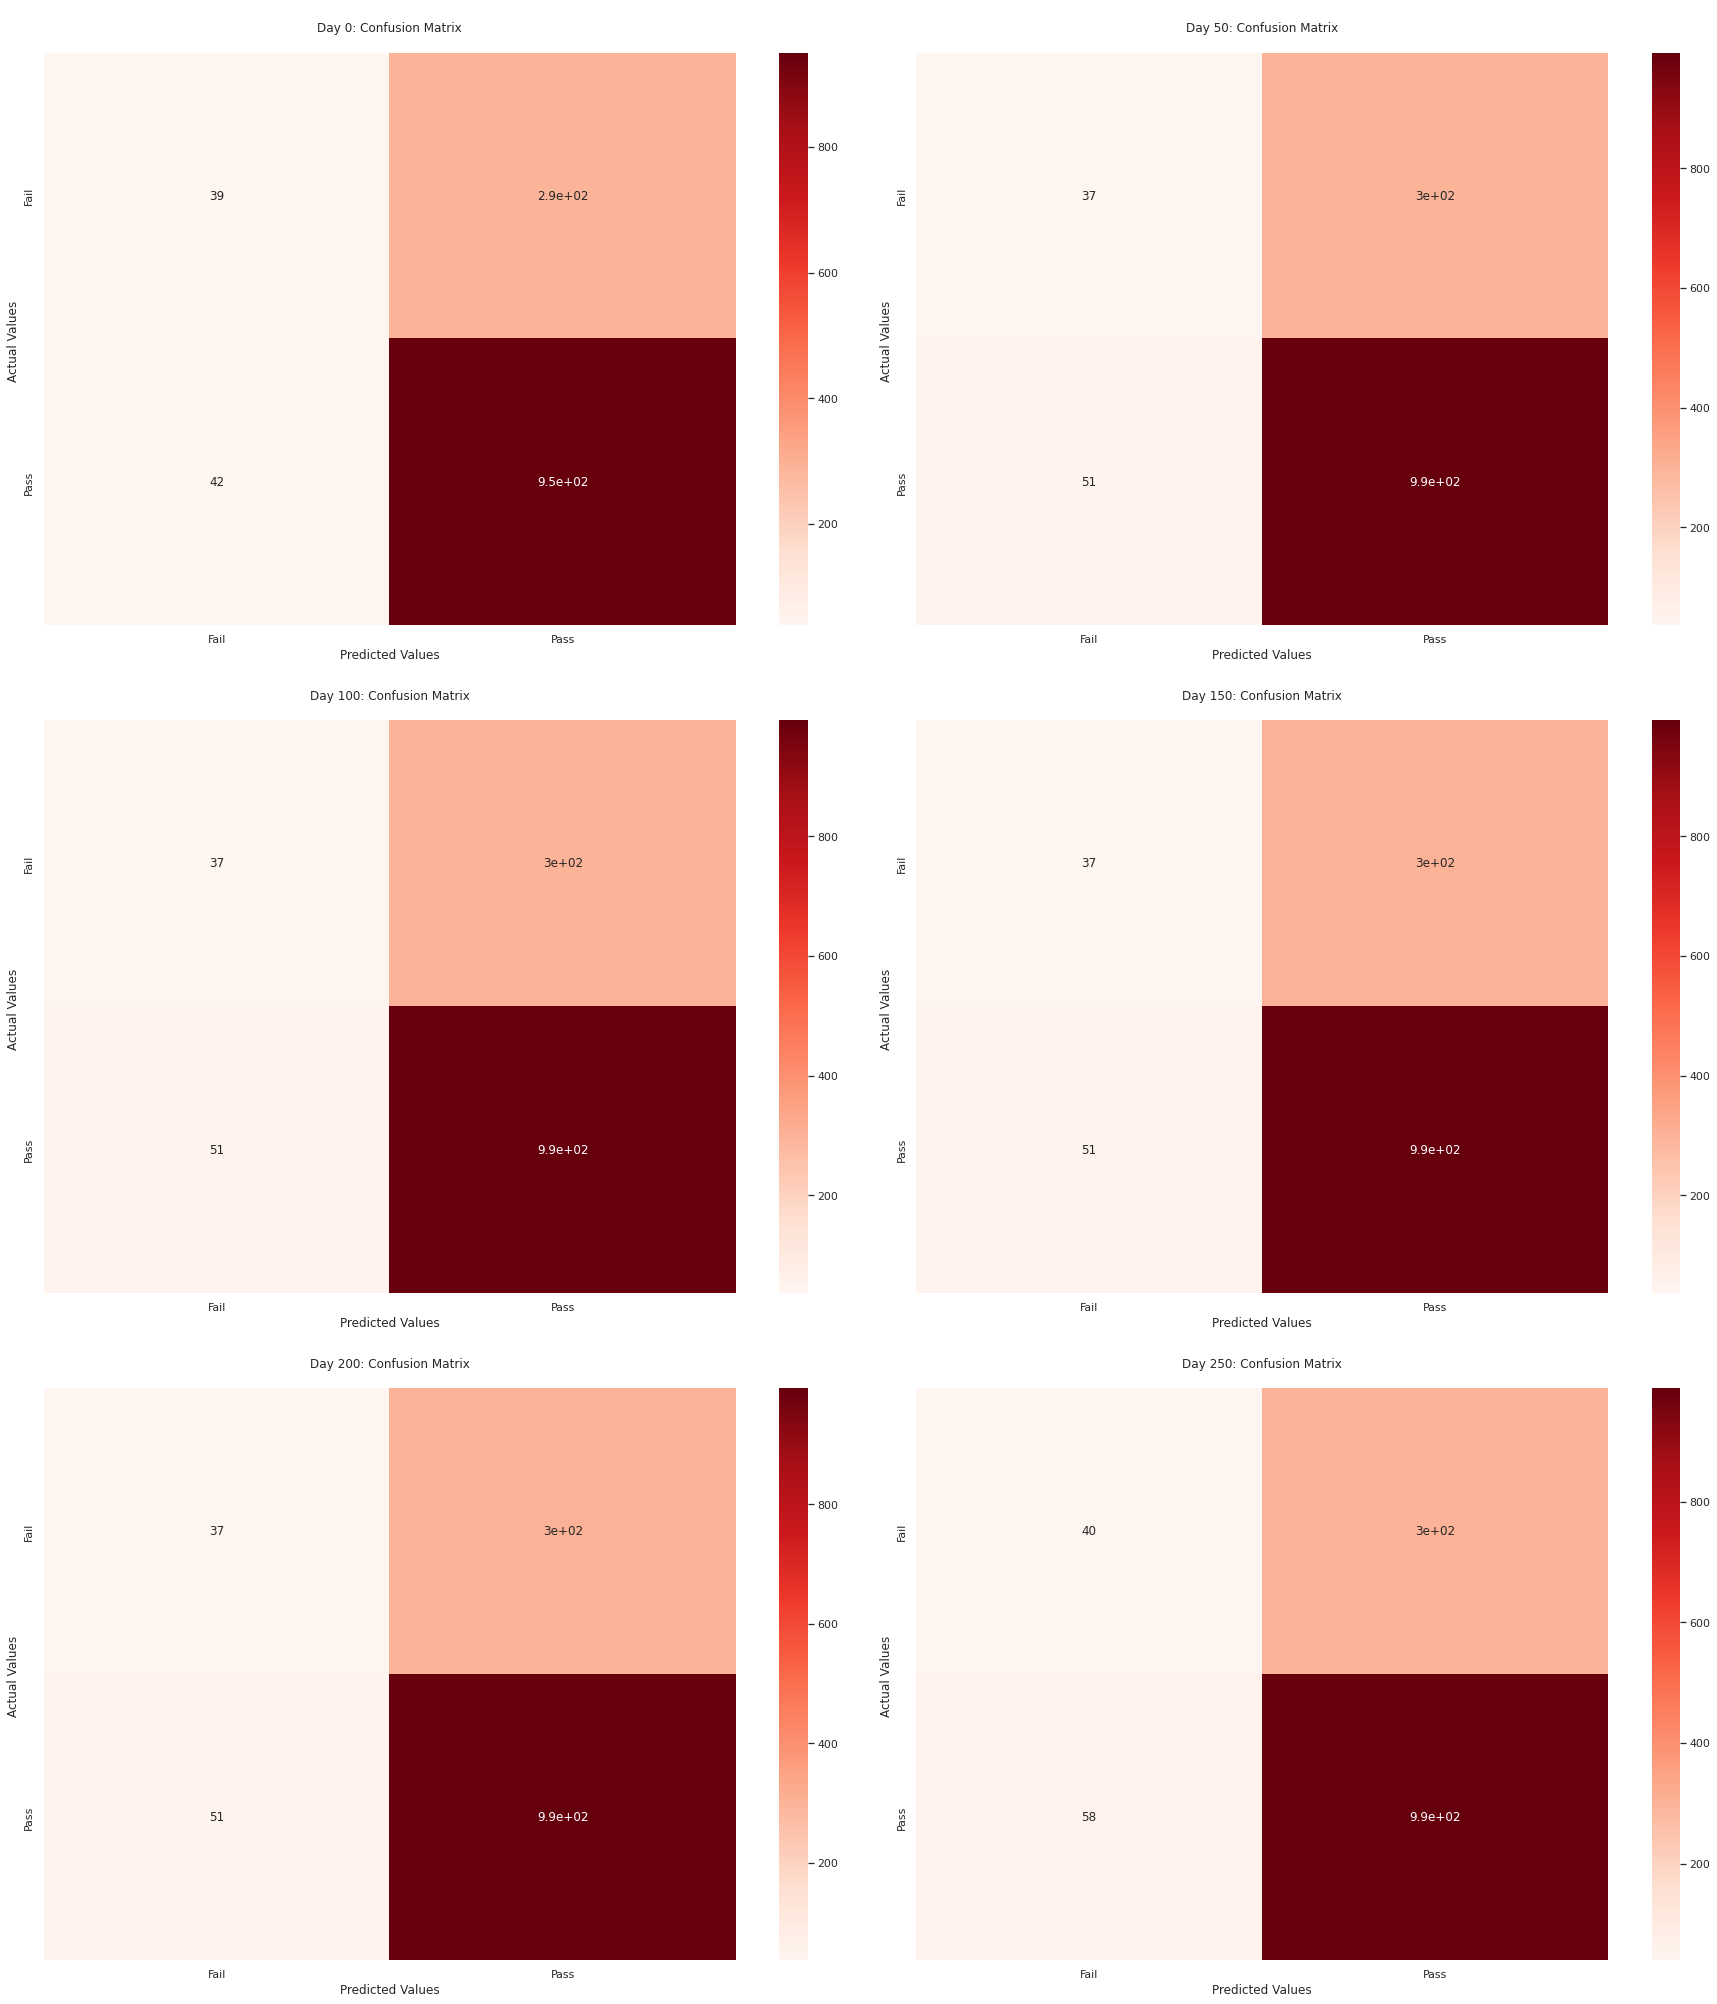

In [ ]:
plot_confusion_matrix(demographic_results_lr)

##### WeightedLogisticRegression

In [ ]:
demographic_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.569
Best parameters set:
Accuracy: 0.5842185128983308, F1 Score: 0.6857798165137614, Precision: 0.7952127659574468, Recall: 0.6028225806451613


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5808556925308195, F1 Score: 0.67853170189099, Precision: 0.8090185676392573, Recall: 0.5842911877394636


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5802023121387283, F1 Score: 0.677759290072102, Precision: 0.8060686015831134, Recall: 0.584688995215311


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.566
Best par

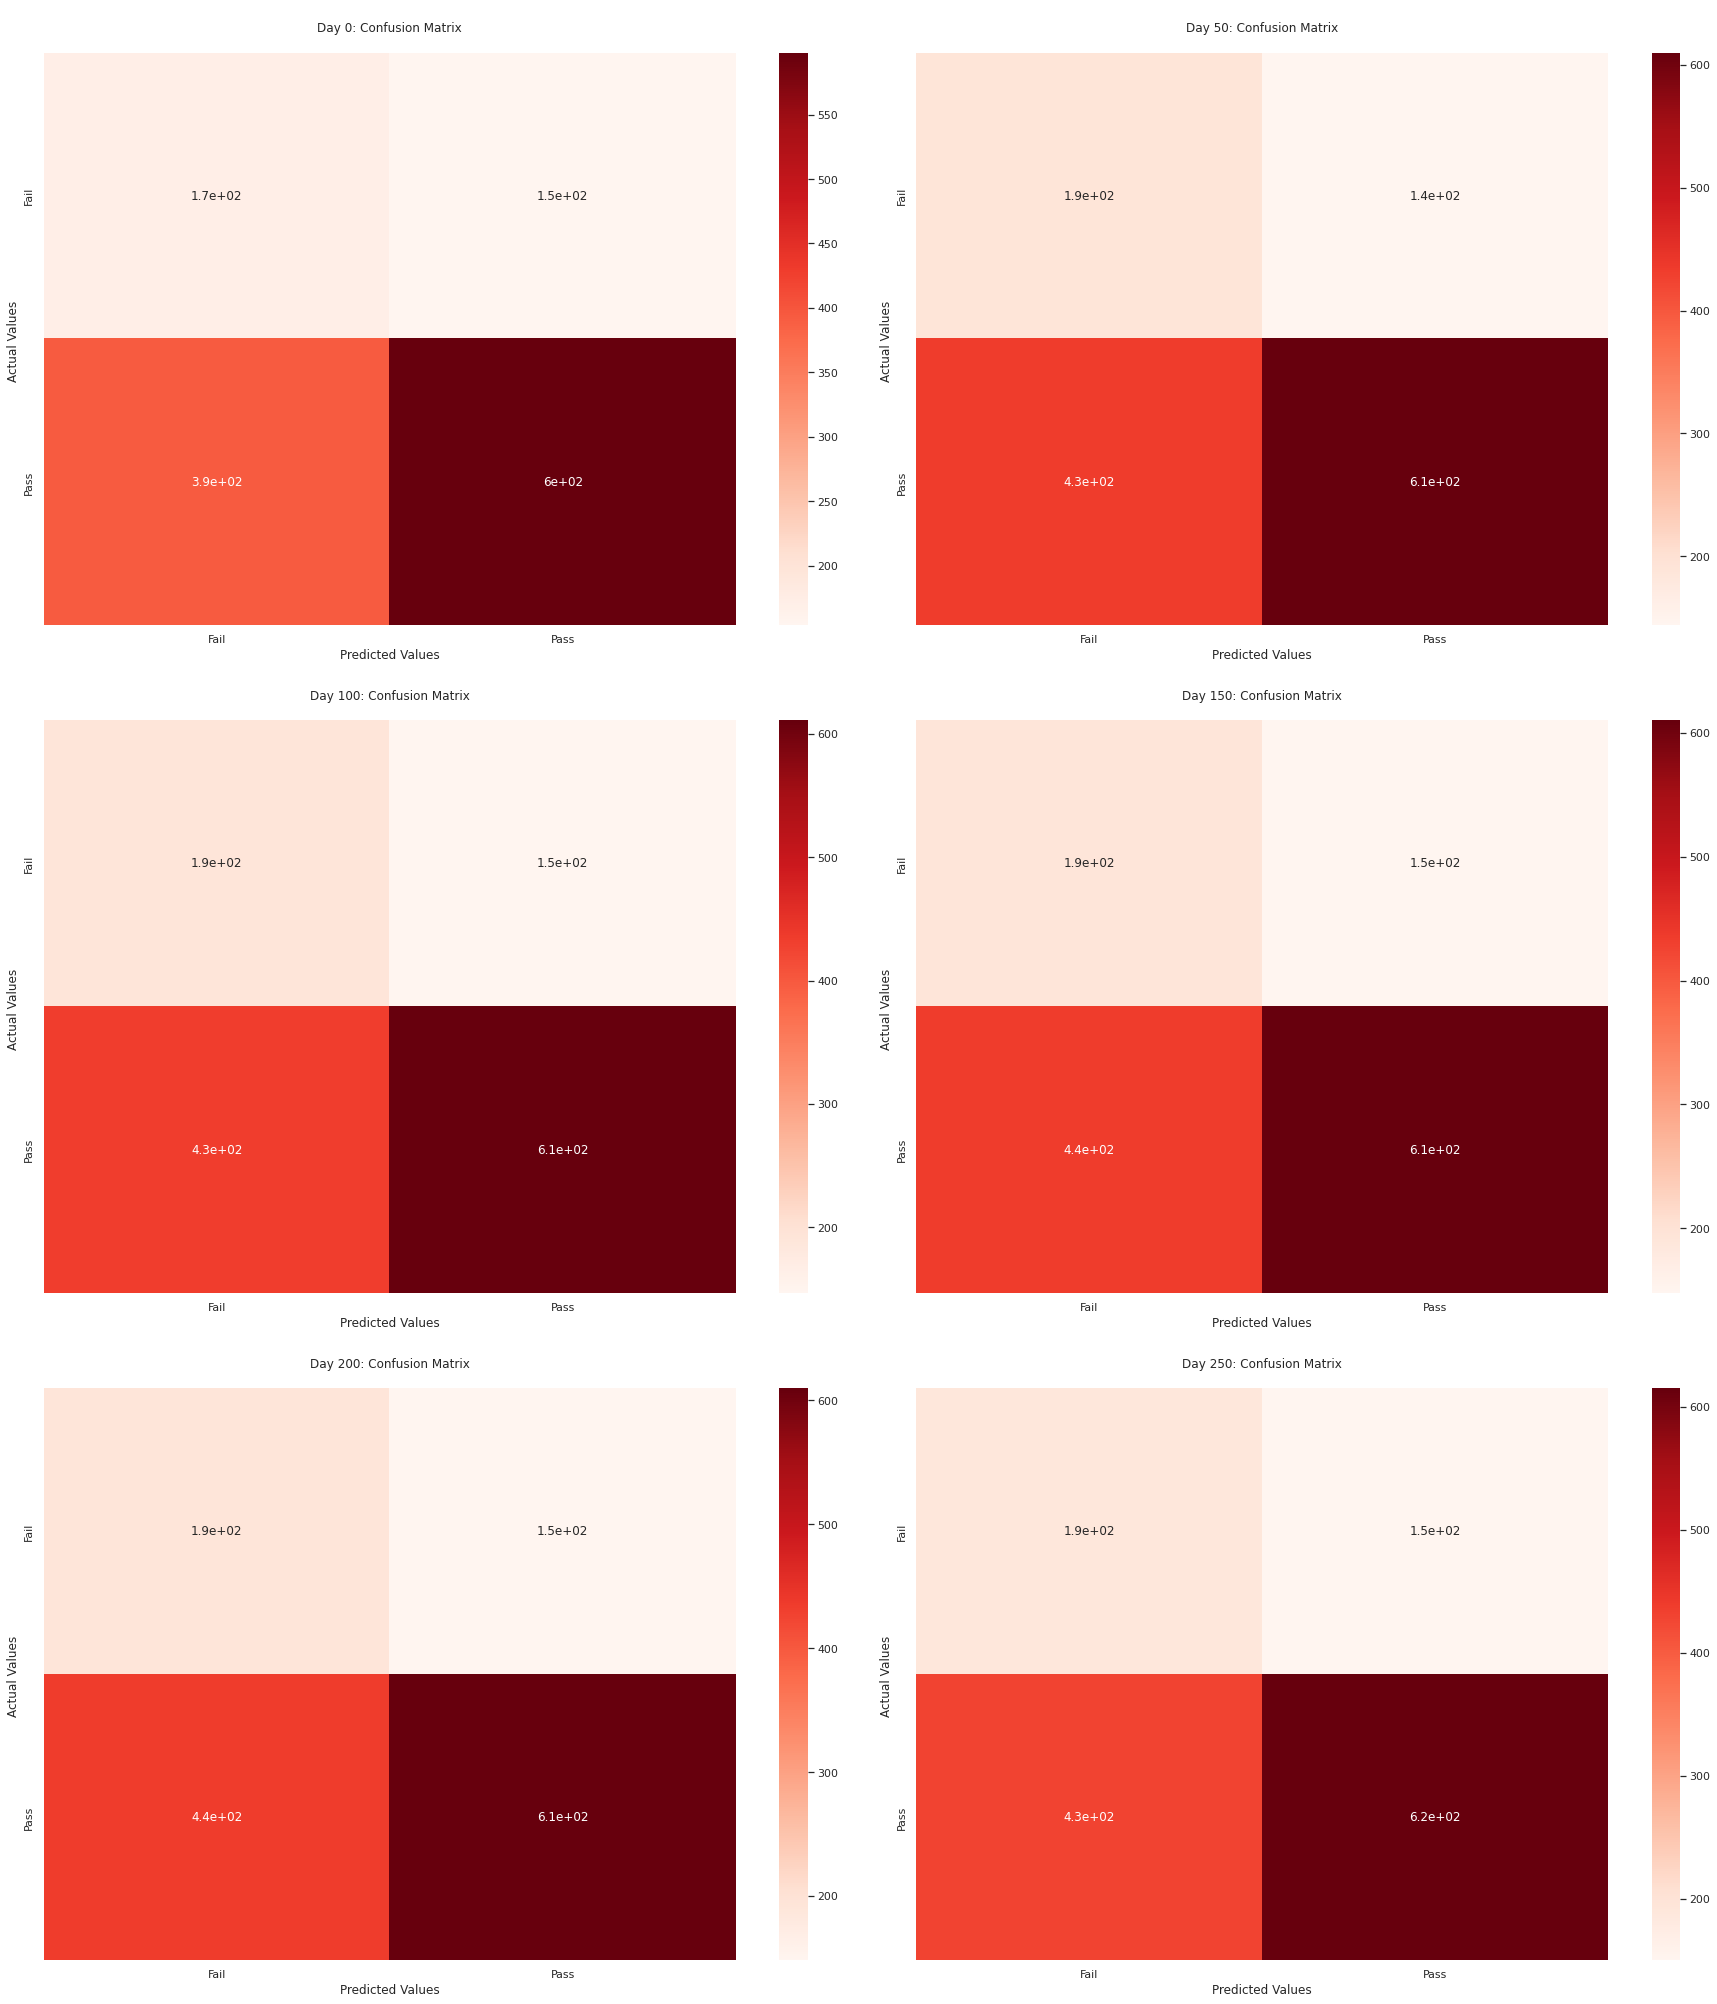

In [ ]:
plot_confusion_matrix(demographic_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

demographic_results_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_rf.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.537
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.6858877086494689, F1 Score: 0.7992240543161979, Precision: 0.7700934579439253, Recall: 0.8306451612903226


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.527
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.6809282088469906, F1 Score: 0.8005439709882141, Precision: 0.7598967297762479, Recall: 0.8457854406130269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.527
Best parameters set:
	clf__n_estimators

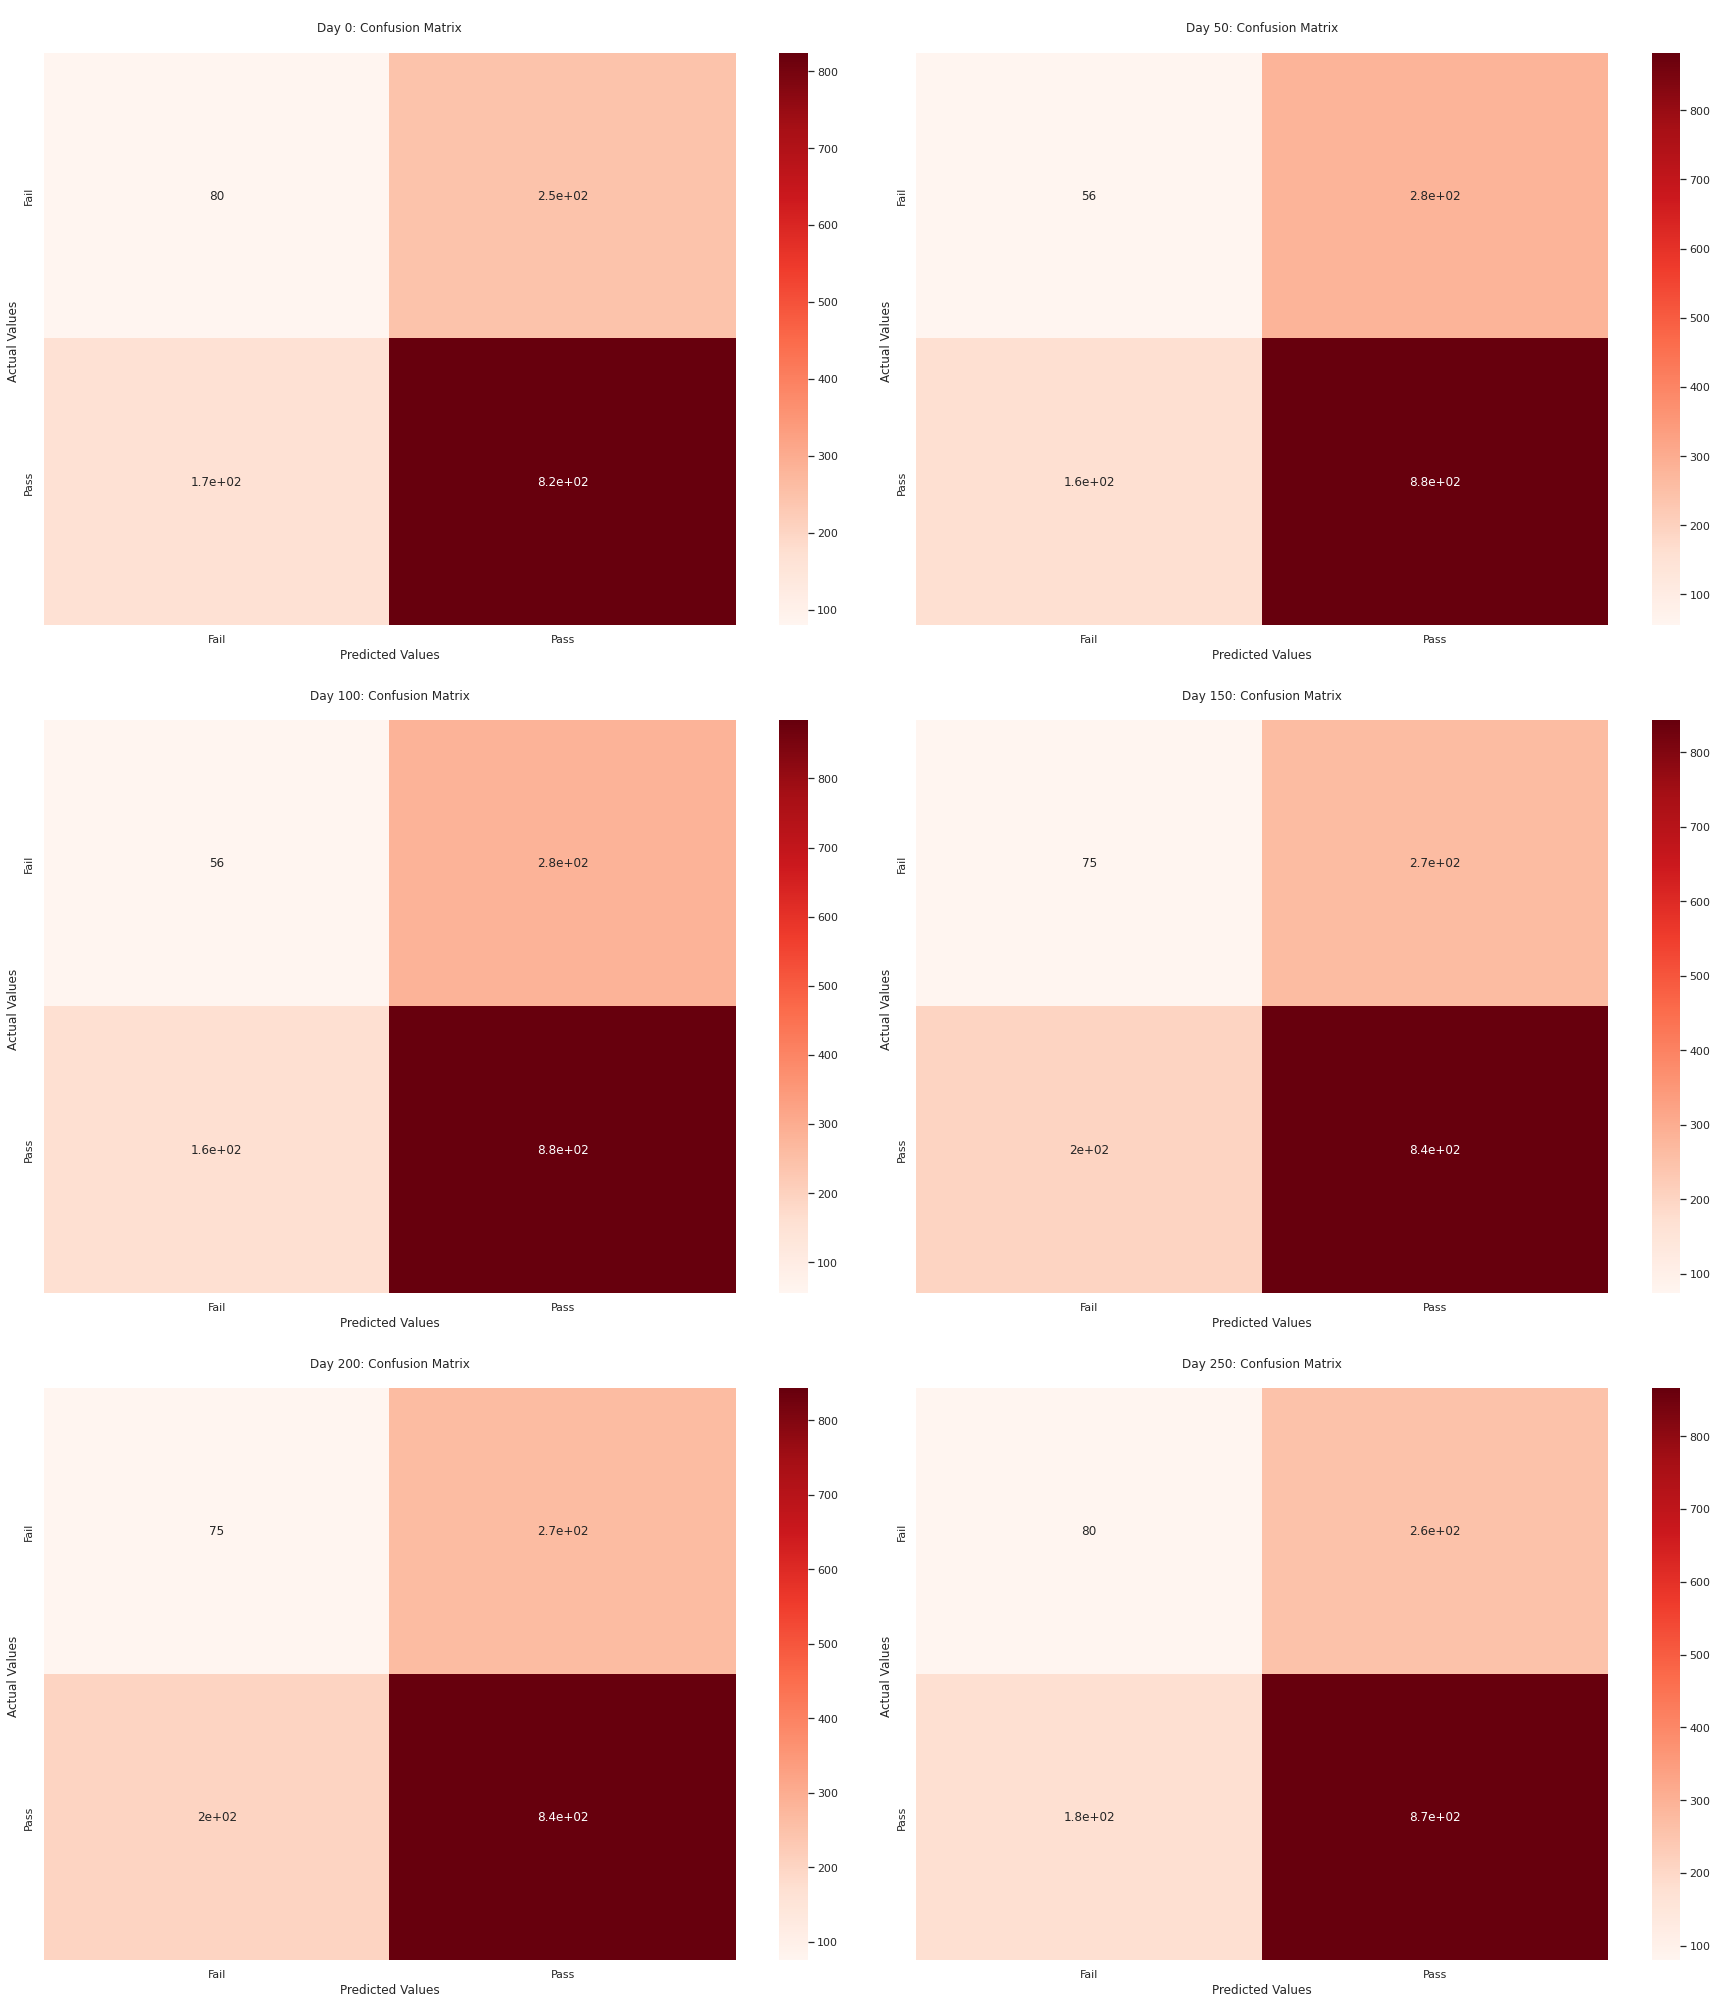

In [ ]:
plot_confusion_matrix(demographic_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

demographic_results_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_ab.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.526
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7382397572078907, F1 Score: 0.841960604672469, Precision: 0.7716204869857263, Recall: 0.9264112903225806


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7469180565627266, F1 Score: 0.8505353319057816, Precision: 0.7691711851278079, Recall: 0.9511494252873564


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.744942196531792, F1 Sco

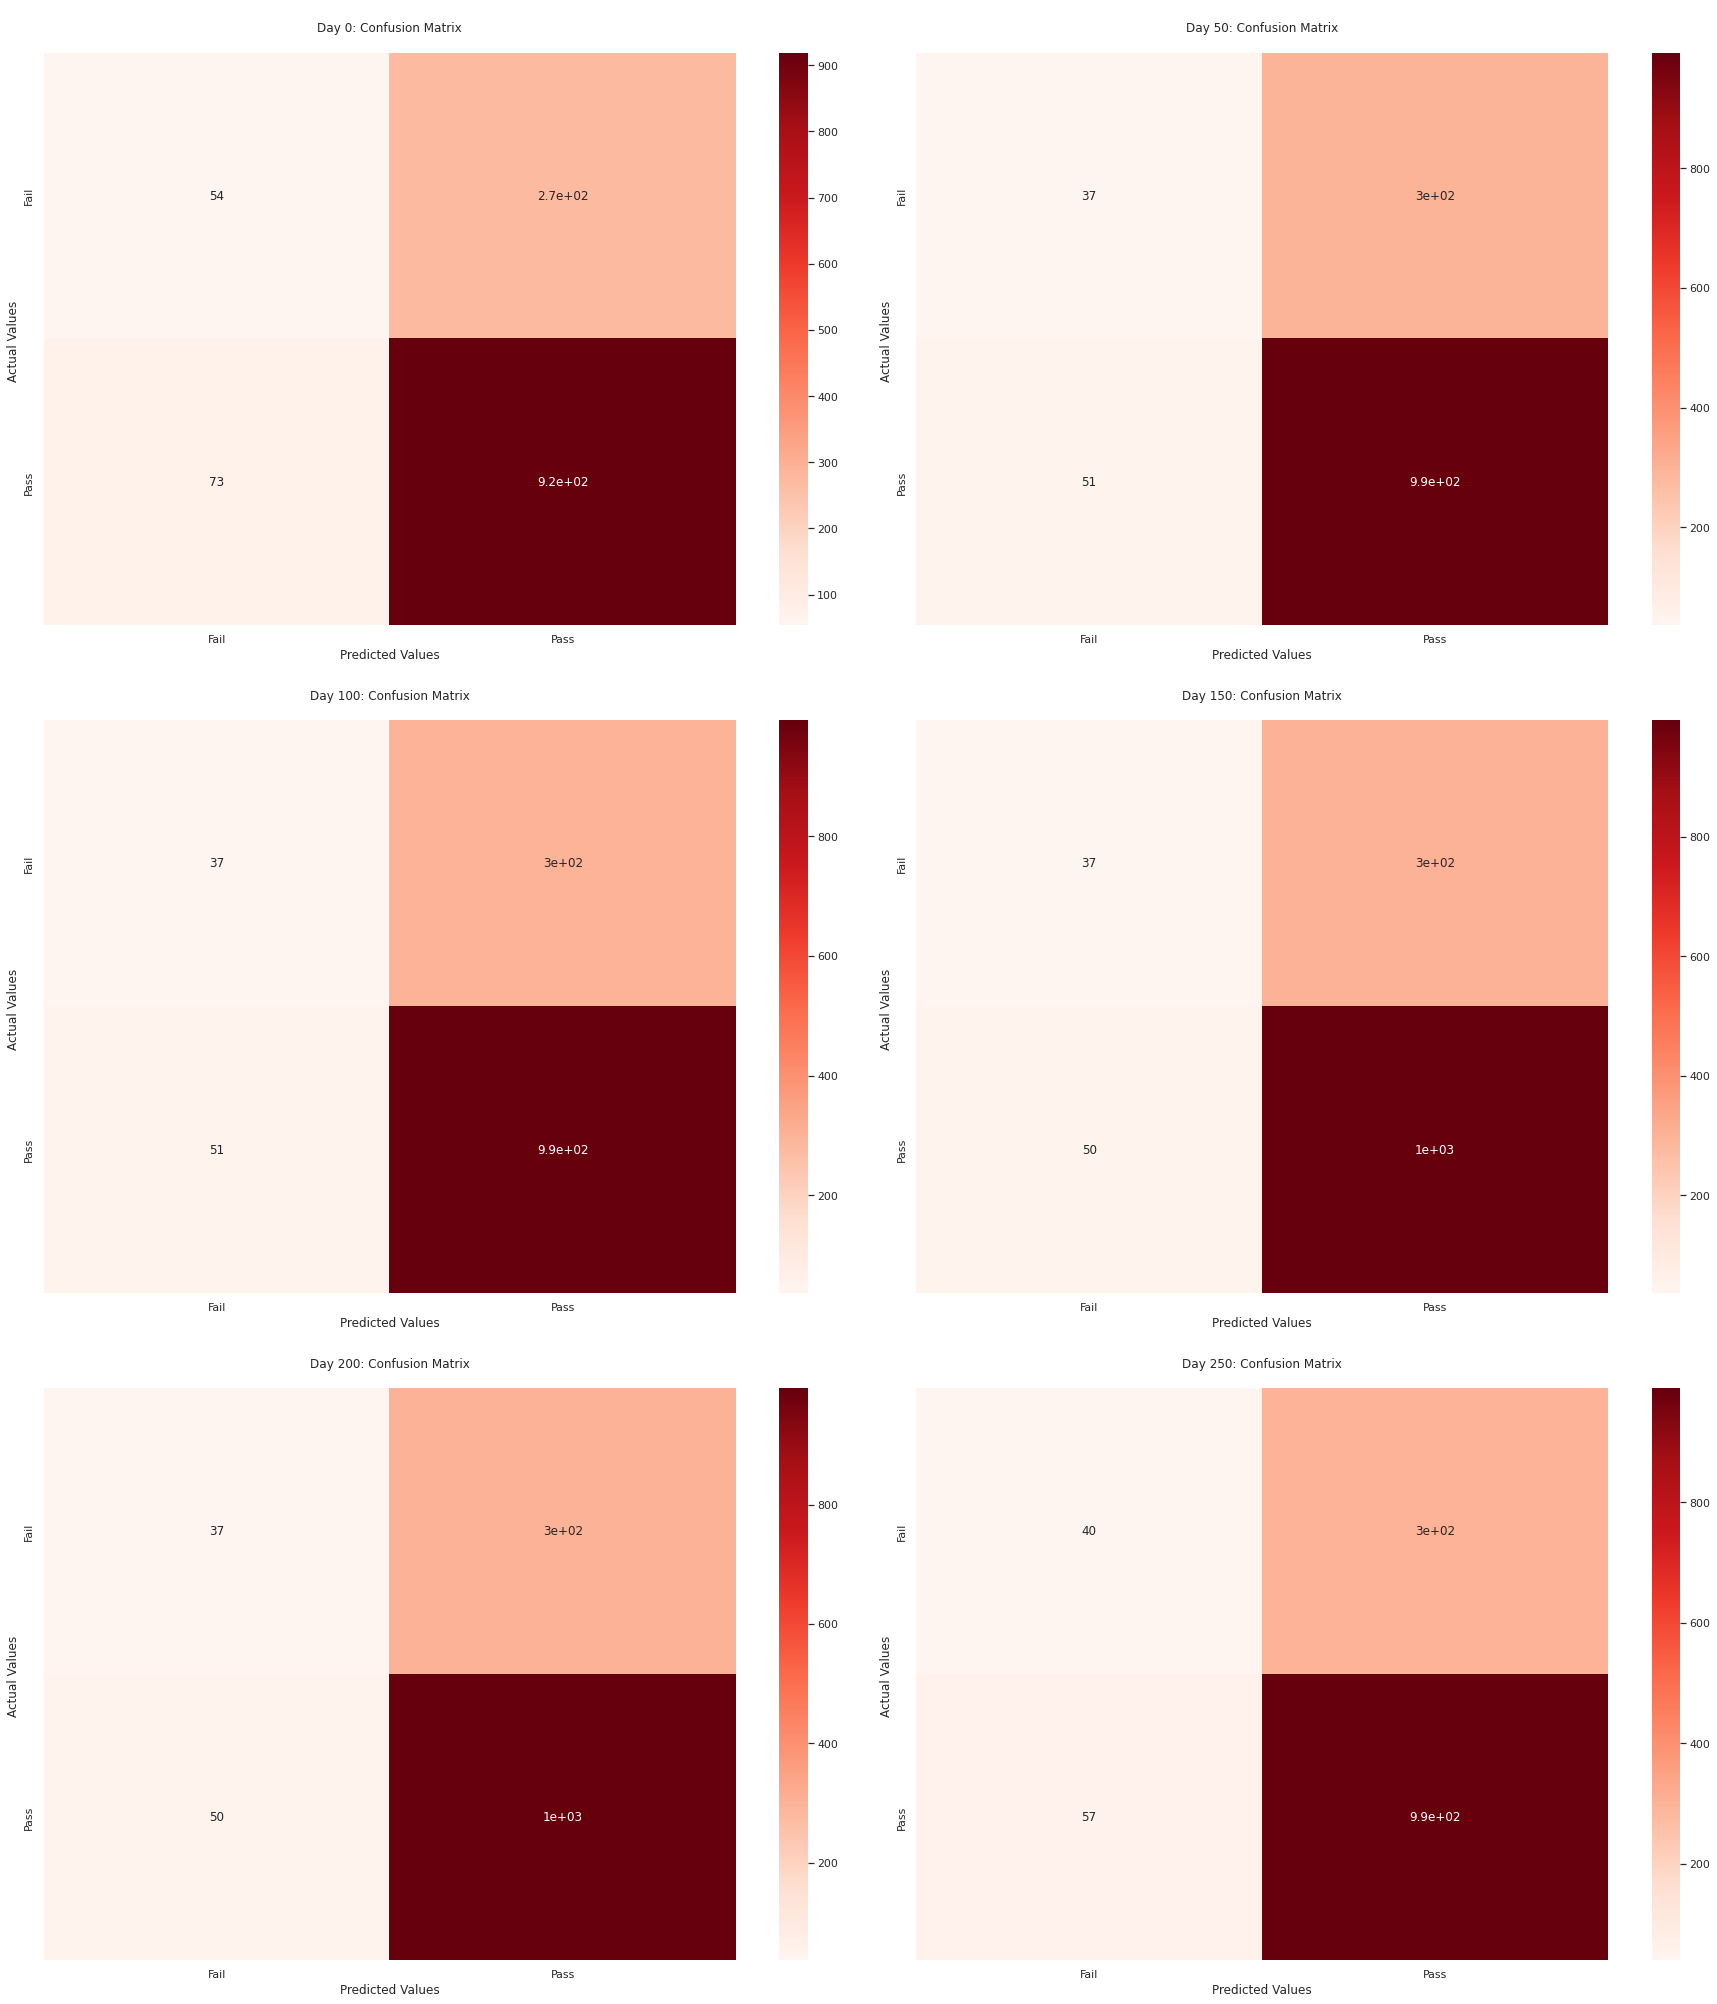

In [ ]:
plot_confusion_matrix(demographic_results_ab)

##### Plot results overview

In [ ]:
demographic_classifier_results = [demographic_results_du, demographic_results_nb, demographic_results_lr, demographic_results_lrw, demographic_results_rf, demographic_results_ab]
demographic_classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

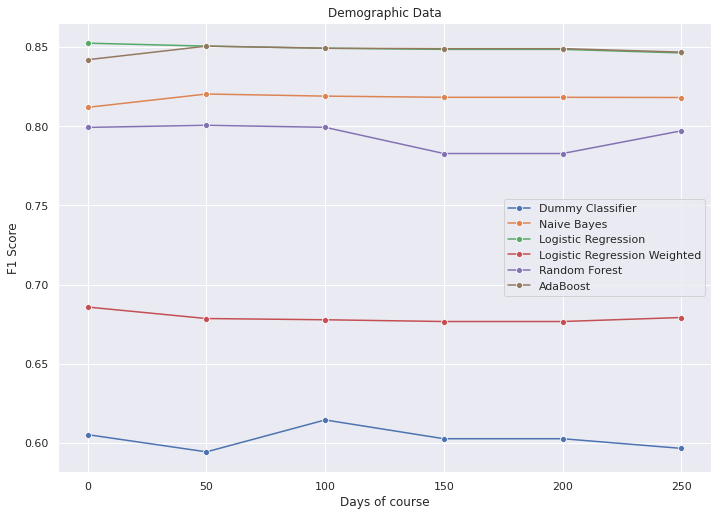

In [ ]:
plot_days_compare(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

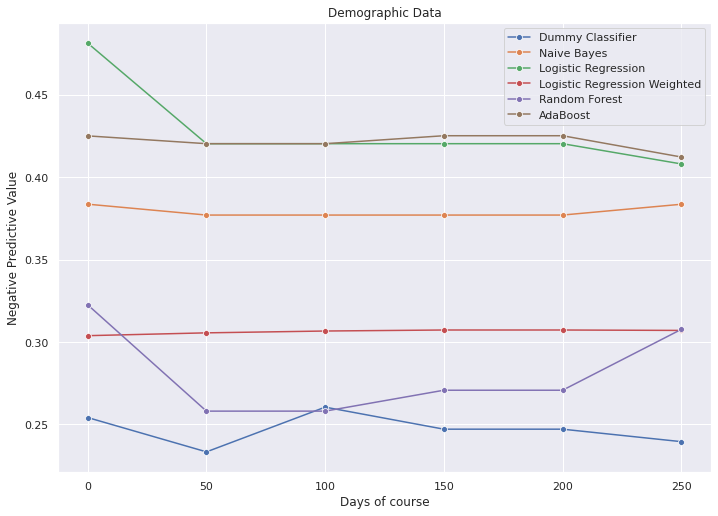

In [ ]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

#### Learning behaviour data

##### Prepare data for prediction

In [ ]:
learning_behaviour_df = {}
for i in df.keys():
  learning_behaviour_df[i] = split_dataframe_by_data_type(df[i], ['learning_behaviour'], include_final_result=True)

In [ ]:
learning_behaviour_df[0]

code_presentation  id_student  ...  ouelluminate  final_result
0                2013B       33915  ...           1.0             1
1                2013B       35544  ...           0.0             1
2                2013B       35860  ...           0.0             1
3                2013B       42668  ...           0.0             1
4                2013B       43273  ...           0.0             1
...                ...         ...  ...           ...           ...
4565             2014J     2681198  ...           0.0             1
4566             2014J     2682682  ...           0.0             1
4567             2014J     2683857  ...           0.0             1
4568             2014J     2693932  ...           0.0             1
4569             2014J     2697921  ...           0.0             1

[4570 rows x 19 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(learning_behaviour_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['dualpane', 'glossary', 'mean_click', 'questionnaire', 'subpage',
       'ouwiki', 'oucollaborate', 'quiz', 'page', 'url', 'resource', 'forumng',
       'oucontent', 'homepage'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'glossary', 'mean_click', 'questionnaire', 'subpage',
       'ouwiki', 'oucollaborate', 'quiz', 'page', 'url', 'resource', 'forumng',
       'oucontent', 'homepage'],
      dtype='object')
Index([], dtype='object') Index(['repeatactivity', 'dualpane', 'glossary', 'mean_click', 'questionnaire',
       'subpage', 'ouwiki', 'oucollaborate', 'quiz', 'page', 'url', 'resource',
       'forumng', 'oucontent', 'homepage'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'folder', 'homepage', 'glossary', 'questionnaire', 'ouwiki',
       'url', 'resource', 'mean_click', 'subpage', 'dataplus', 'page',
       'forumng', 'oucollaborate', 'repeatactivity', 'dualpane', 'oucontent'],
      dtype='object')
Index(

###### Undersampling

In [ ]:
Y_train[0].value_counts()

1    984
0    407
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 984, 0: 407})
Resample dataset shape Counter({0: 407, 1: 407})
Sampling for day 50
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 100
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 150
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 200
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 250
Original dataset shape: Counter({1: 1028, 0: 425})
Resample dataset shape Counter({0: 425, 1: 425})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train[i].index)
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test[i].index)

In [ ]:
X_train[250]

quiz    folder  questionnaire  mean_click  dataplus
1074  0.212644  0.000000       0.000000    0.290539  0.000000
1075  0.205107  0.333333       0.403846    0.408801  0.228571
1076  0.289655  0.000000       0.416667    0.314375  0.000000
1077  0.167488  0.000000       0.375000    0.302567  0.000000
1078  0.215654  0.333333       0.390625    0.334175  0.155556
...        ...       ...            ...         ...       ...
2522  0.375642  0.541667       0.000000    0.372705  0.000000
2523  0.022989  0.000000       0.375000    0.303721  0.000000
2524  0.000000  0.000000       0.000000    0.048945  0.000000
2525  0.422153  0.333333       0.000000    0.383681  0.000000
2526  0.261303  0.500000       0.000000    0.303726  0.000000

[1453 rows x 5 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

learning_behaviour_results_du = []
learning_behaviour_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.485
Best parameters set:
Accuracy: 0.5060698027314112, F1 Score: 0.6052152819890844, Precision: 0.7595129375951294, Recall: 0.5030241935483871


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best

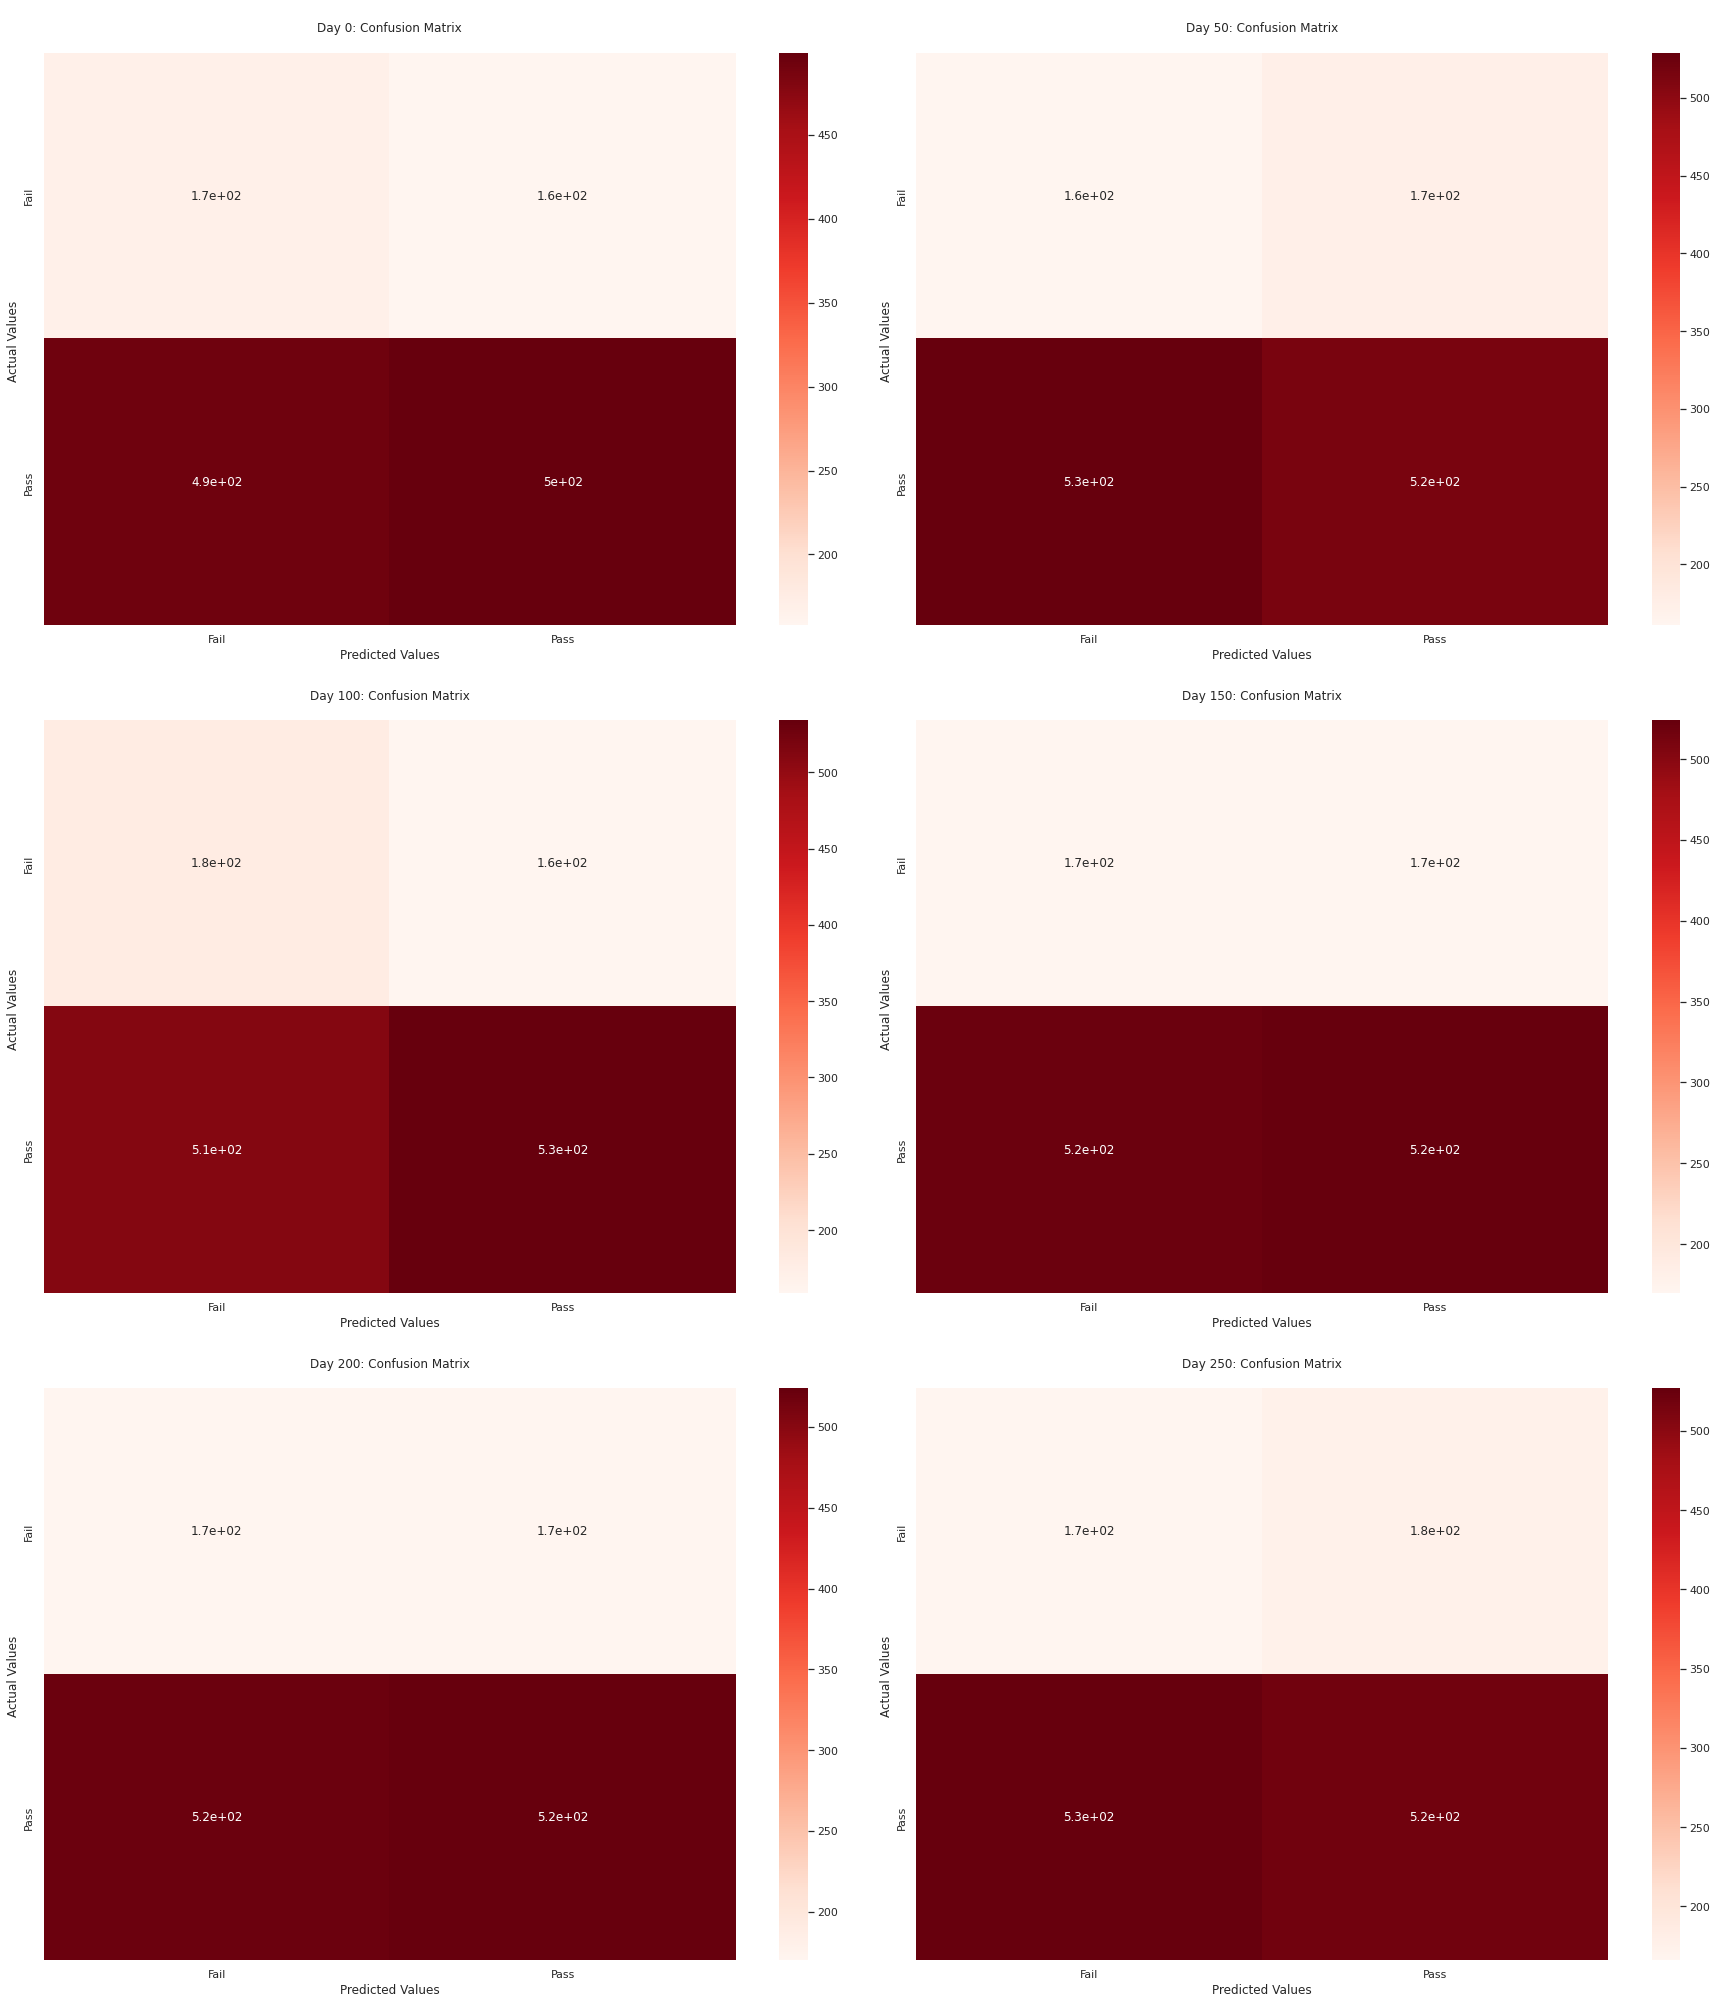

In [ ]:
plot_confusion_matrix(learning_behaviour_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

learning_behaviour_results_nb = []
learning_behaviour_features_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_nb.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.503
Best parameters set:
Accuracy: 0.4271623672230653, F1 Score: 0.4509090909090909, Precision: 0.8093994778067886, Recall: 0.3125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.636
Best parameters set:
Accuracy: 0.5387962291515591, F1 Score: 0.6025, Precision: 0.8669064748201439, Recall: 0.4616858237547893


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.659
Best parameters set:
Accuracy: 0.5267341040462428, F1 Score: 0.5862286797220467, Precision: 0.862453531598513, Recall: 0.44401913875598087


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.664
Best parameters set:
Accurac

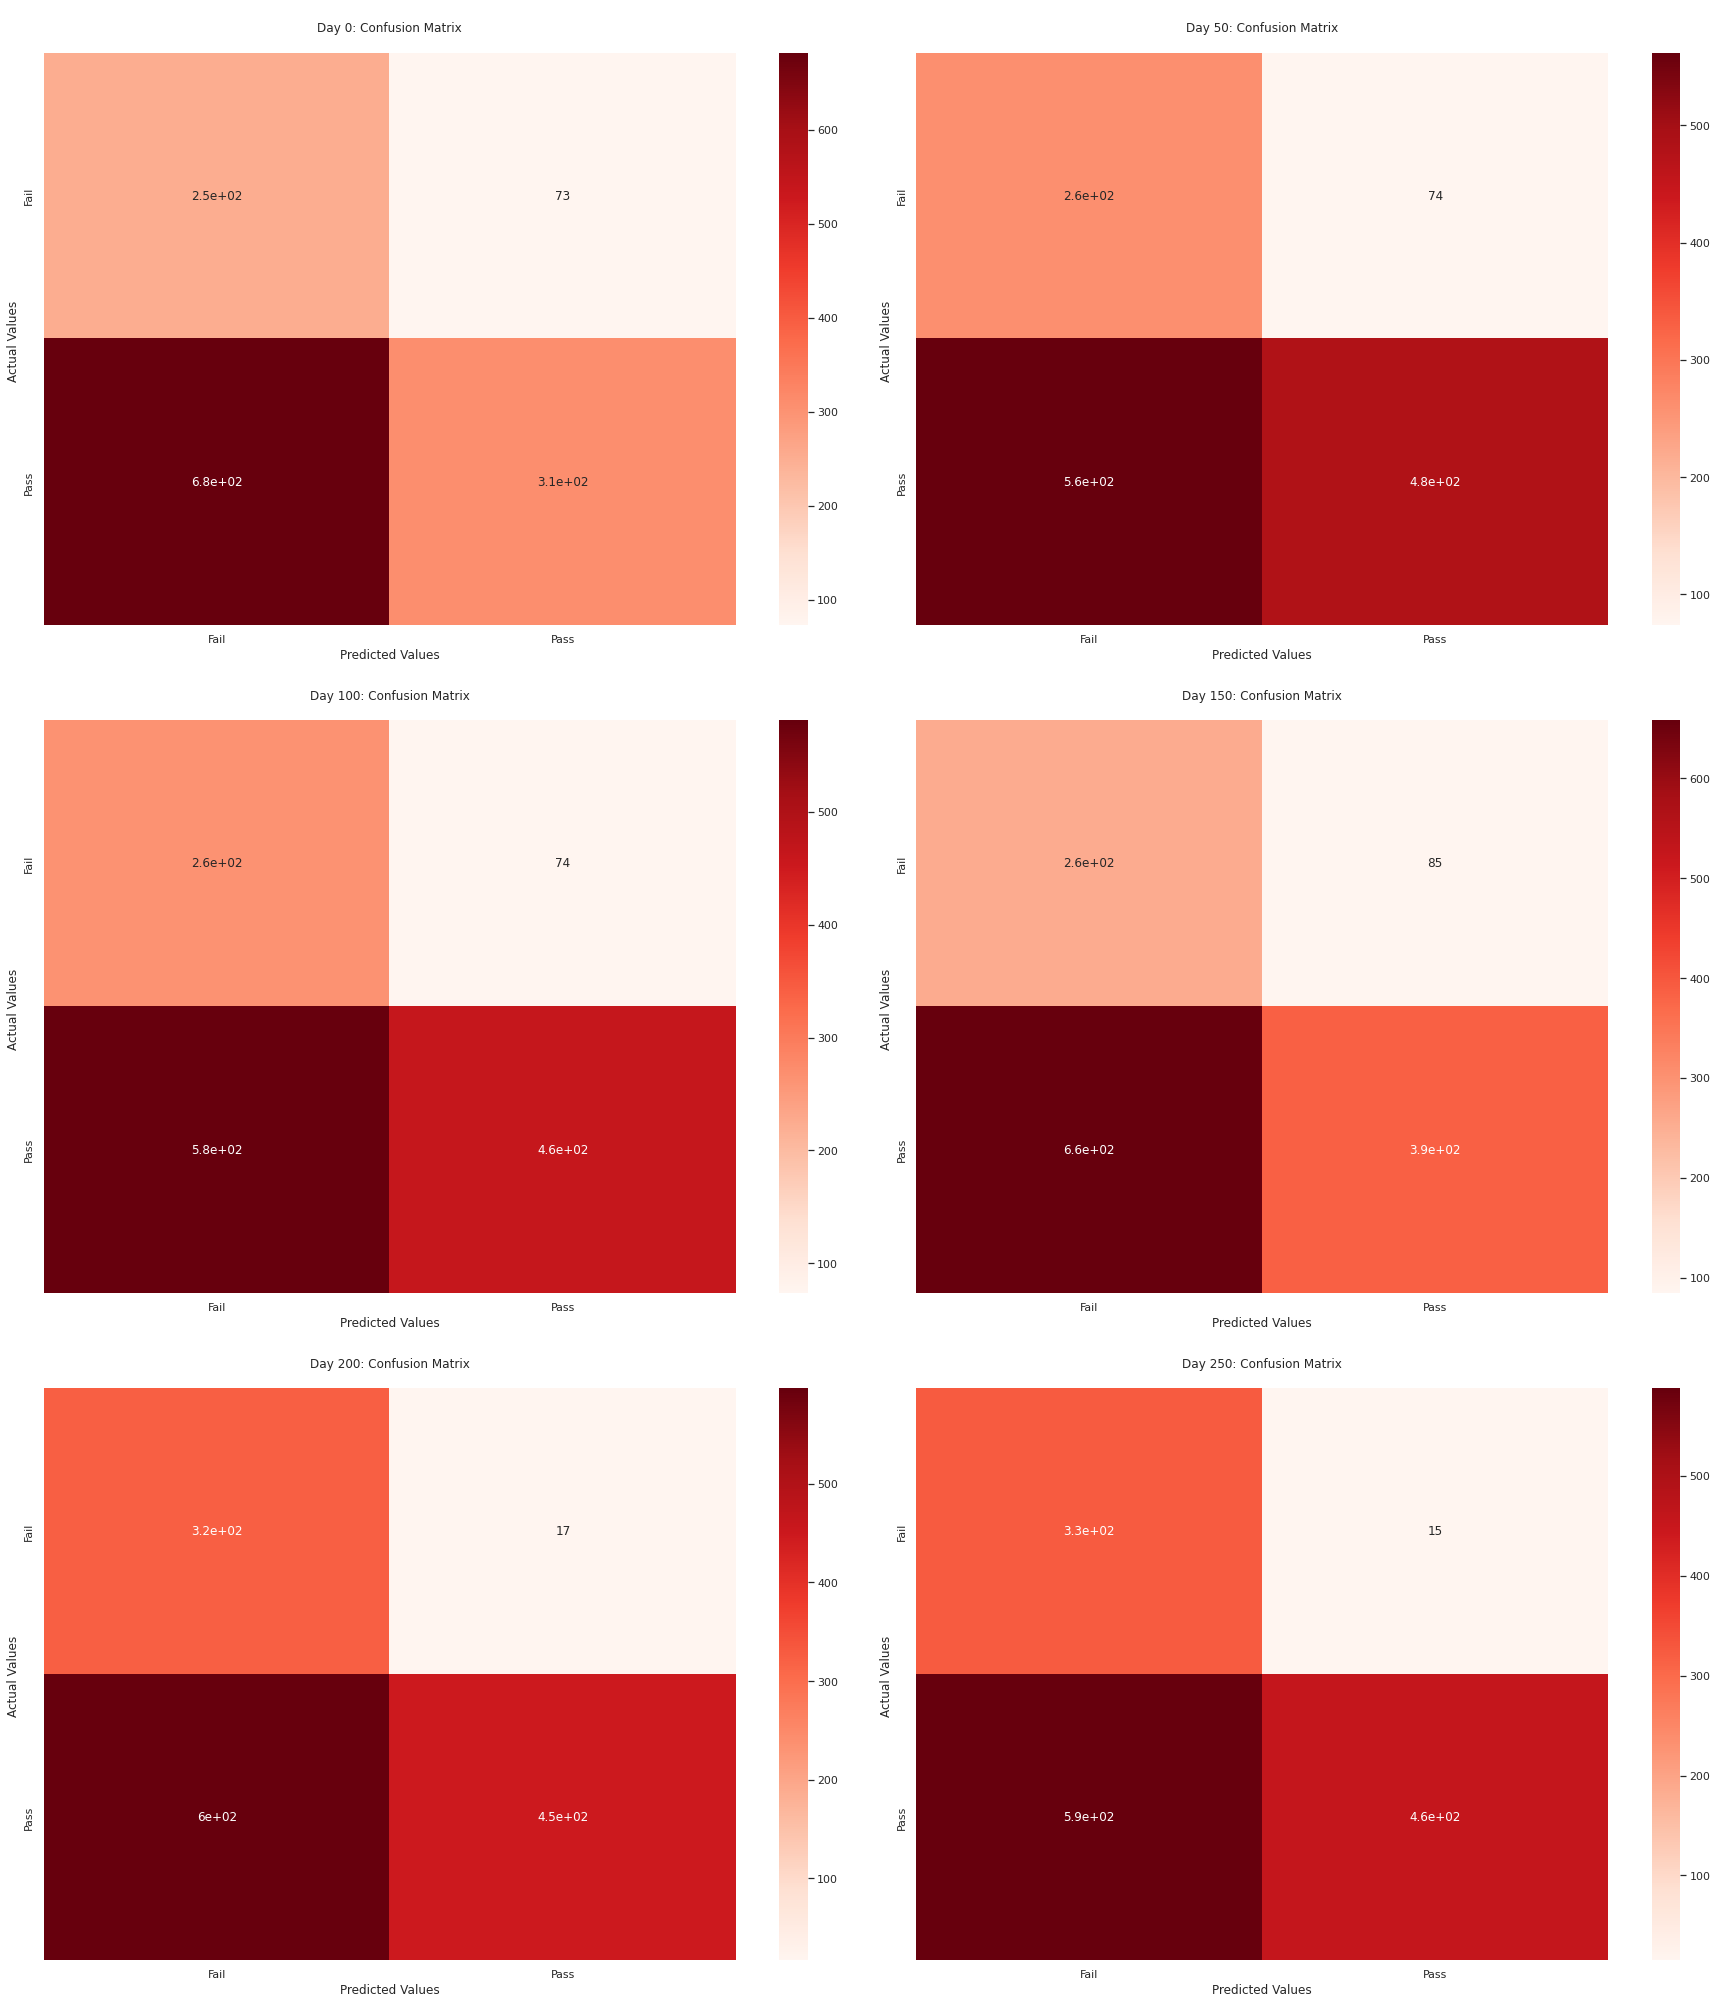

In [ ]:
plot_confusion_matrix(learning_behaviour_results_nb)

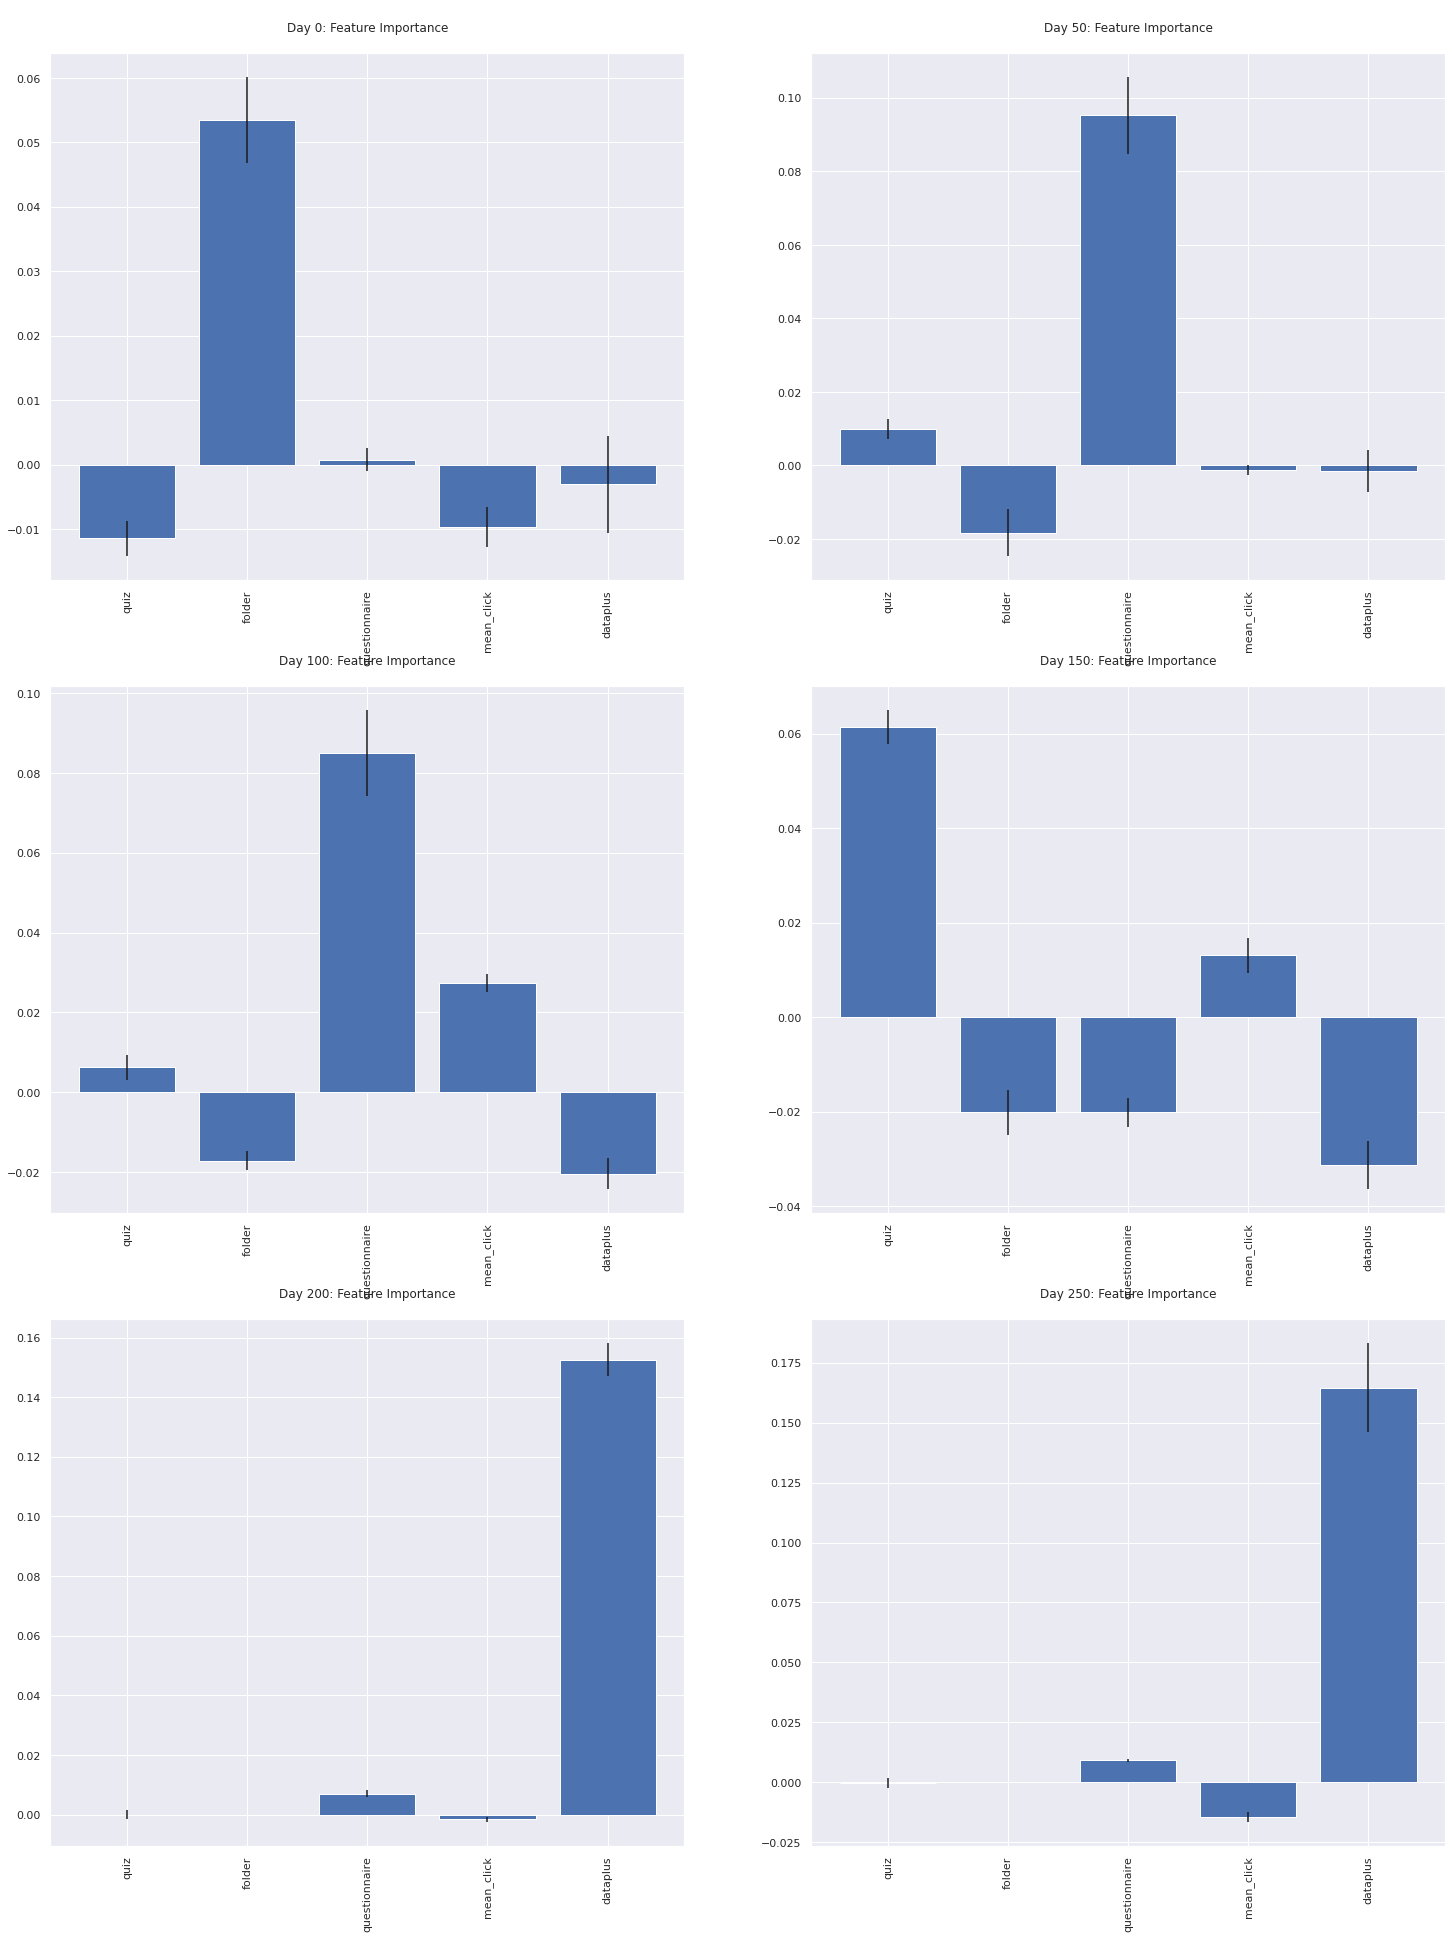

In [ ]:
plot_feature_importance(learning_behaviour_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

learning_behaviour_results_lr = []
learning_behiviour_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.414
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7526555386949925, F1 Score: 0.8588744588744589, Precision: 0.7526555386949925, Recall: 1.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.634
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7737490935460478, F1 Score: 0.8575342465753425, Precision: 0.819371727748691, Recall: 0.8994252873563219


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.655
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7644508670520231, F1 Score: 0.8505957836846929, Precision: 0.8161829375549692, Recall: 0.8880382775119617


Day 150
Pe

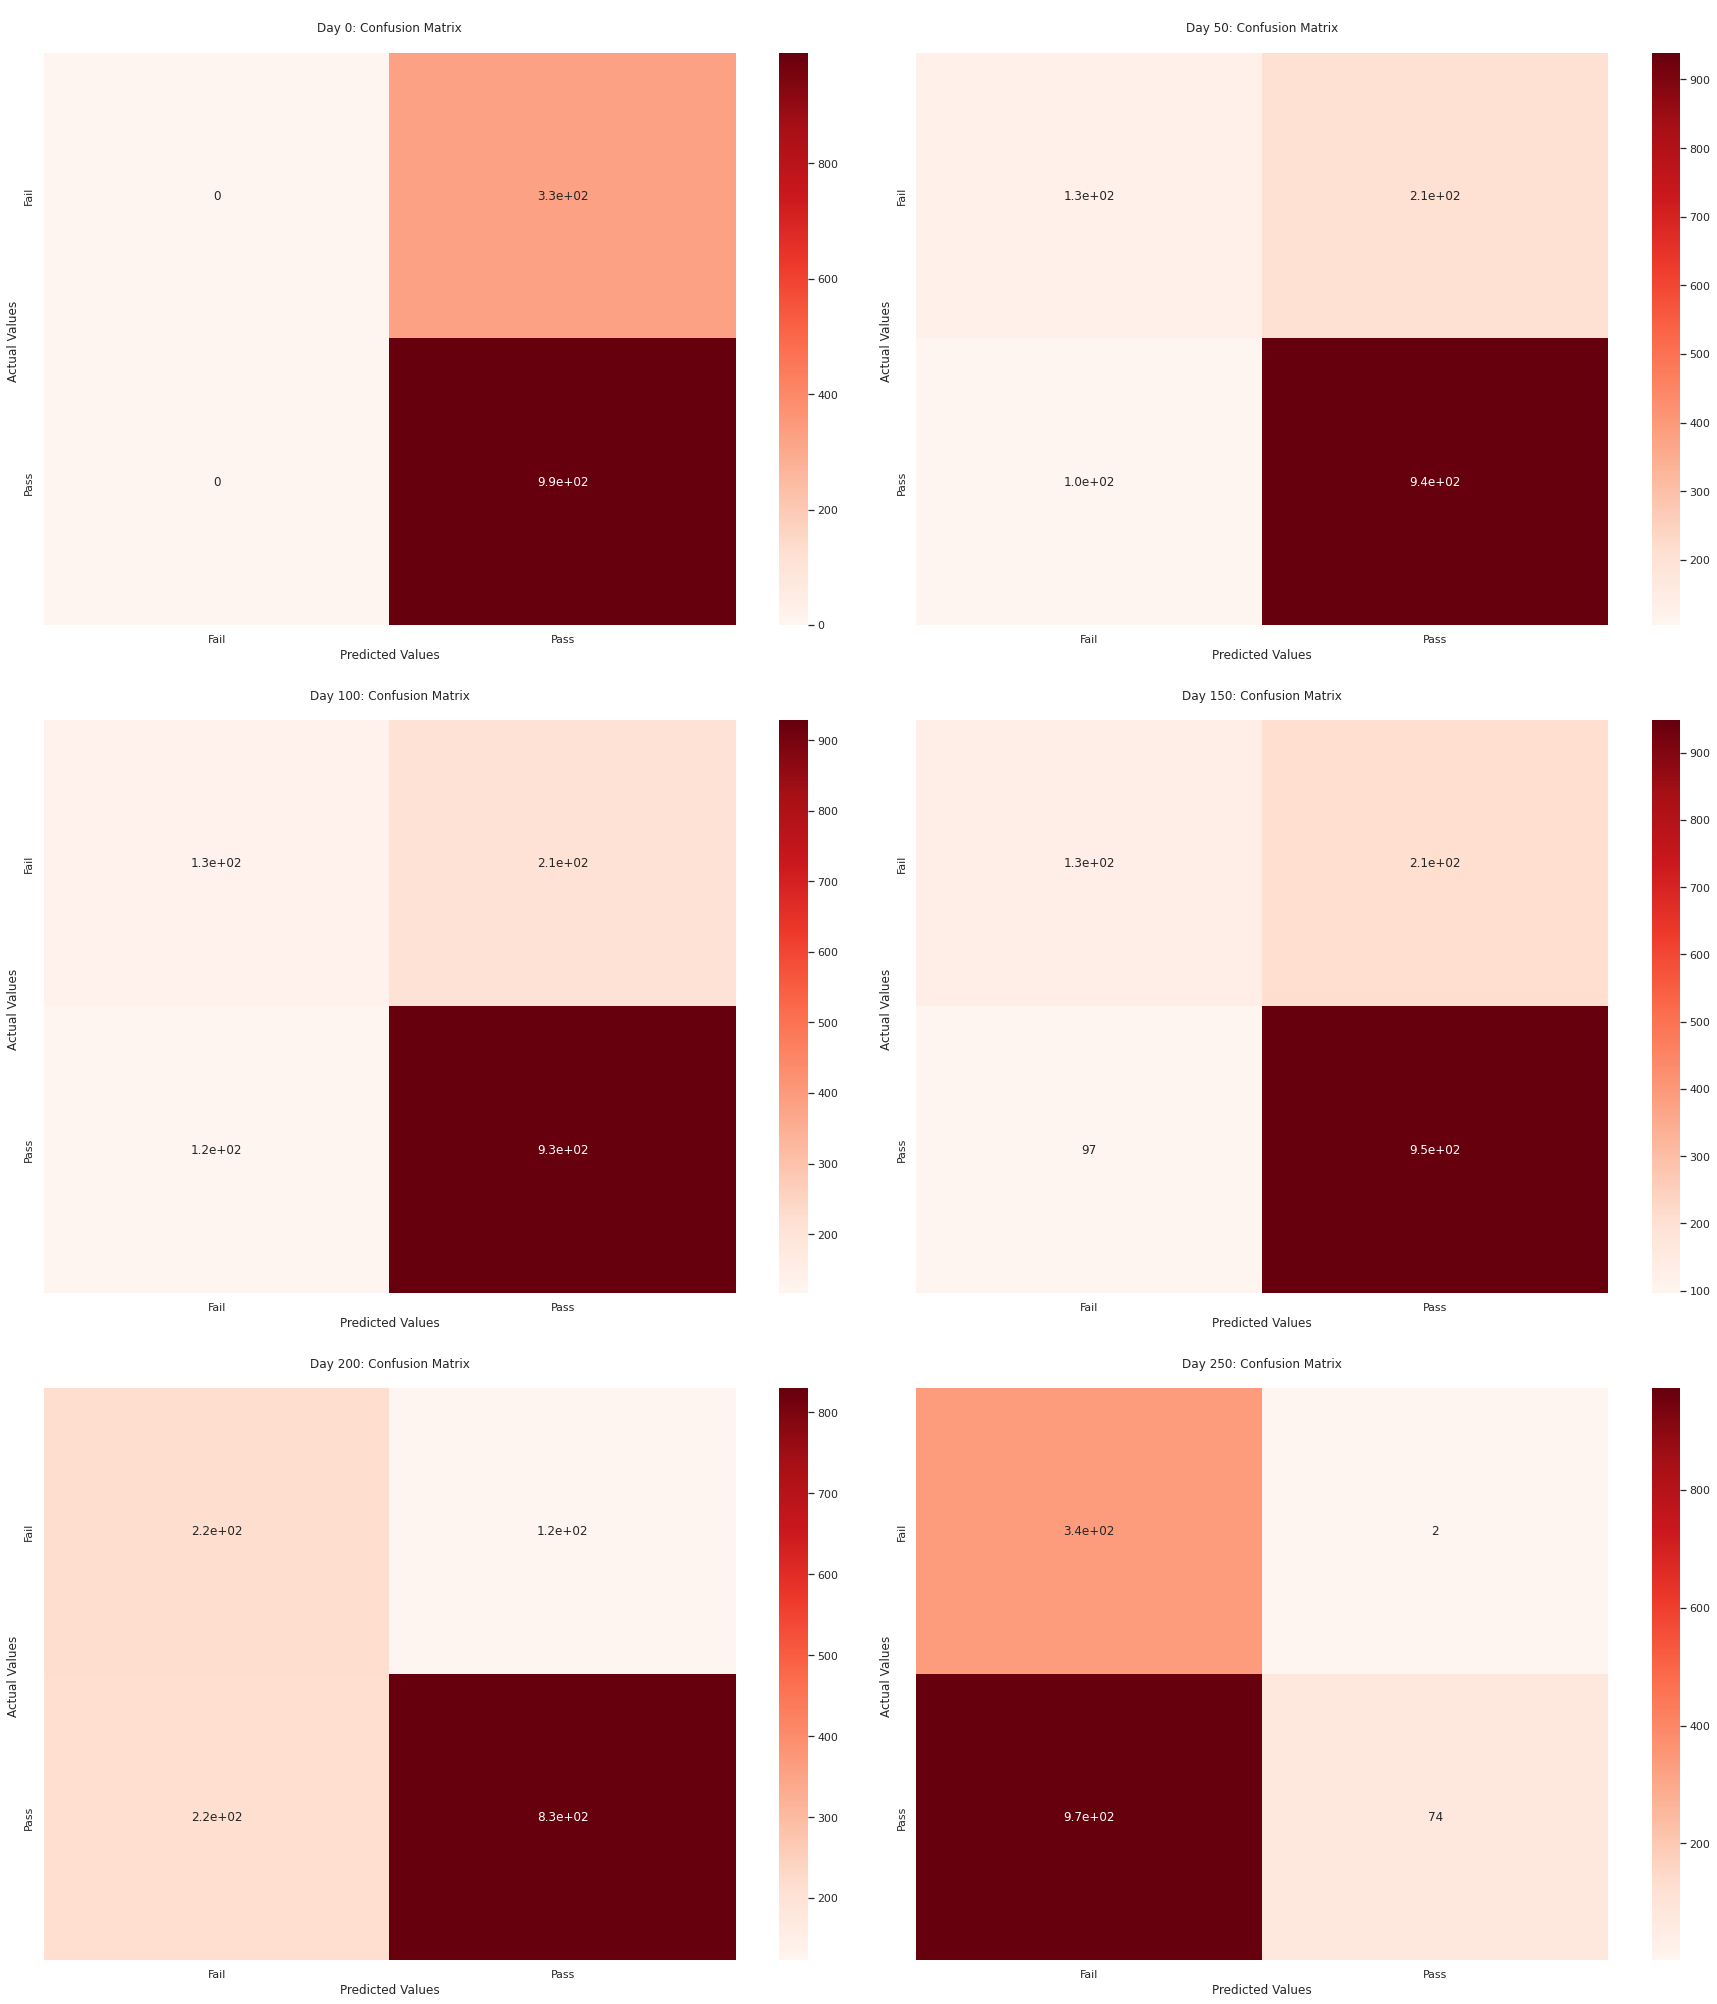

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lr)

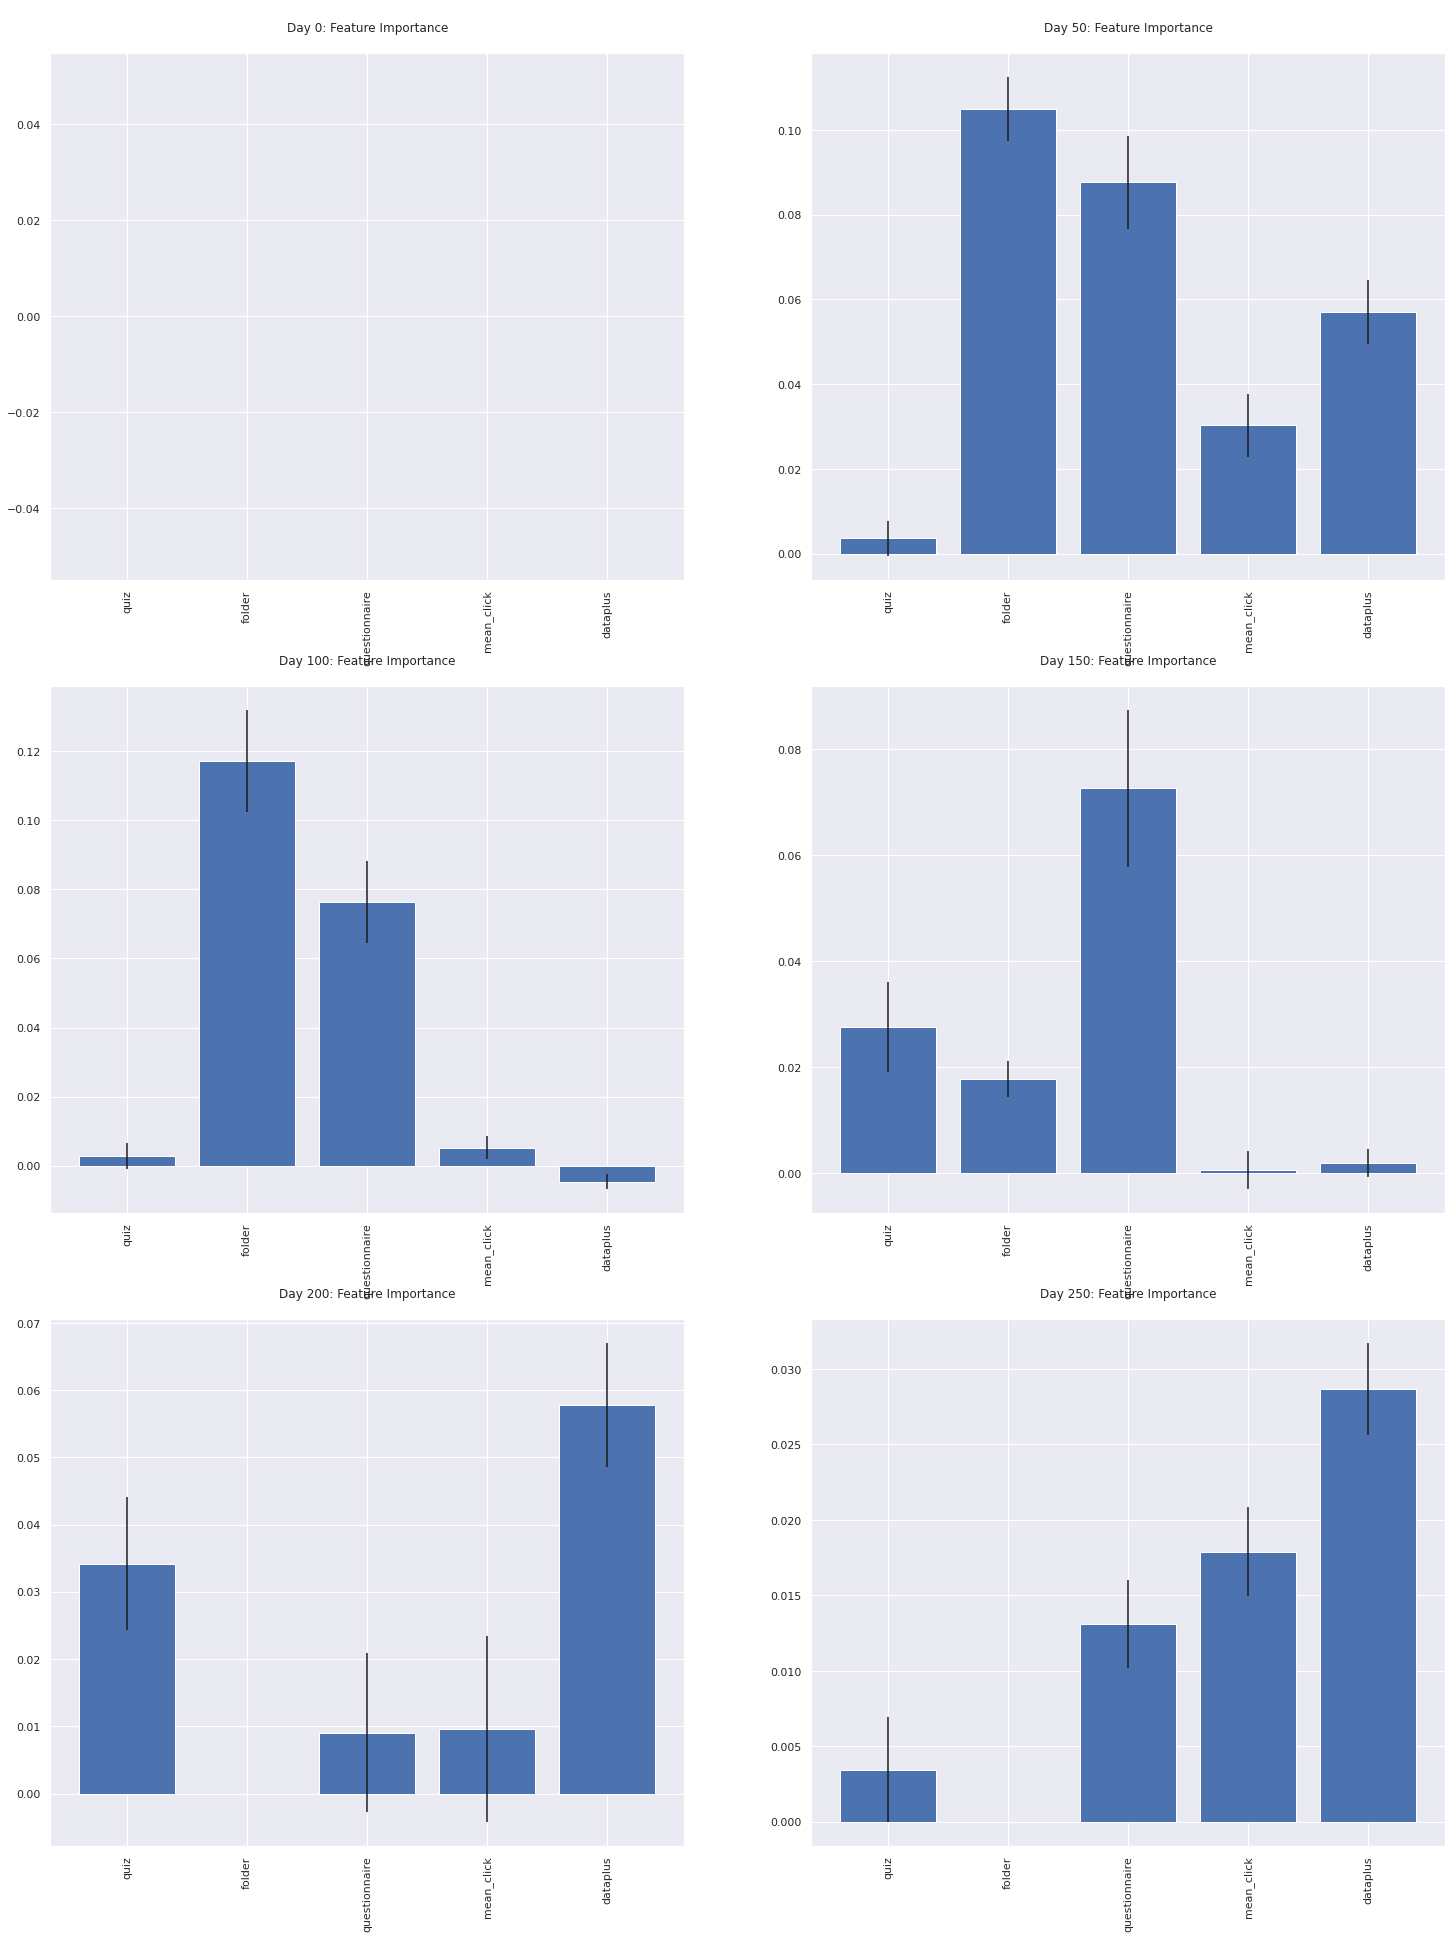

In [ ]:
plot_feature_importance(learning_behiviour_features_lr)

##### WeightedLogisticRegression

In [ ]:
learning_behaviour_results_lrw = []
learning_behaviour_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_lrw.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.589
Best parameters set:
Accuracy: 0.5887708649468892, F1 Score: 0.6687041564792175, Precision: 0.8493788819875776, Recall: 0.5514112903225806


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.667
Best parameters set:
Accuracy: 0.6446700507614214, F1 Score: 0.7295805739514348, Precision: 0.8606770833333334, Recall: 0.6331417624521073


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.677
Best parameters set:
Accuracy: 0.6459537572254336, F1 Score: 0.7268673355629877, Precision: 0.8704939919893191, Recall: 0.6239234449760765


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.693
Best

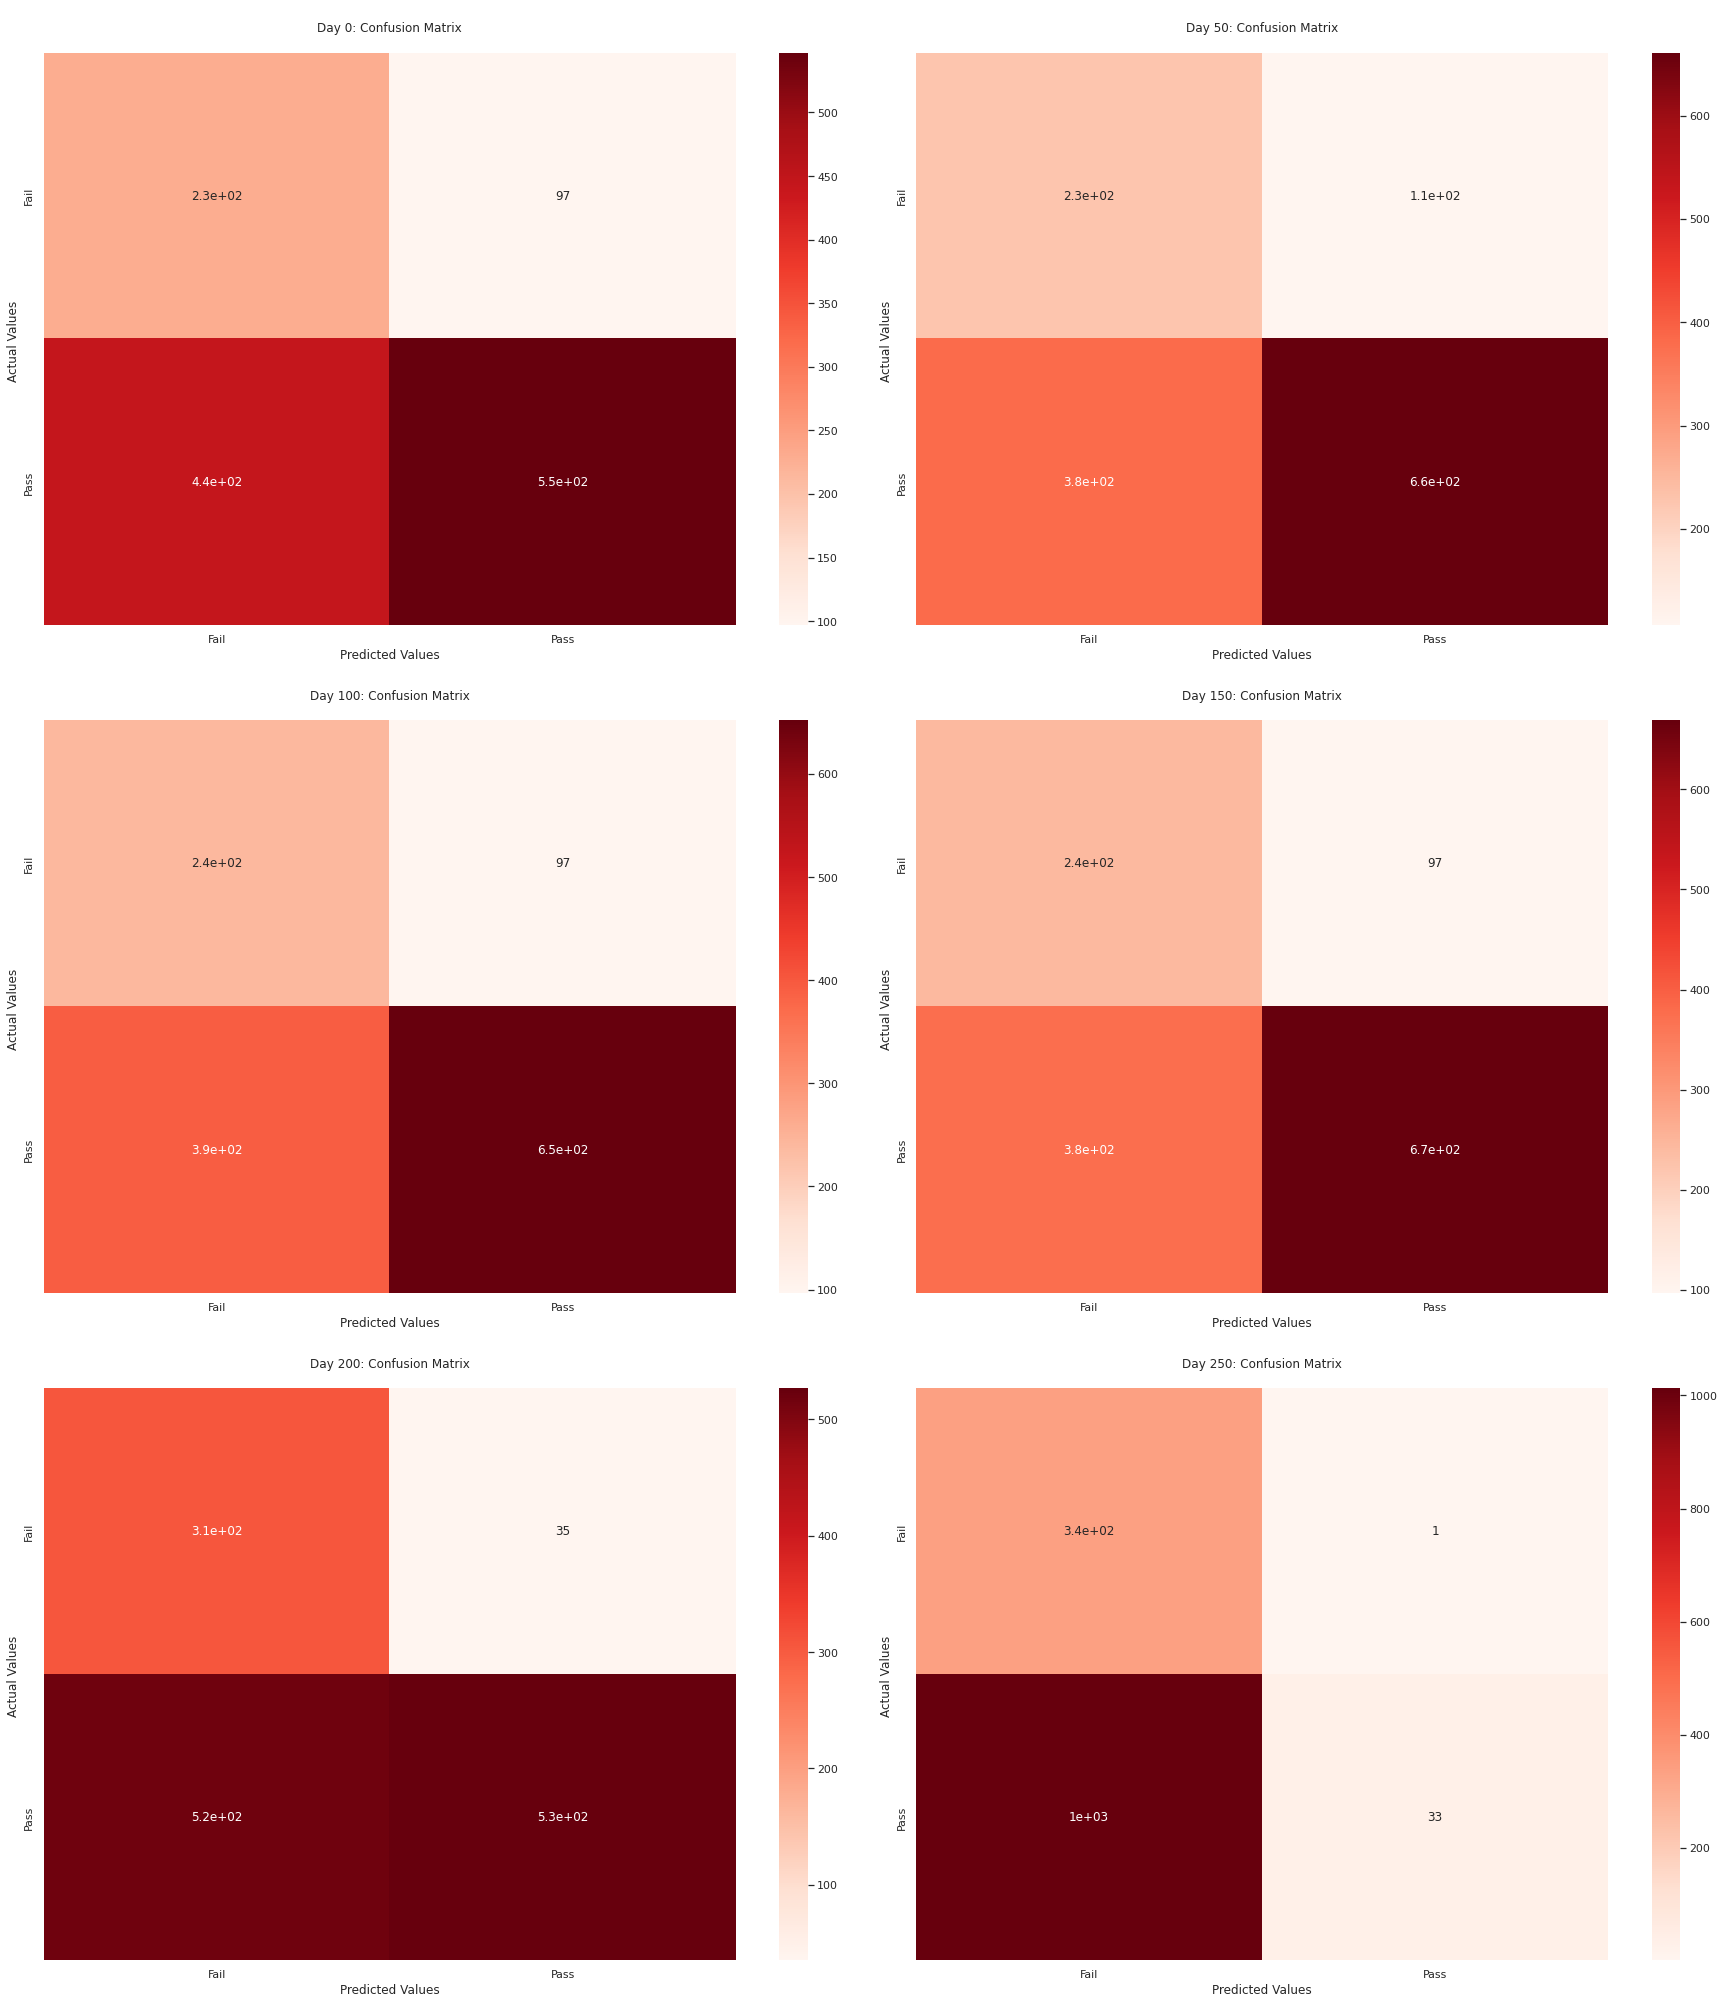

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lrw)

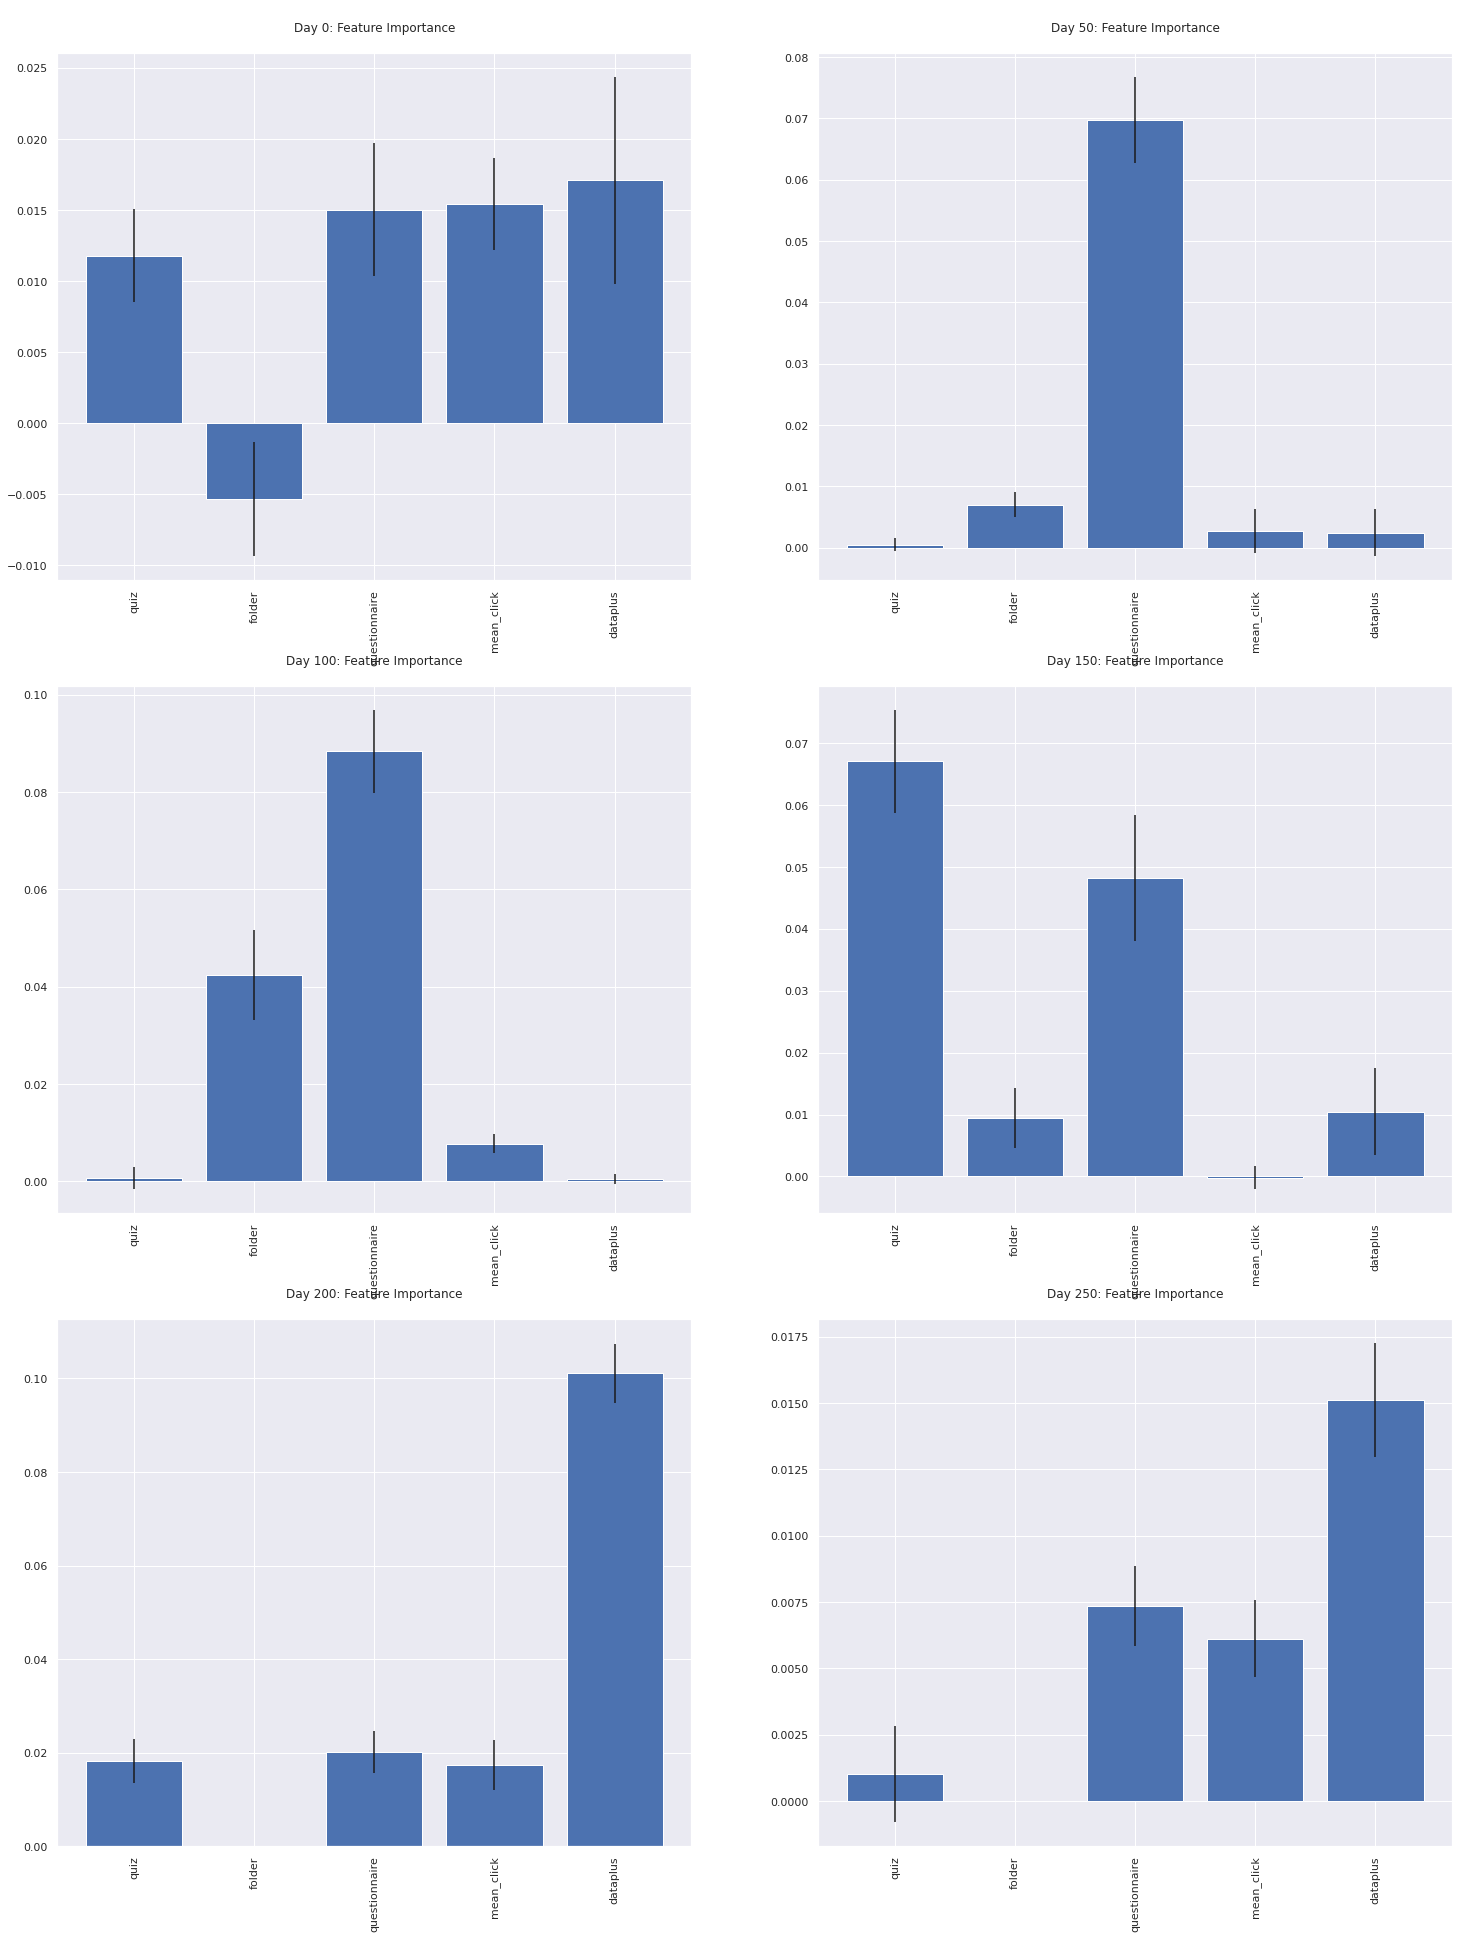

In [ ]:
plot_feature_importance(learning_behaviour_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

learning_behaviour_results_rf = []
learning_behaviour_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.540
Best parameters set:
	clf__n_estimators: 140
Accuracy: 0.6881638846737481, F1 Score: 0.8005822416302766, Precision: 0.7717492984097287, Recall: 0.8316532258064516


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.614
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.7280638143582306, F1 Score: 0.8240262787423746, Precision: 0.8077276908923643, Recall: 0.8409961685823755


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.620
Best parameters set:
	clf__n_estimator

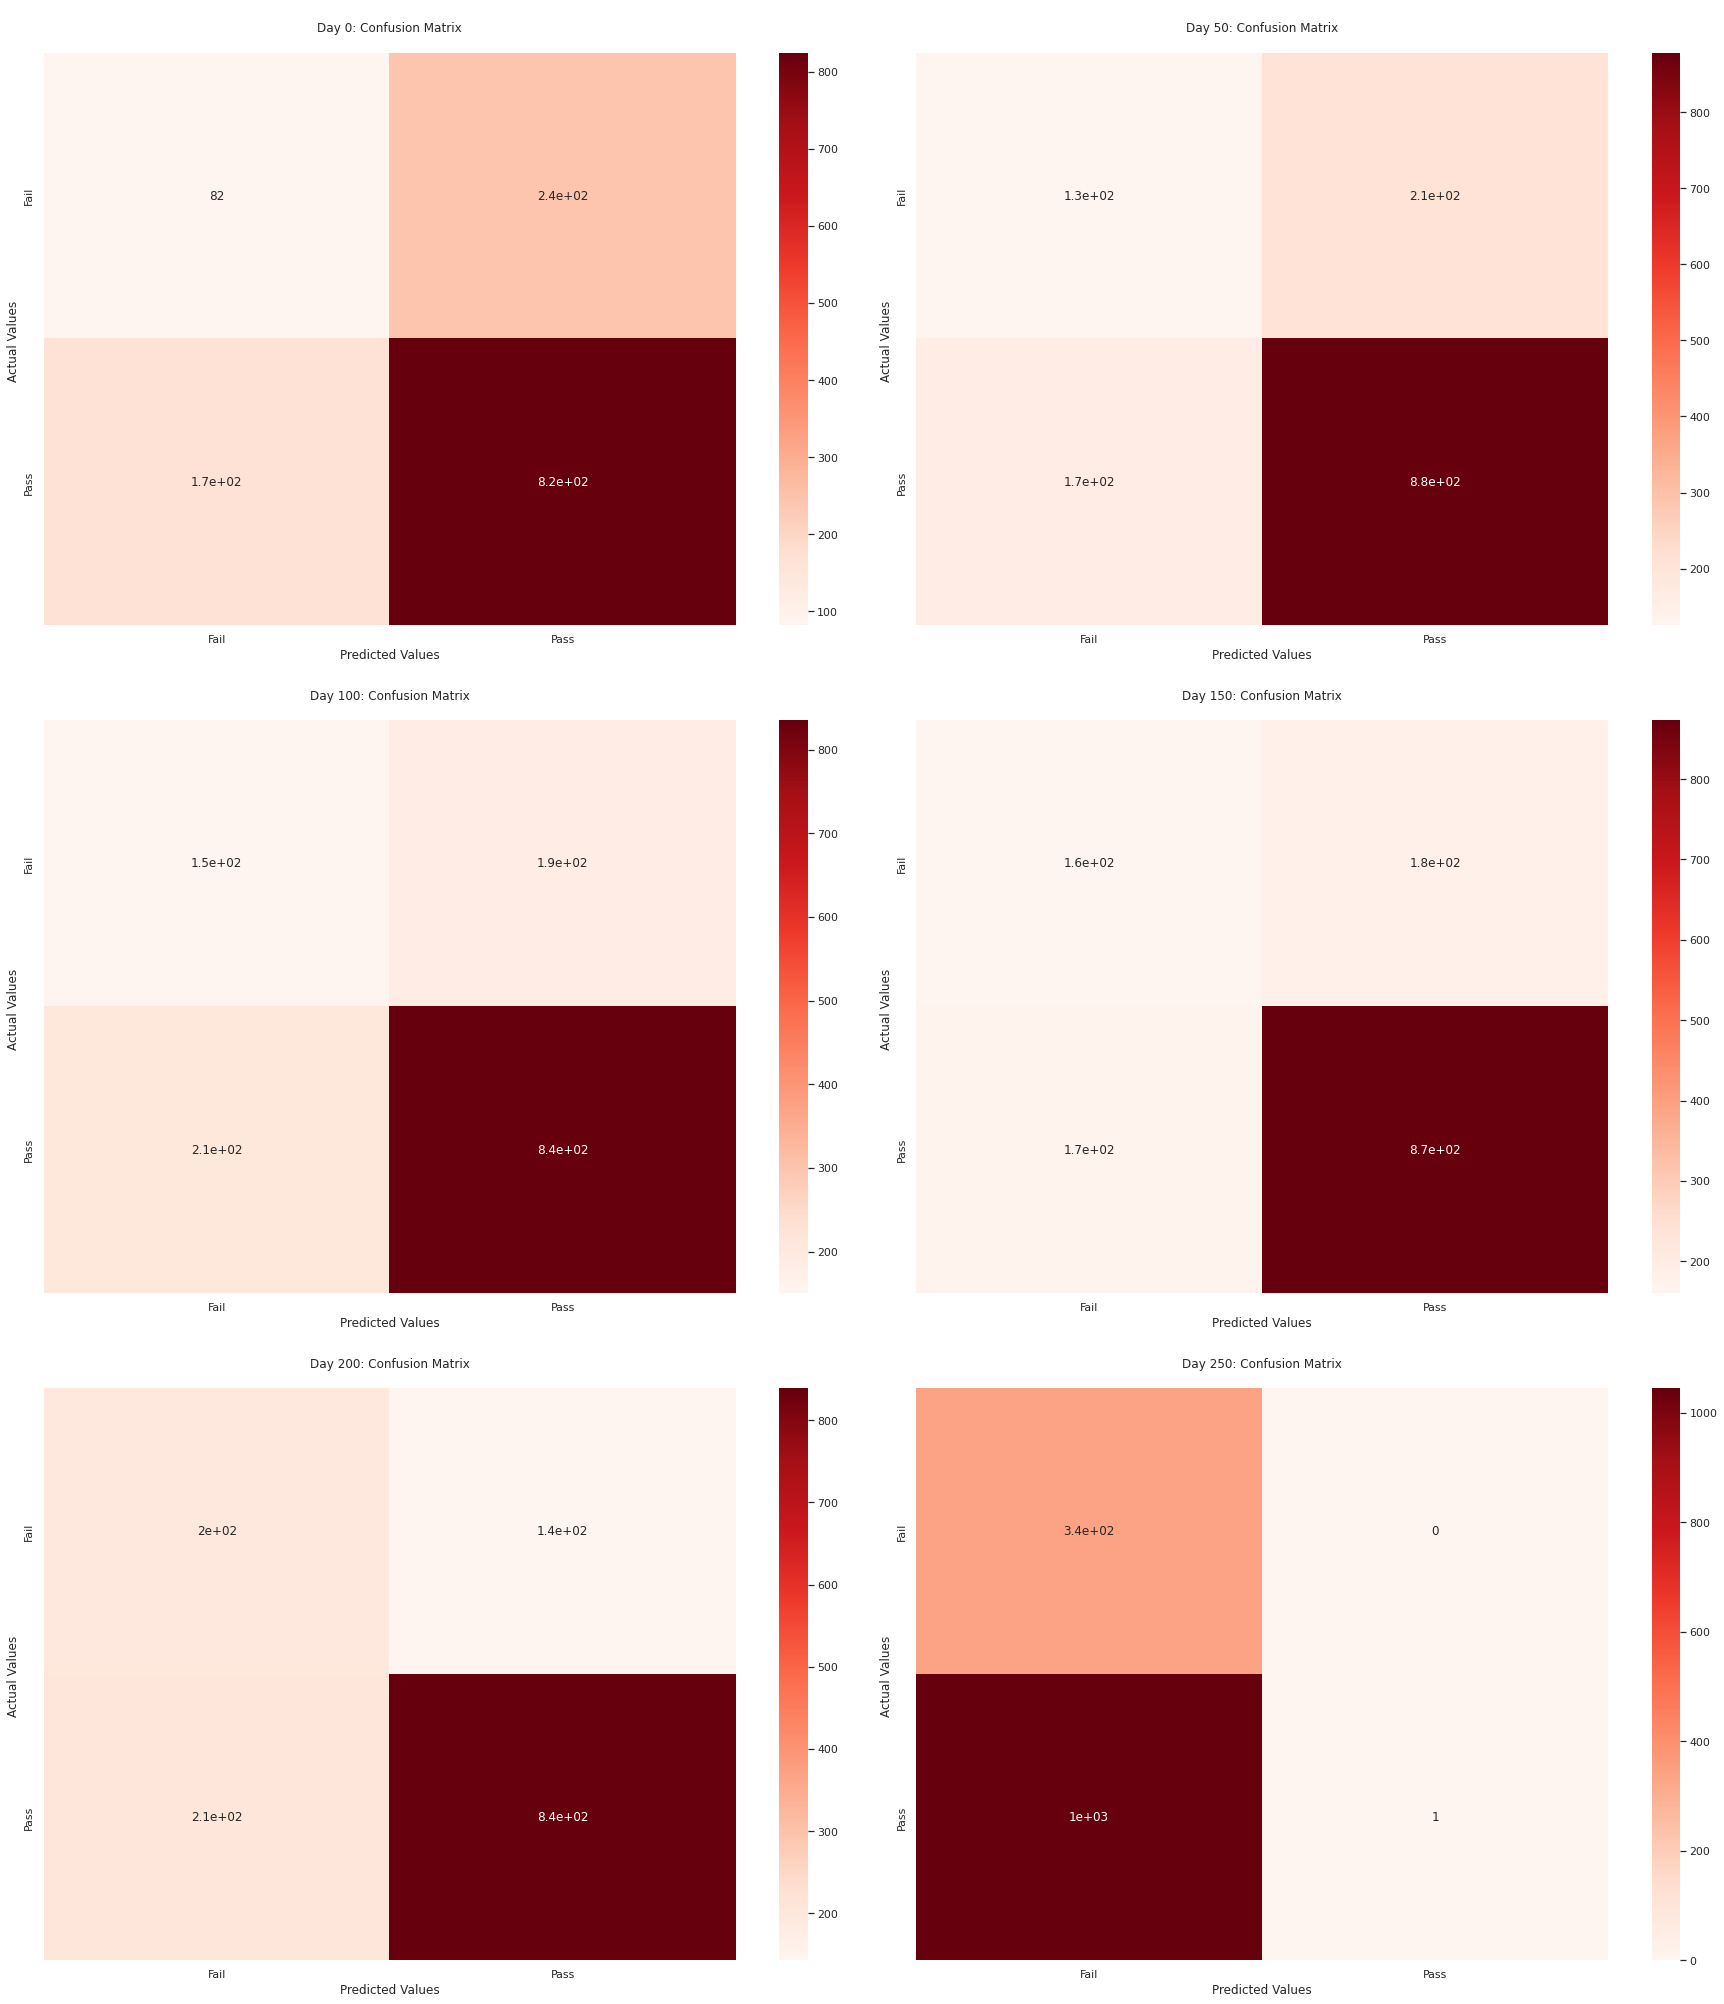

In [ ]:
plot_confusion_matrix(learning_behaviour_results_rf)

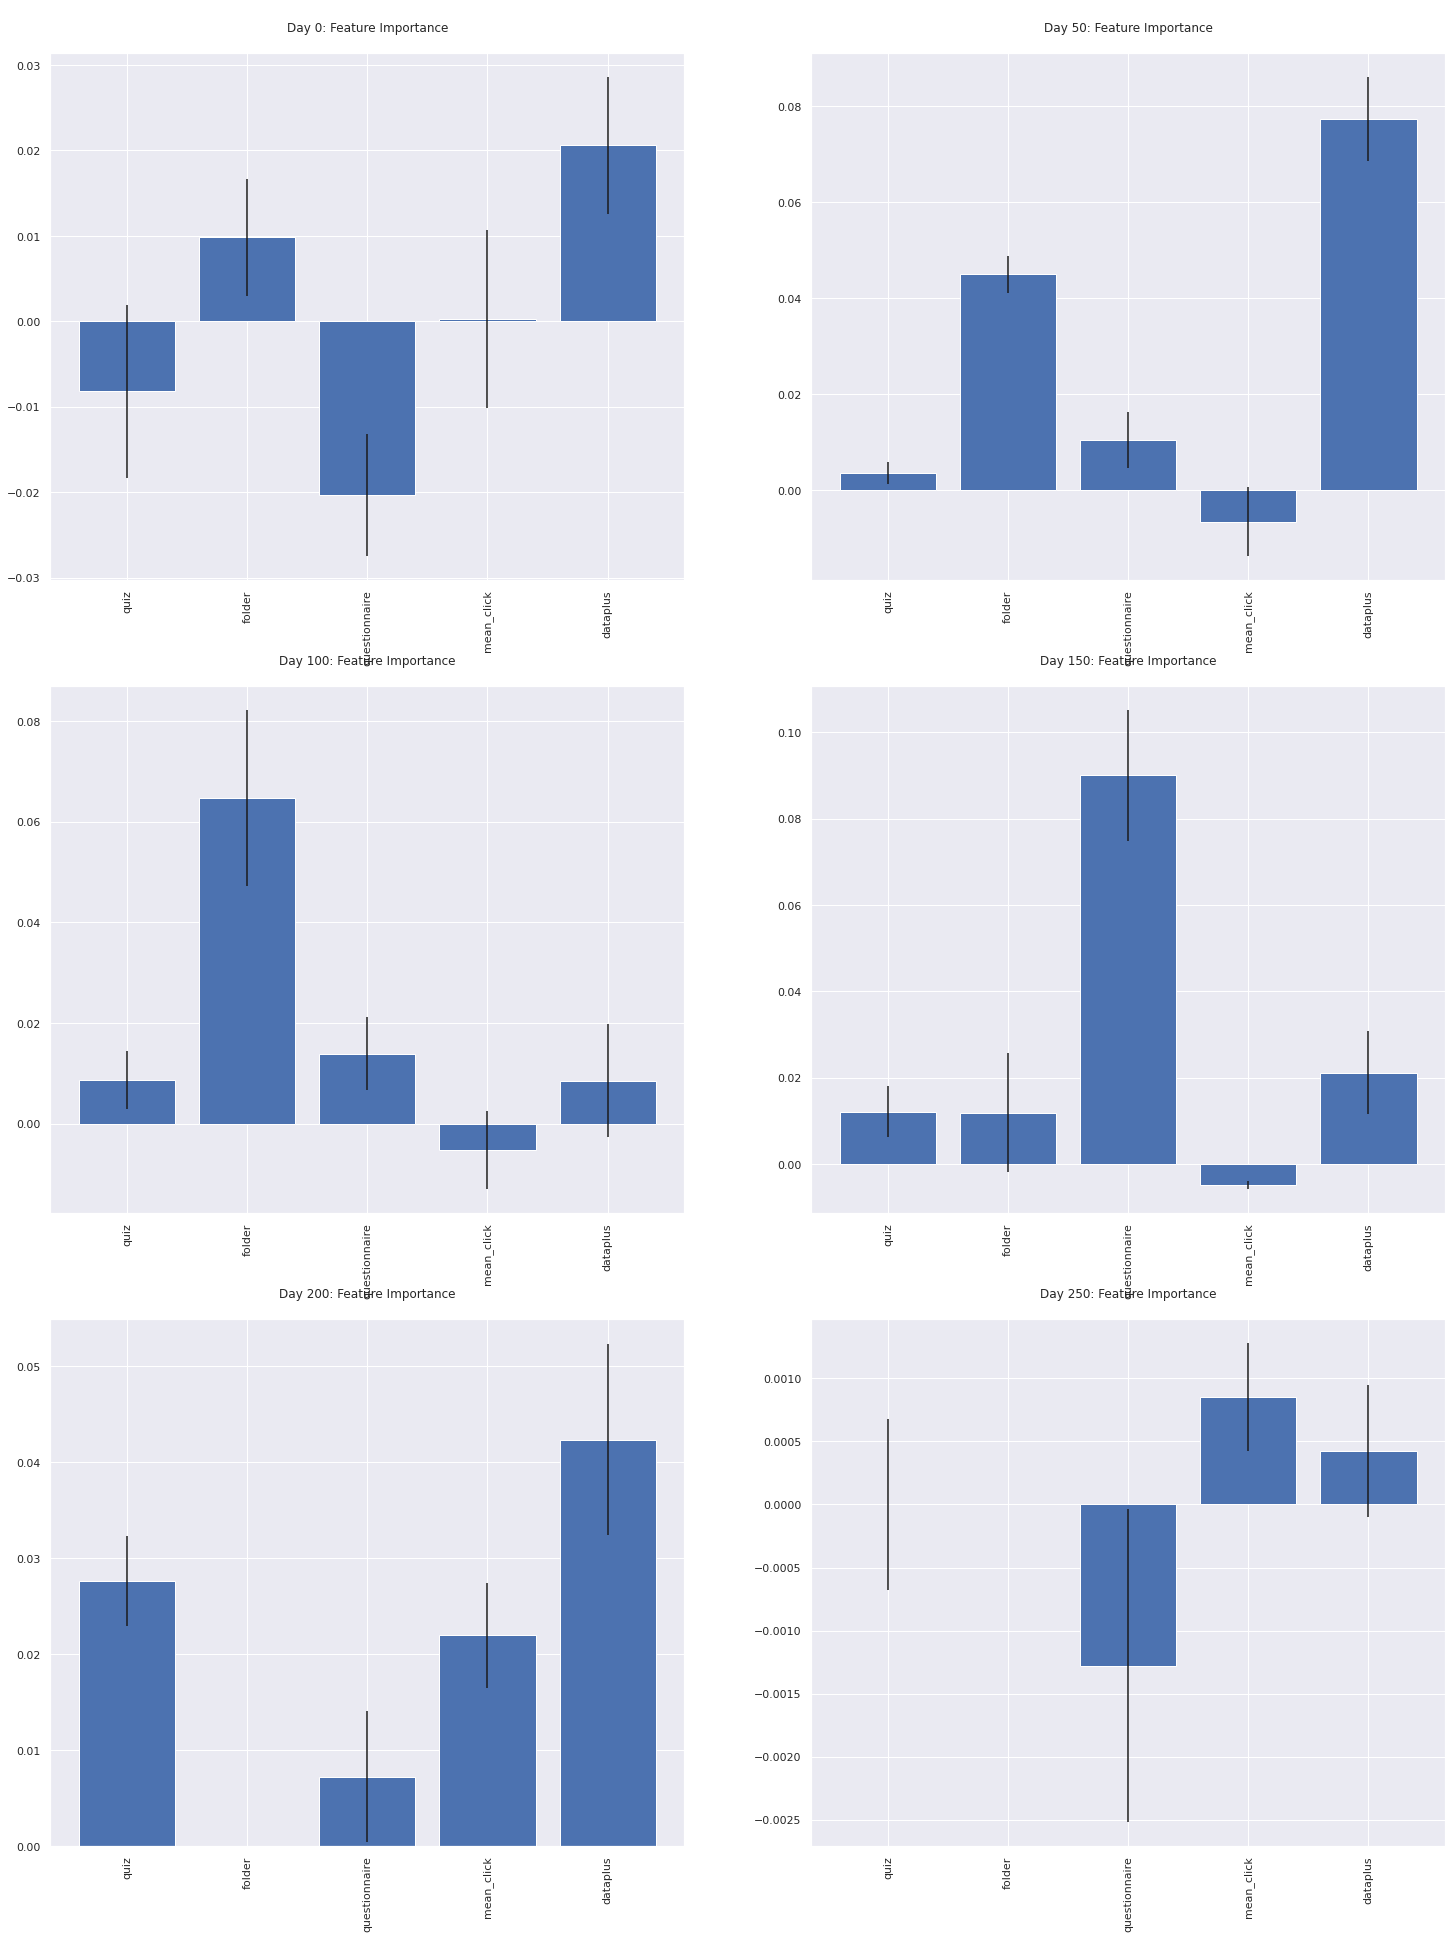

In [ ]:
plot_feature_importance(learning_behaviour_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

learning_behaviour_results_ab = []
learning_behiviour_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_ab.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.520
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.7207890743550834, F1 Score: 0.8229066410009624, Precision: 0.787292817679558, Recall: 0.8618951612903226


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.655
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7541696881798404, F1 Score: 0.8413664014974264, Precision: 0.8225068618481244, Recall: 0.8611111111111112


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.665
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.7384393063583815, 

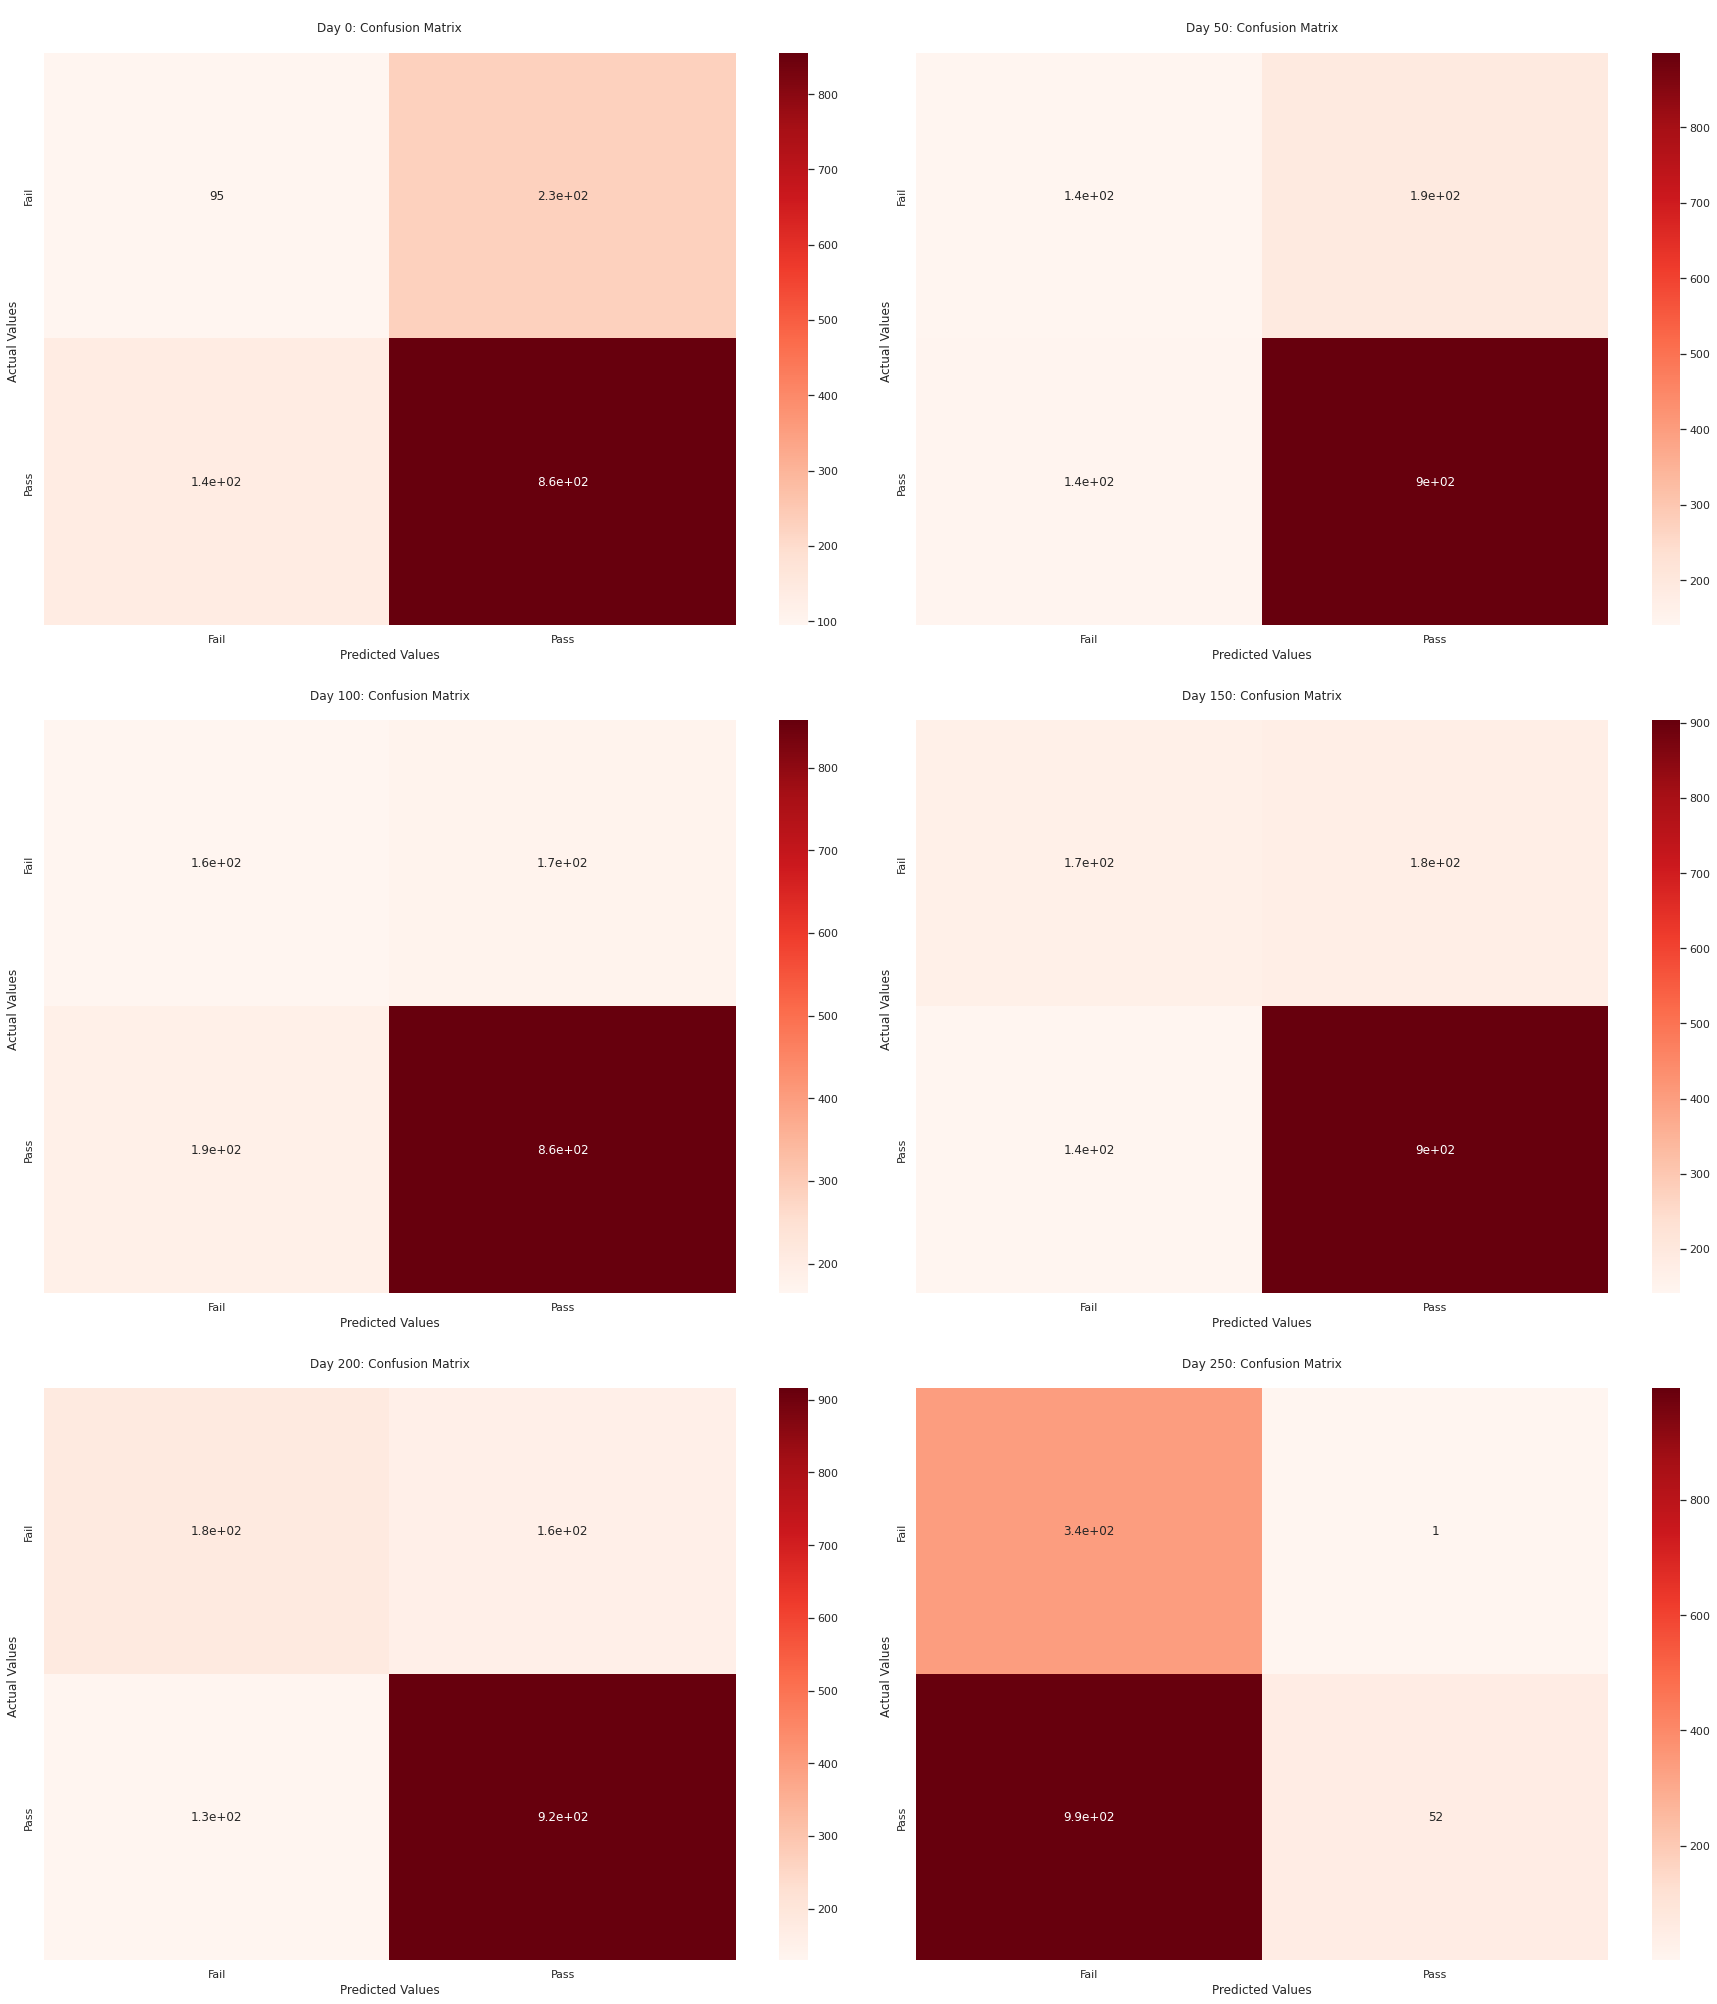

In [ ]:
plot_confusion_matrix(learning_behaviour_results_ab)

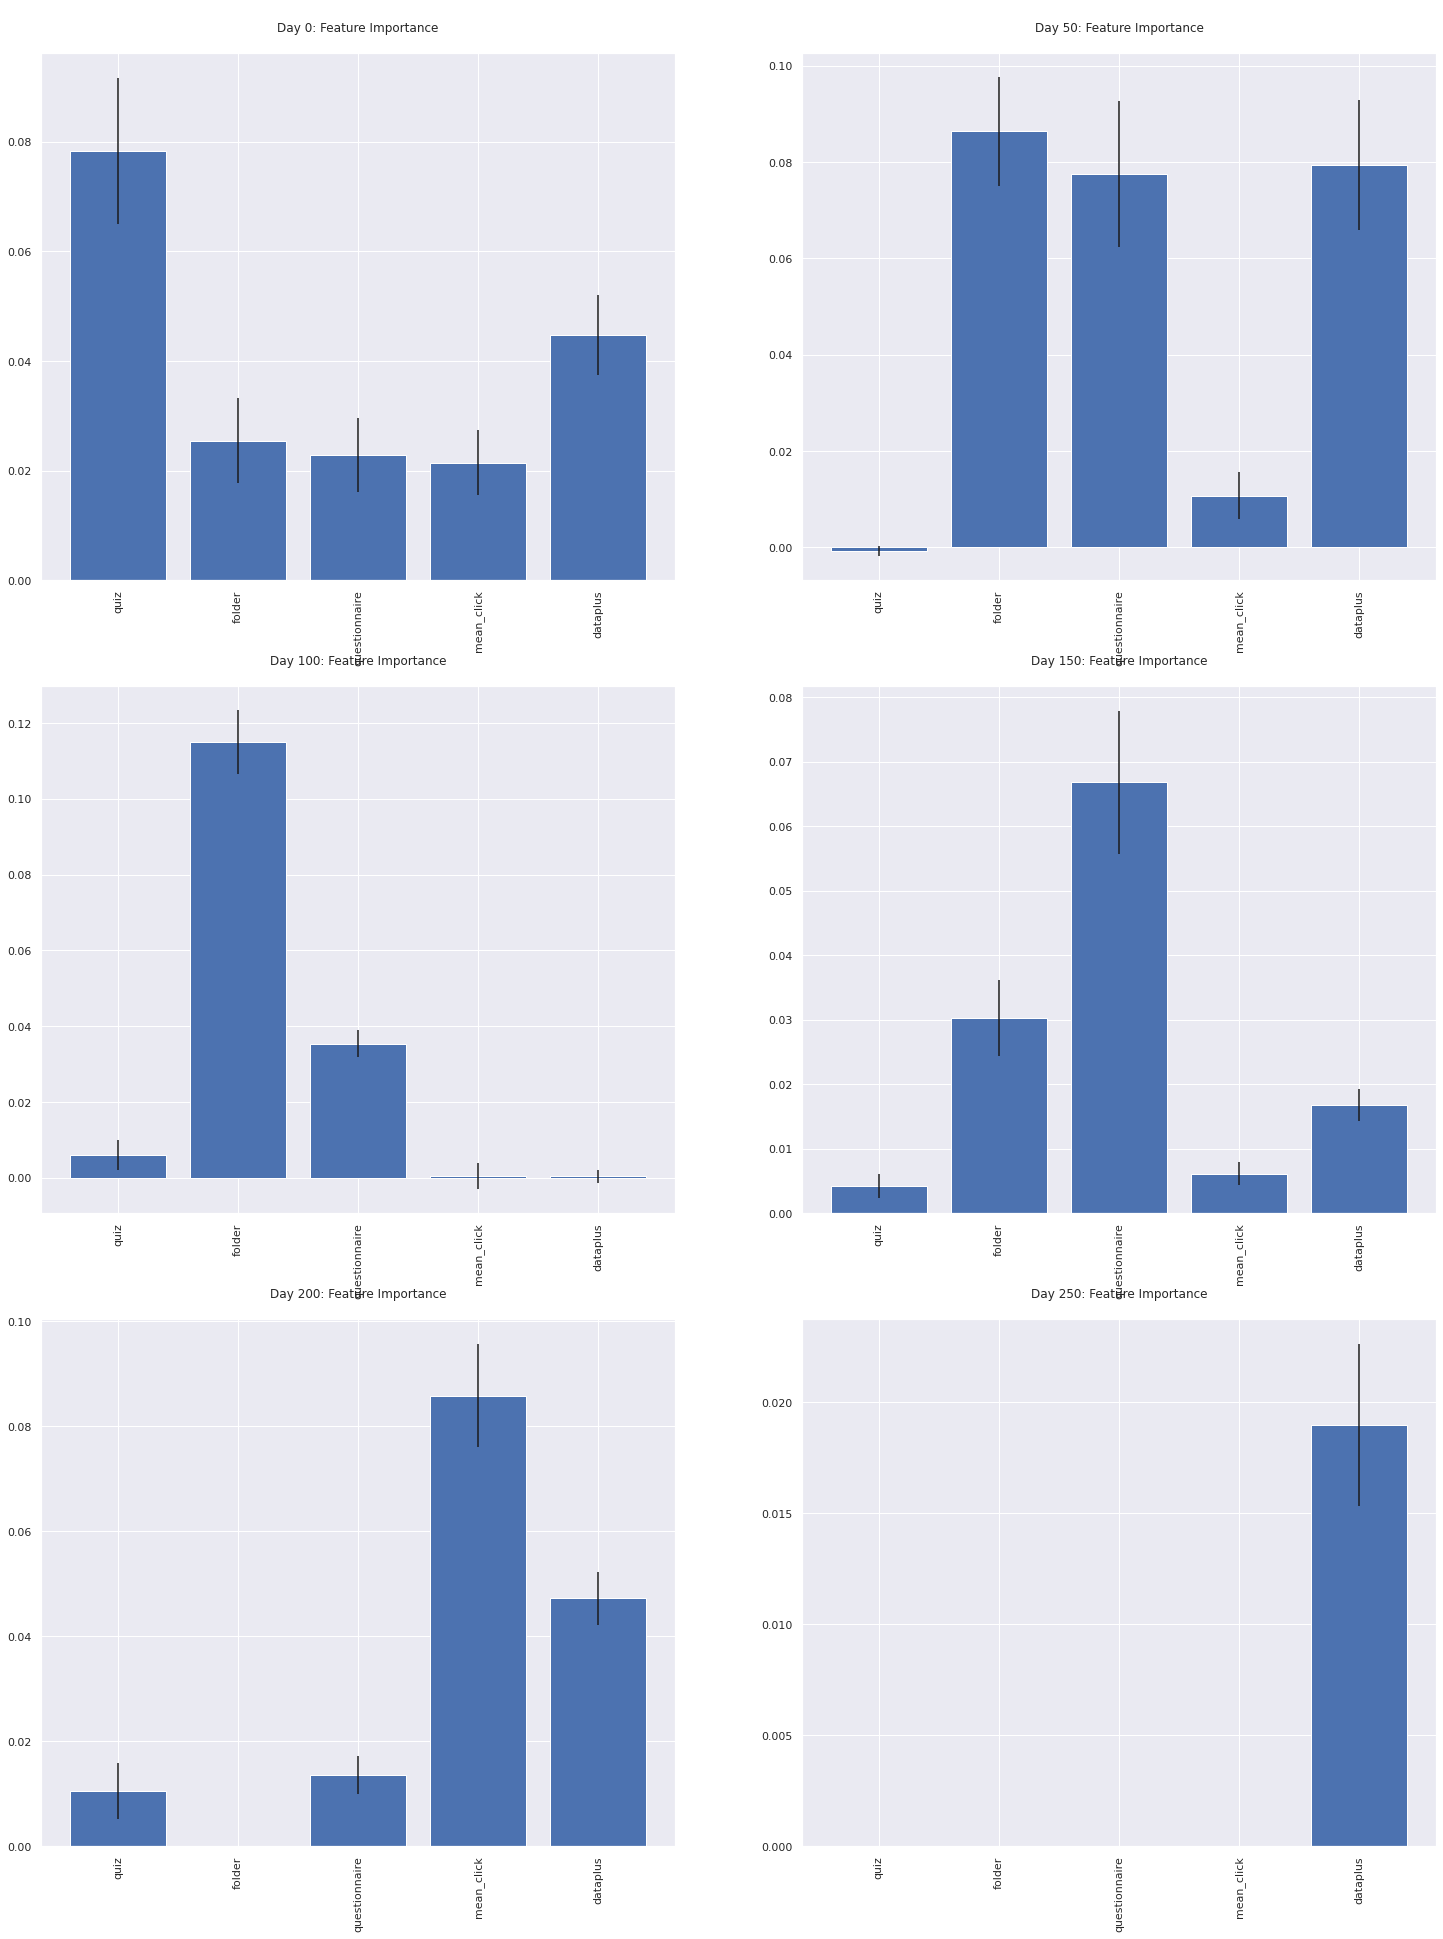

In [ ]:
plot_feature_importance(learning_behiviour_features_ab)

##### Plot results overview

In [ ]:
learning_behaviour_classifier_results = [learning_behaviour_results_du, learning_behaviour_results_nb, learning_behaviour_results_lr, learning_behaviour_results_lrw, learning_behaviour_results_rf, learning_behaviour_results_ab]
learning_behaviour_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

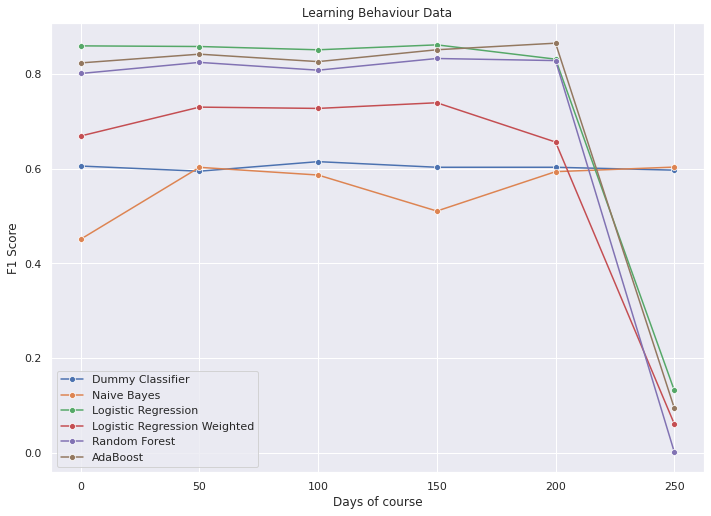

In [ ]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

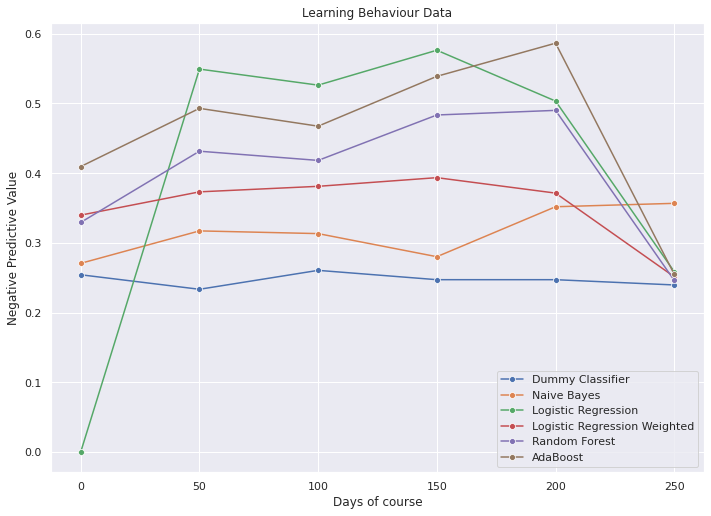

In [ ]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

#### Performance data

##### Prepare data for prediction

In [ ]:
performance_df = {}
for i in list(df.keys())[1:]:
  performance_df[i] = split_dataframe_by_data_type(df[i], ['performance'], include_final_result=True)

In [ ]:
performance_df[50]

code_presentation  id_student  score  weighted_score  final_result
0                2013B       33915   90.0          22.680             1
1                2013B       35544   86.0          21.672             1
2                2013B       35860   84.0          21.168             1
3                2013B       42668   74.0          18.648             1
4                2013B       43273   81.0          20.412             1
...                ...         ...    ...             ...           ...
4797             2014J     2681198   66.0           8.316             1
4798             2014J     2682682   96.0          12.096             1
4799             2014J     2683857   72.0           9.072             1
4800             2014J     2693932   90.0          11.340             1
4801             2014J     2697921   94.0          11.844             1

[4802 rows x 5 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(performance_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')


In [ ]:
X_train[50]

score  weighted_score
1072  0.897959        0.448980
1073  0.948980        0.948980
1074  0.775510        0.775510
1075  0.938776        0.938776
1076  0.765306        0.765306
...        ...             ...
2513  0.744898        0.744898
2514  0.673469        0.673469
2515  0.948980        0.948980
2516  0.632653        0.632653
2517  0.806122        0.806122

[1446 rows x 2 columns]

###### Undersampling

In [ ]:
Y_train[50].value_counts()

1    1028
0     418
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in list(df.keys())[1:]:

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 50
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 100
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 150
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 200
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 250
Original dataset shape: Counter({1: 1028, 0: 425})
Resample dataset shape Counter({0: 425, 1: 425})


##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

performance_results_du = []
performance_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_du.append([acc, f1, prec, recall, conf])
  performance_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5014430014430015, F1 Score: 0.6026451983898793, Precision: 0.7550432276657061, Recall: 0.5014354066985646


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Be

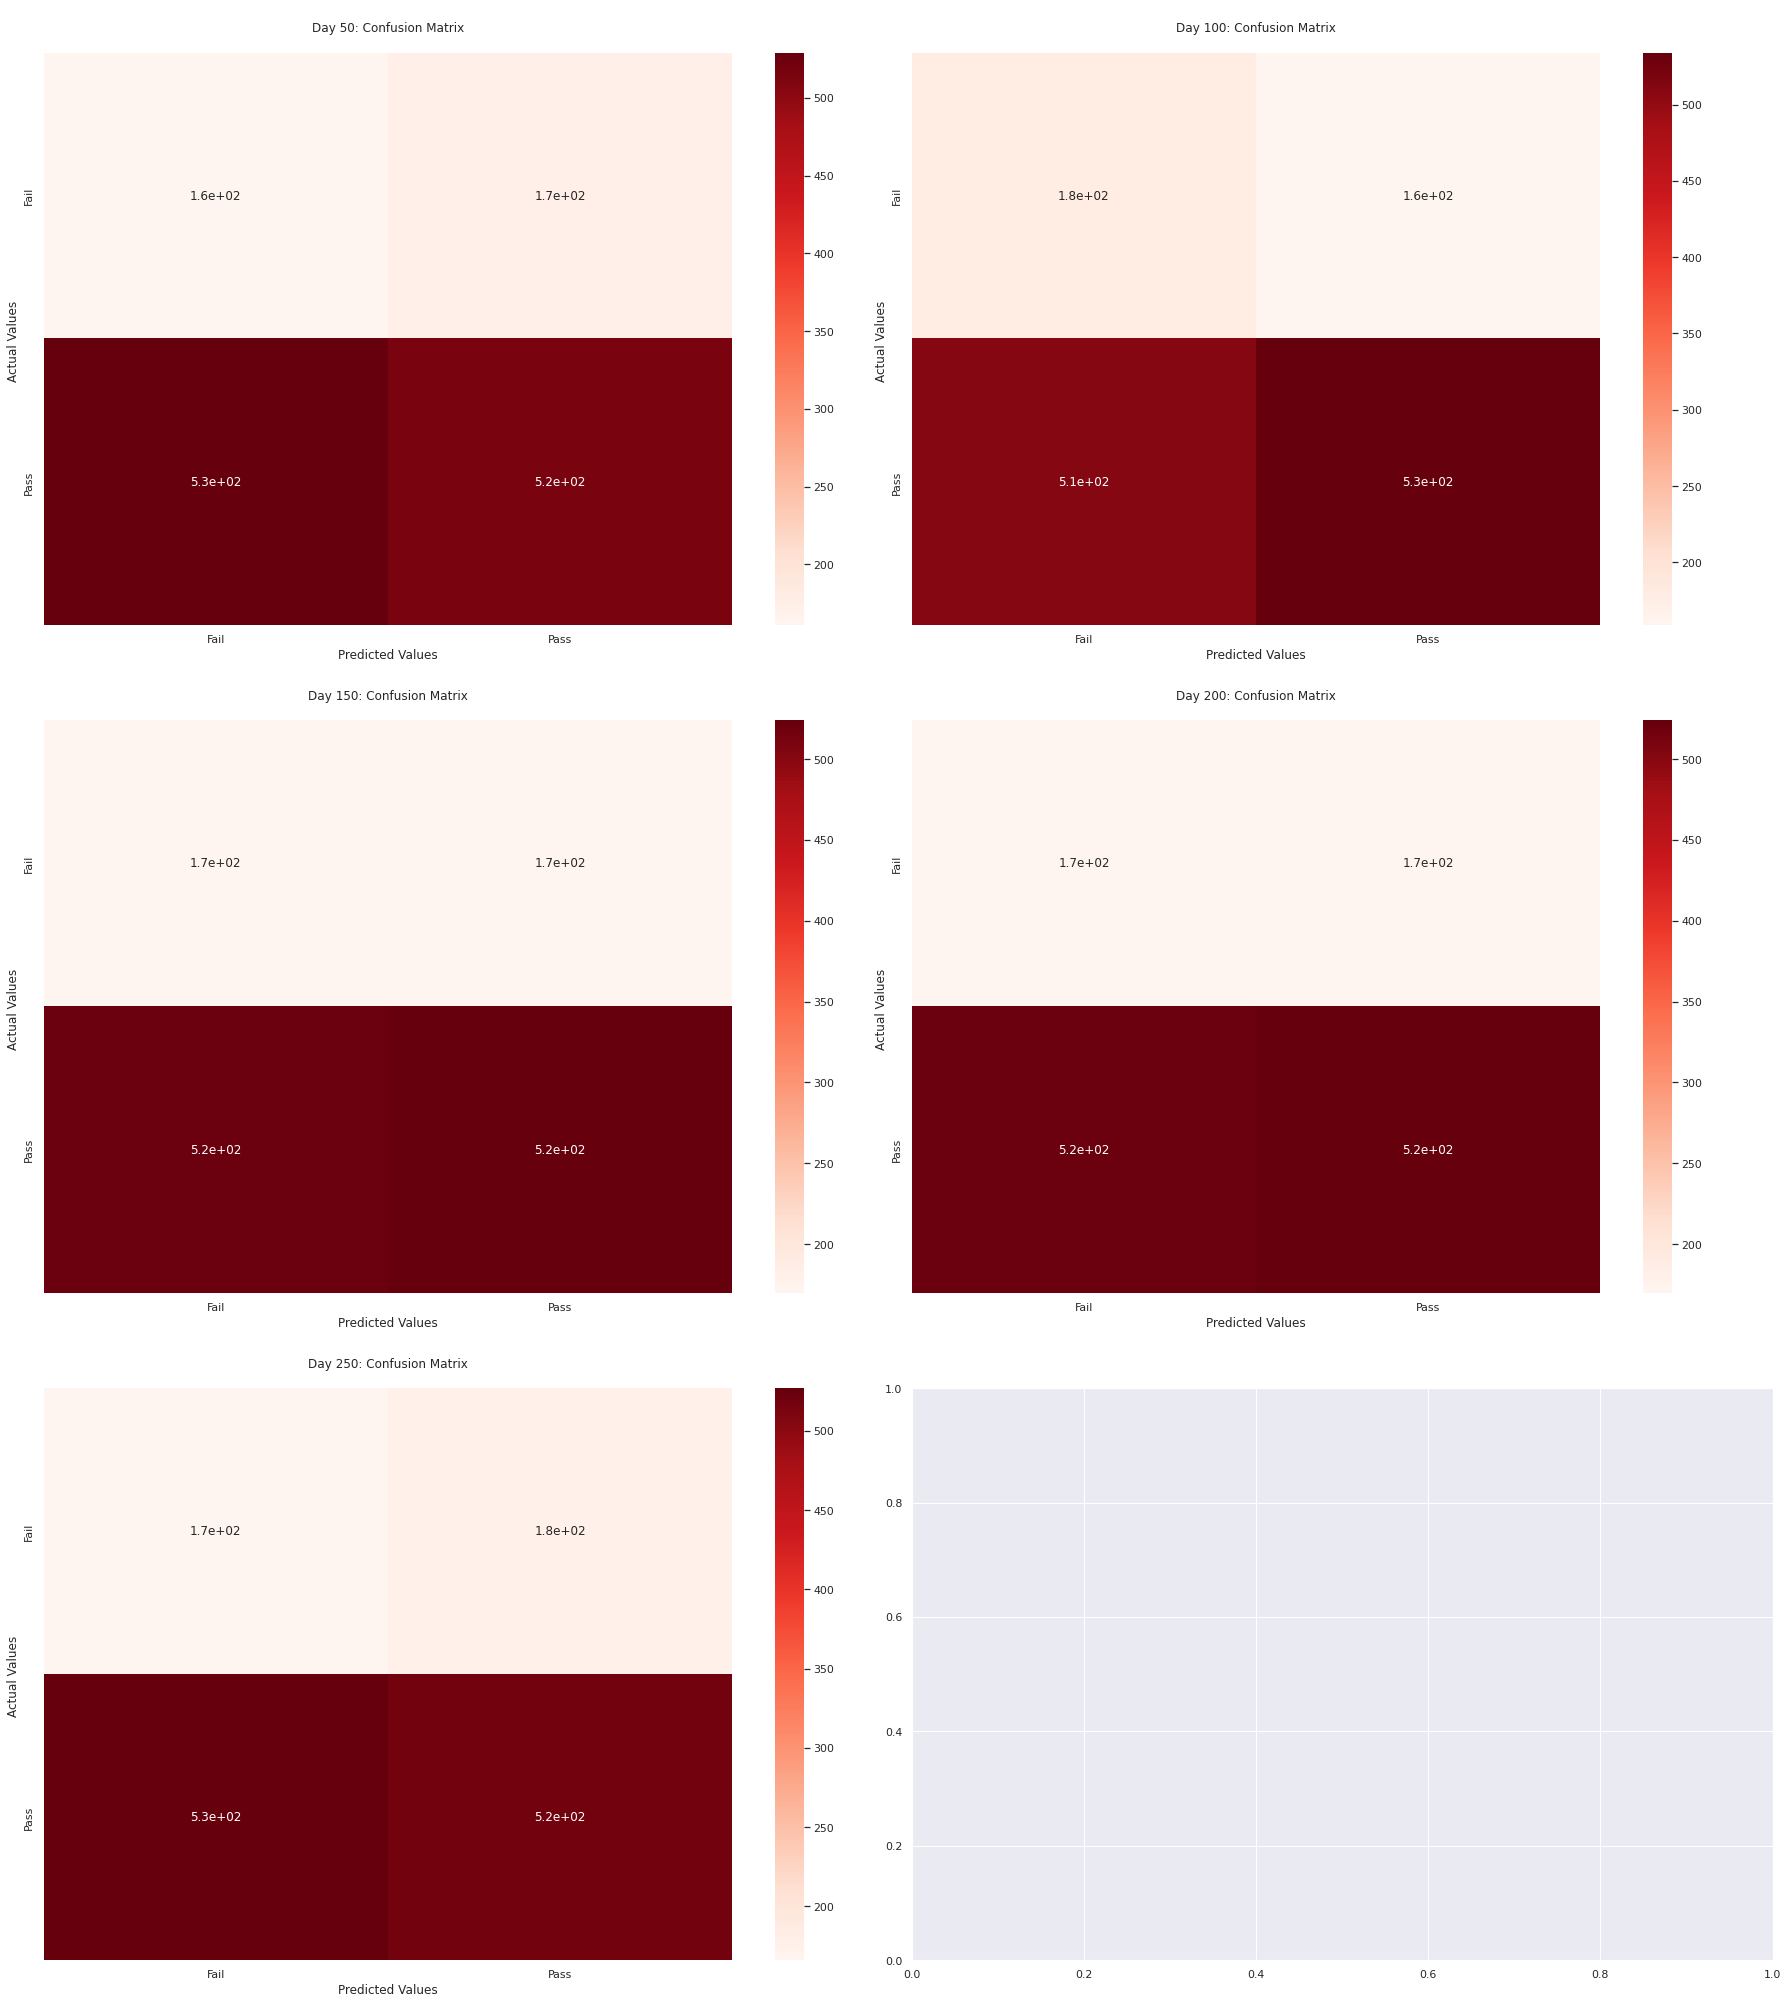

In [ ]:
plot_confusion_matrix(performance_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

performance_results_nb = []
performance_features_nb = []

performance_predict_proba_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])

  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_nb.append([acc, f1, prec, recall, conf])
  performance_features_nb.append([tuned_model, X_test[i], Y_test[i]])

  performance_predict_proba_nb.append(predictions_proba)

  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.629
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.805
Best parameters set:
Accuracy: 0.8569364161849711, F1 Score: 0.9129287598944591, Precision: 0.8445890968266884, Recall: 0.9933014354066986


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.843
Best parameters set:
Accuracy: 0.886002886002886, F1 Score: 0.928635953026197, Precision: 0.8793840889649273, Recall: 0.9837320574162679


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.852
Best parameters set:
Accuracy: 0.8946608946608947,

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.860
Best parameters set:
Accuracy: 0.8889689978370584, F1 Score: 0.9298085688240657, Precision: 0.8885017421602788, Recall: 0.9751434034416826




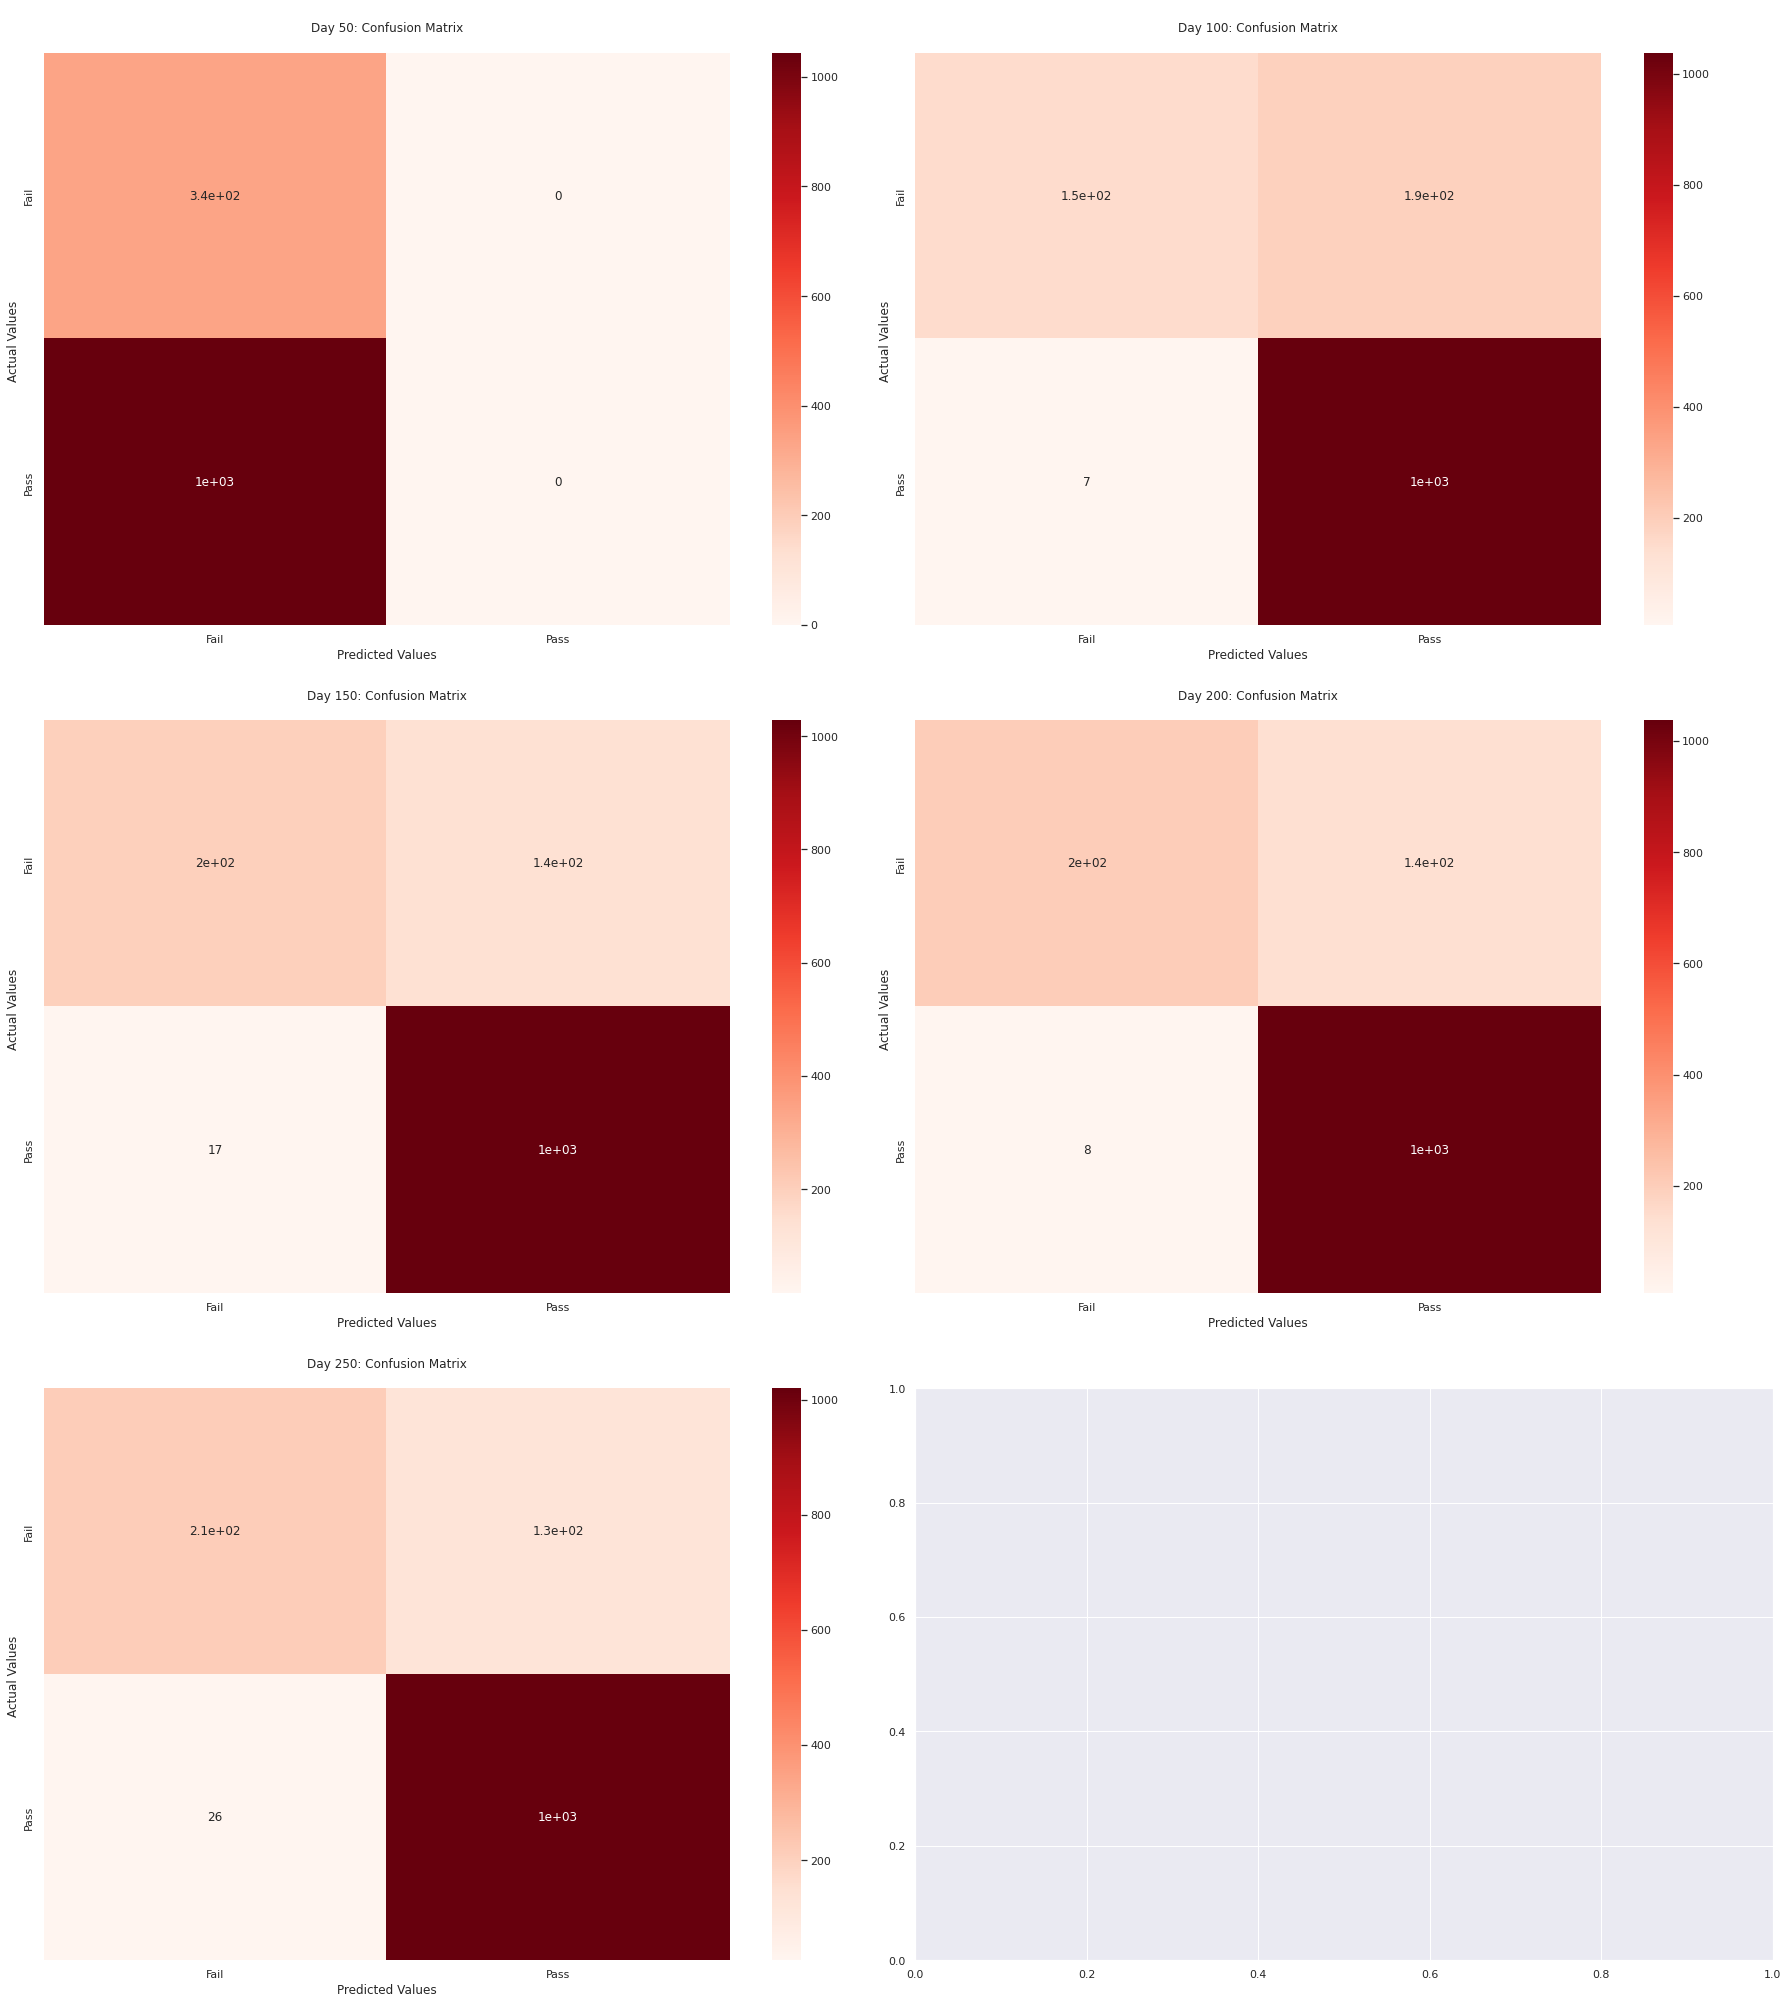

In [ ]:
plot_confusion_matrix(performance_results_nb)

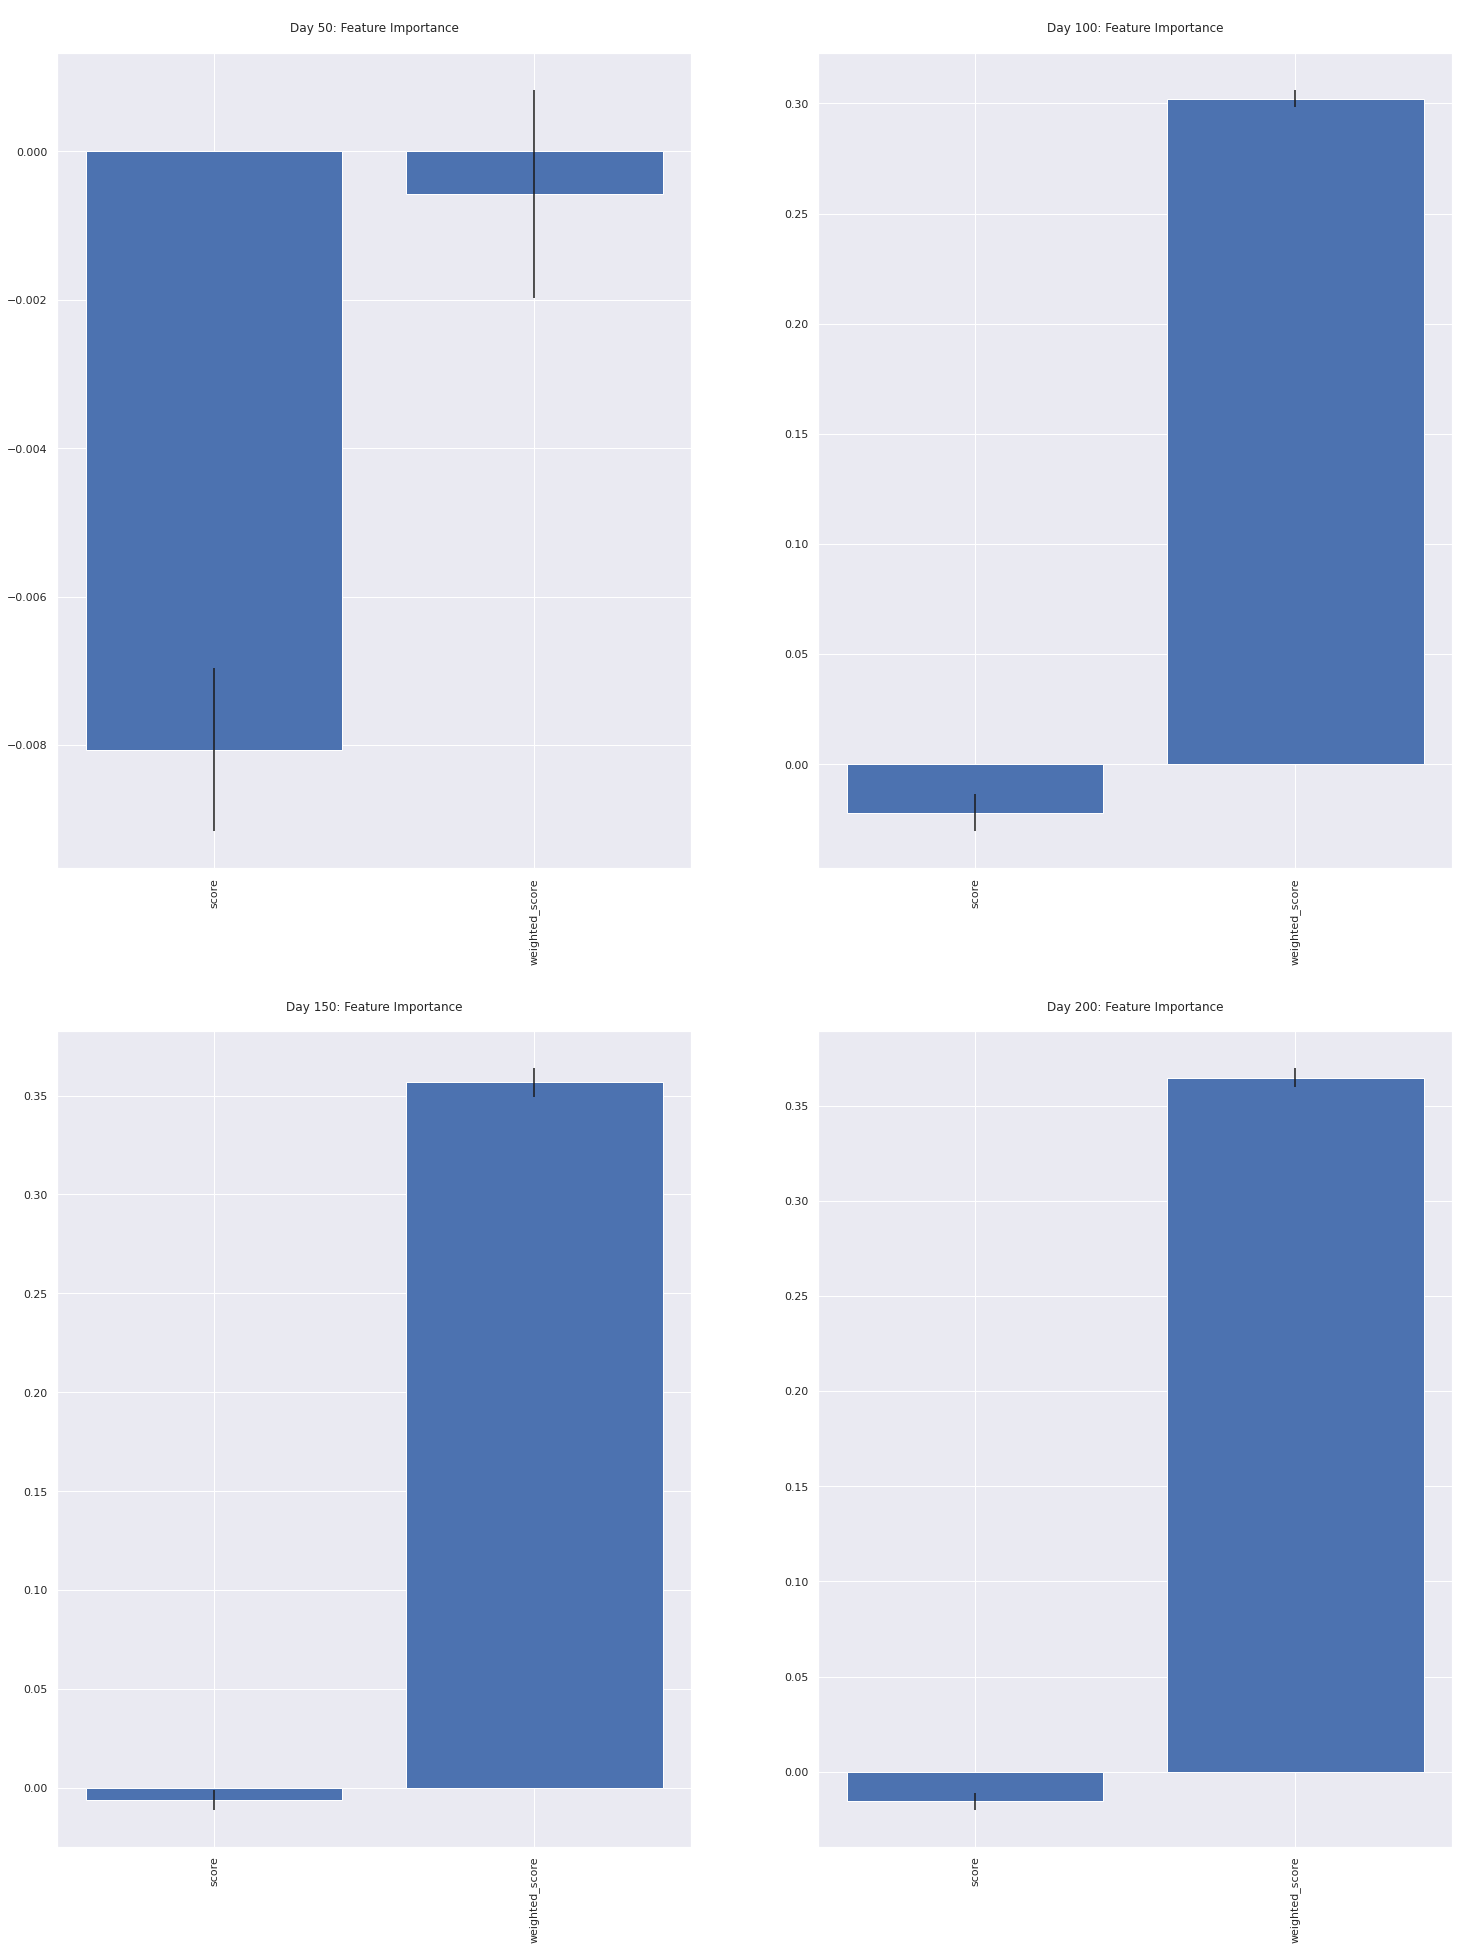

In [ ]:
plot_feature_importance(performance_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

performance_results_lr = []
performance_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lr.append([acc, f1, prec, recall, conf])
  performance_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.709
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.853
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8663294797687862, F1 Score: 0.9162516976007243, Precision: 0.8694158075601375, Recall: 0.968421052631579


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.878
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.8845598845598845, F1 Score: 0.9269406392694063, Precision: 0.8864628820960698, Recall: 0.9712918660287081


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.895
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.9018759018759018, F1 Score: 0.9363891487371375, Precision: 0.9158279963403476, Recall: 0.9578947368421052


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling

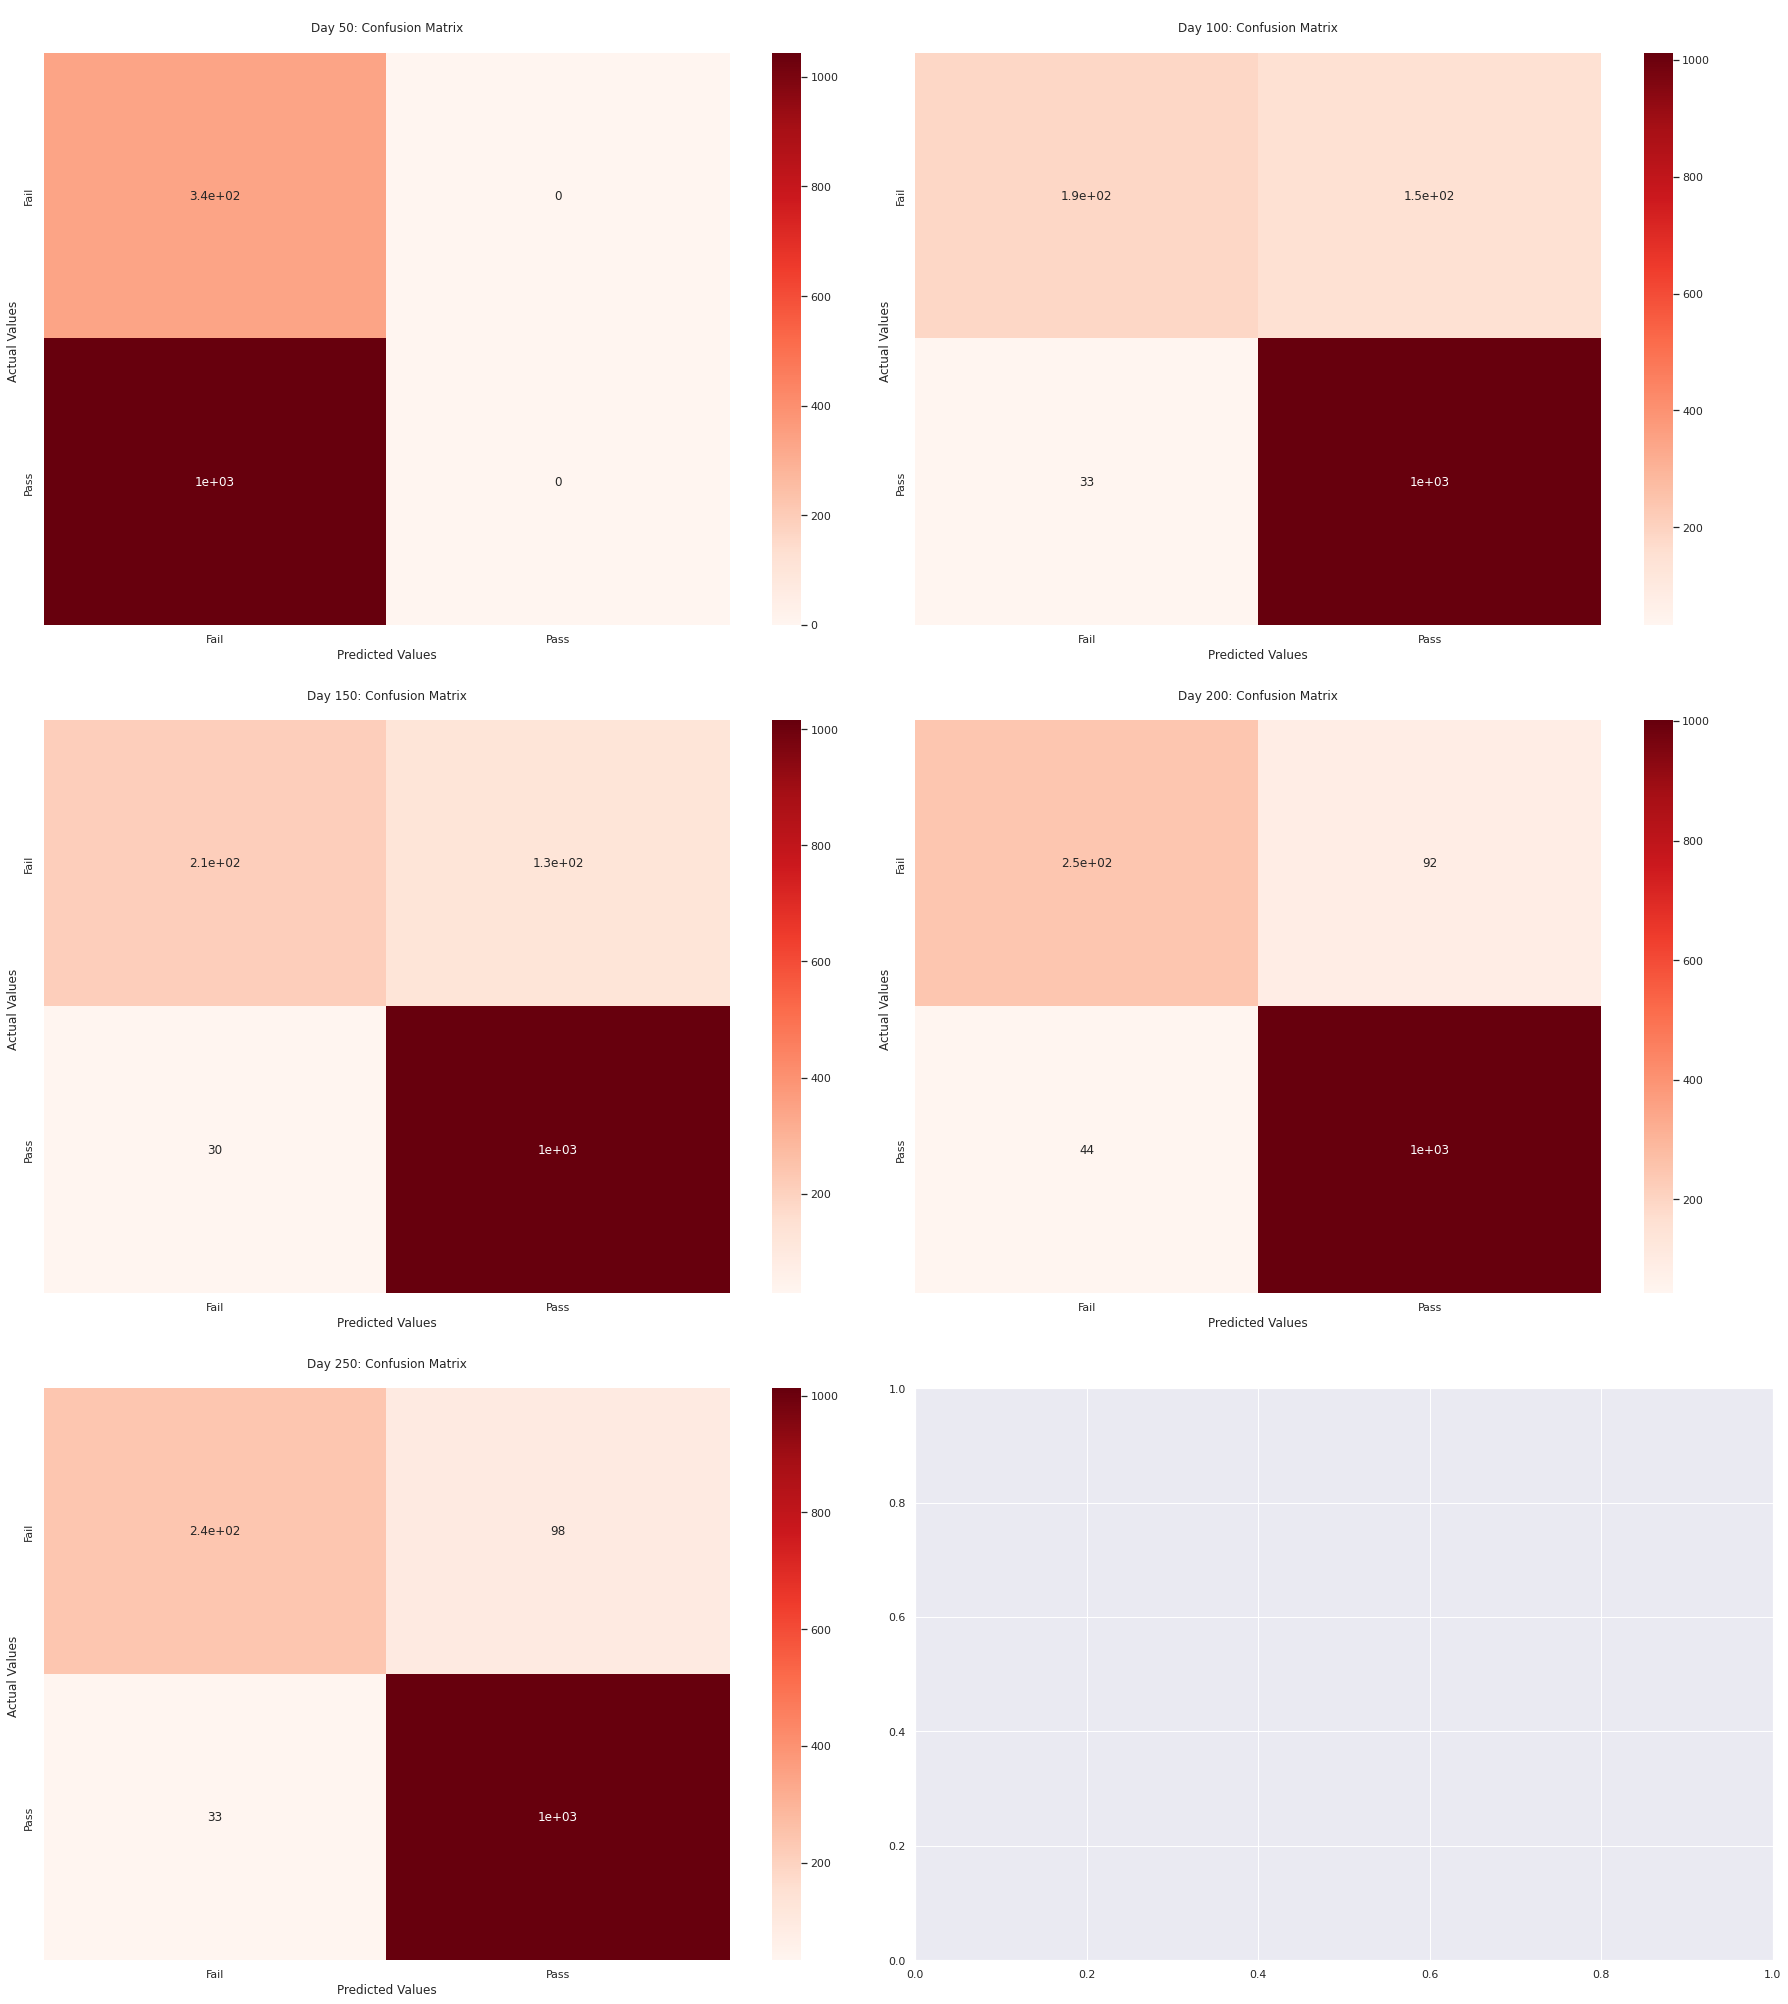

In [ ]:
plot_confusion_matrix(performance_results_lr)

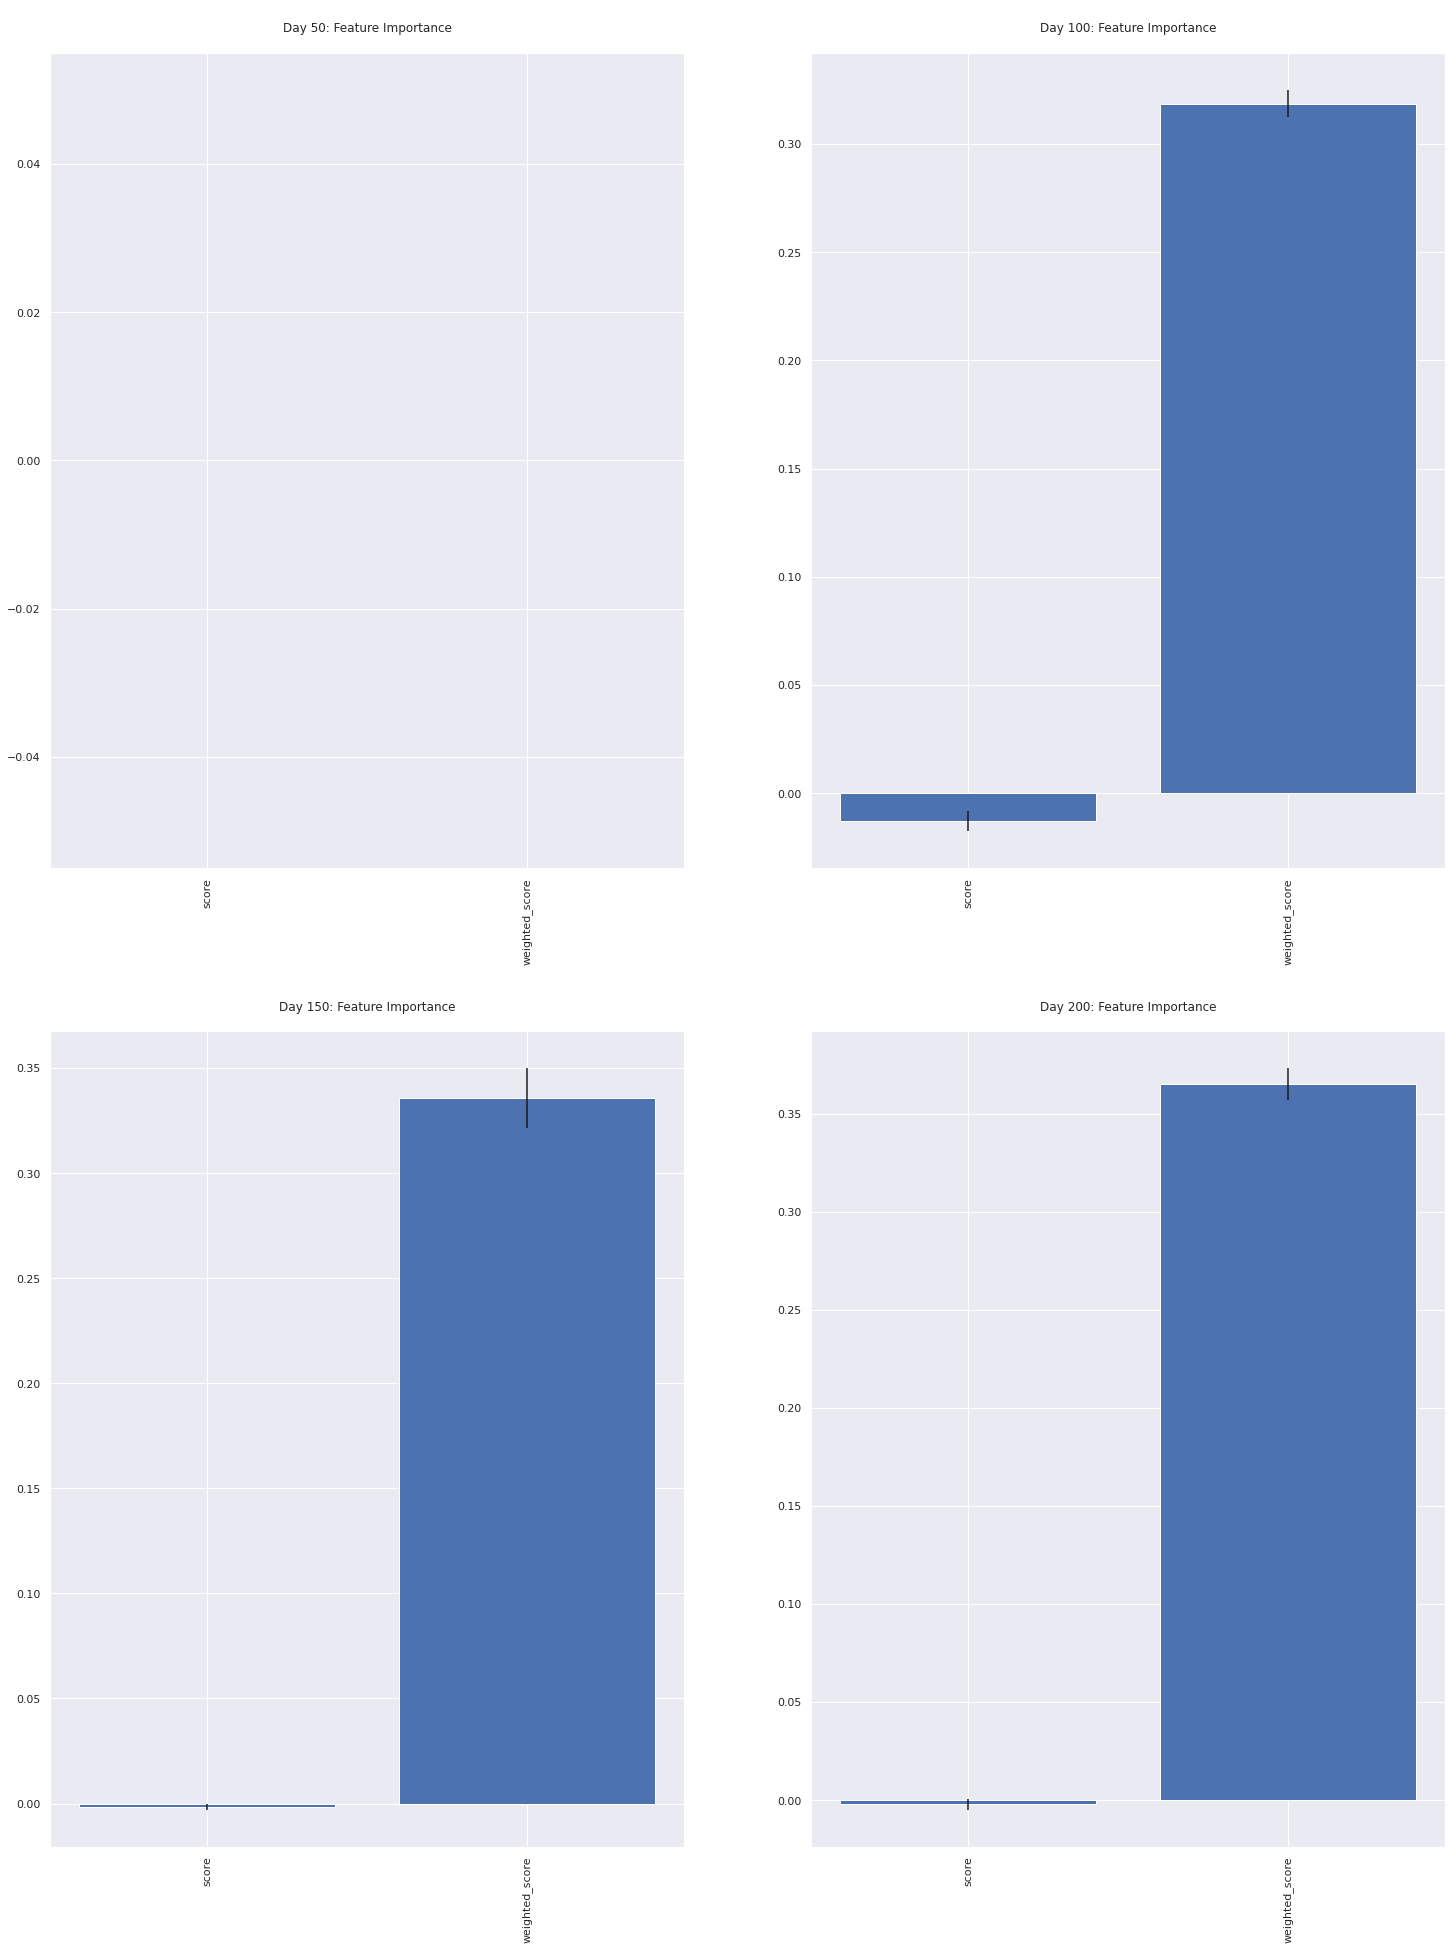

In [ ]:
plot_feature_importance(performance_features_lr)

##### WeightedLogisticRegression

In [ ]:
performance_results_lrw = []
performance_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
  
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lrw.append([acc, f1, prec, recall, conf])
  performance_features_lrw.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.732
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.835
Best parameters set:
Accuracy: 0.8677745664739884, F1 Score: 0.9142857142857143, Precision: 0.8954128440366973, Recall: 0.9339712918660287


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.870
Best parameters set:
Accuracy: 0.8852813852813853, F1 Score: 0.9245372567631704, Precision: 0.9171374764595104, Recall: 0.9320574162679426


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.868
Best parameters set:
Accuracy: 0.8946608946608947, F1 Score: 0.9293320425943854, Precision: 0.940254652301665, Recall: 0.9186602870813397


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.877
Best parameters set:
Accuracy: 0.8940158615717375, F1 Score: 0.9289511841469309, Precision: 0.9393939393939394, Recall: 0.9187380497131931




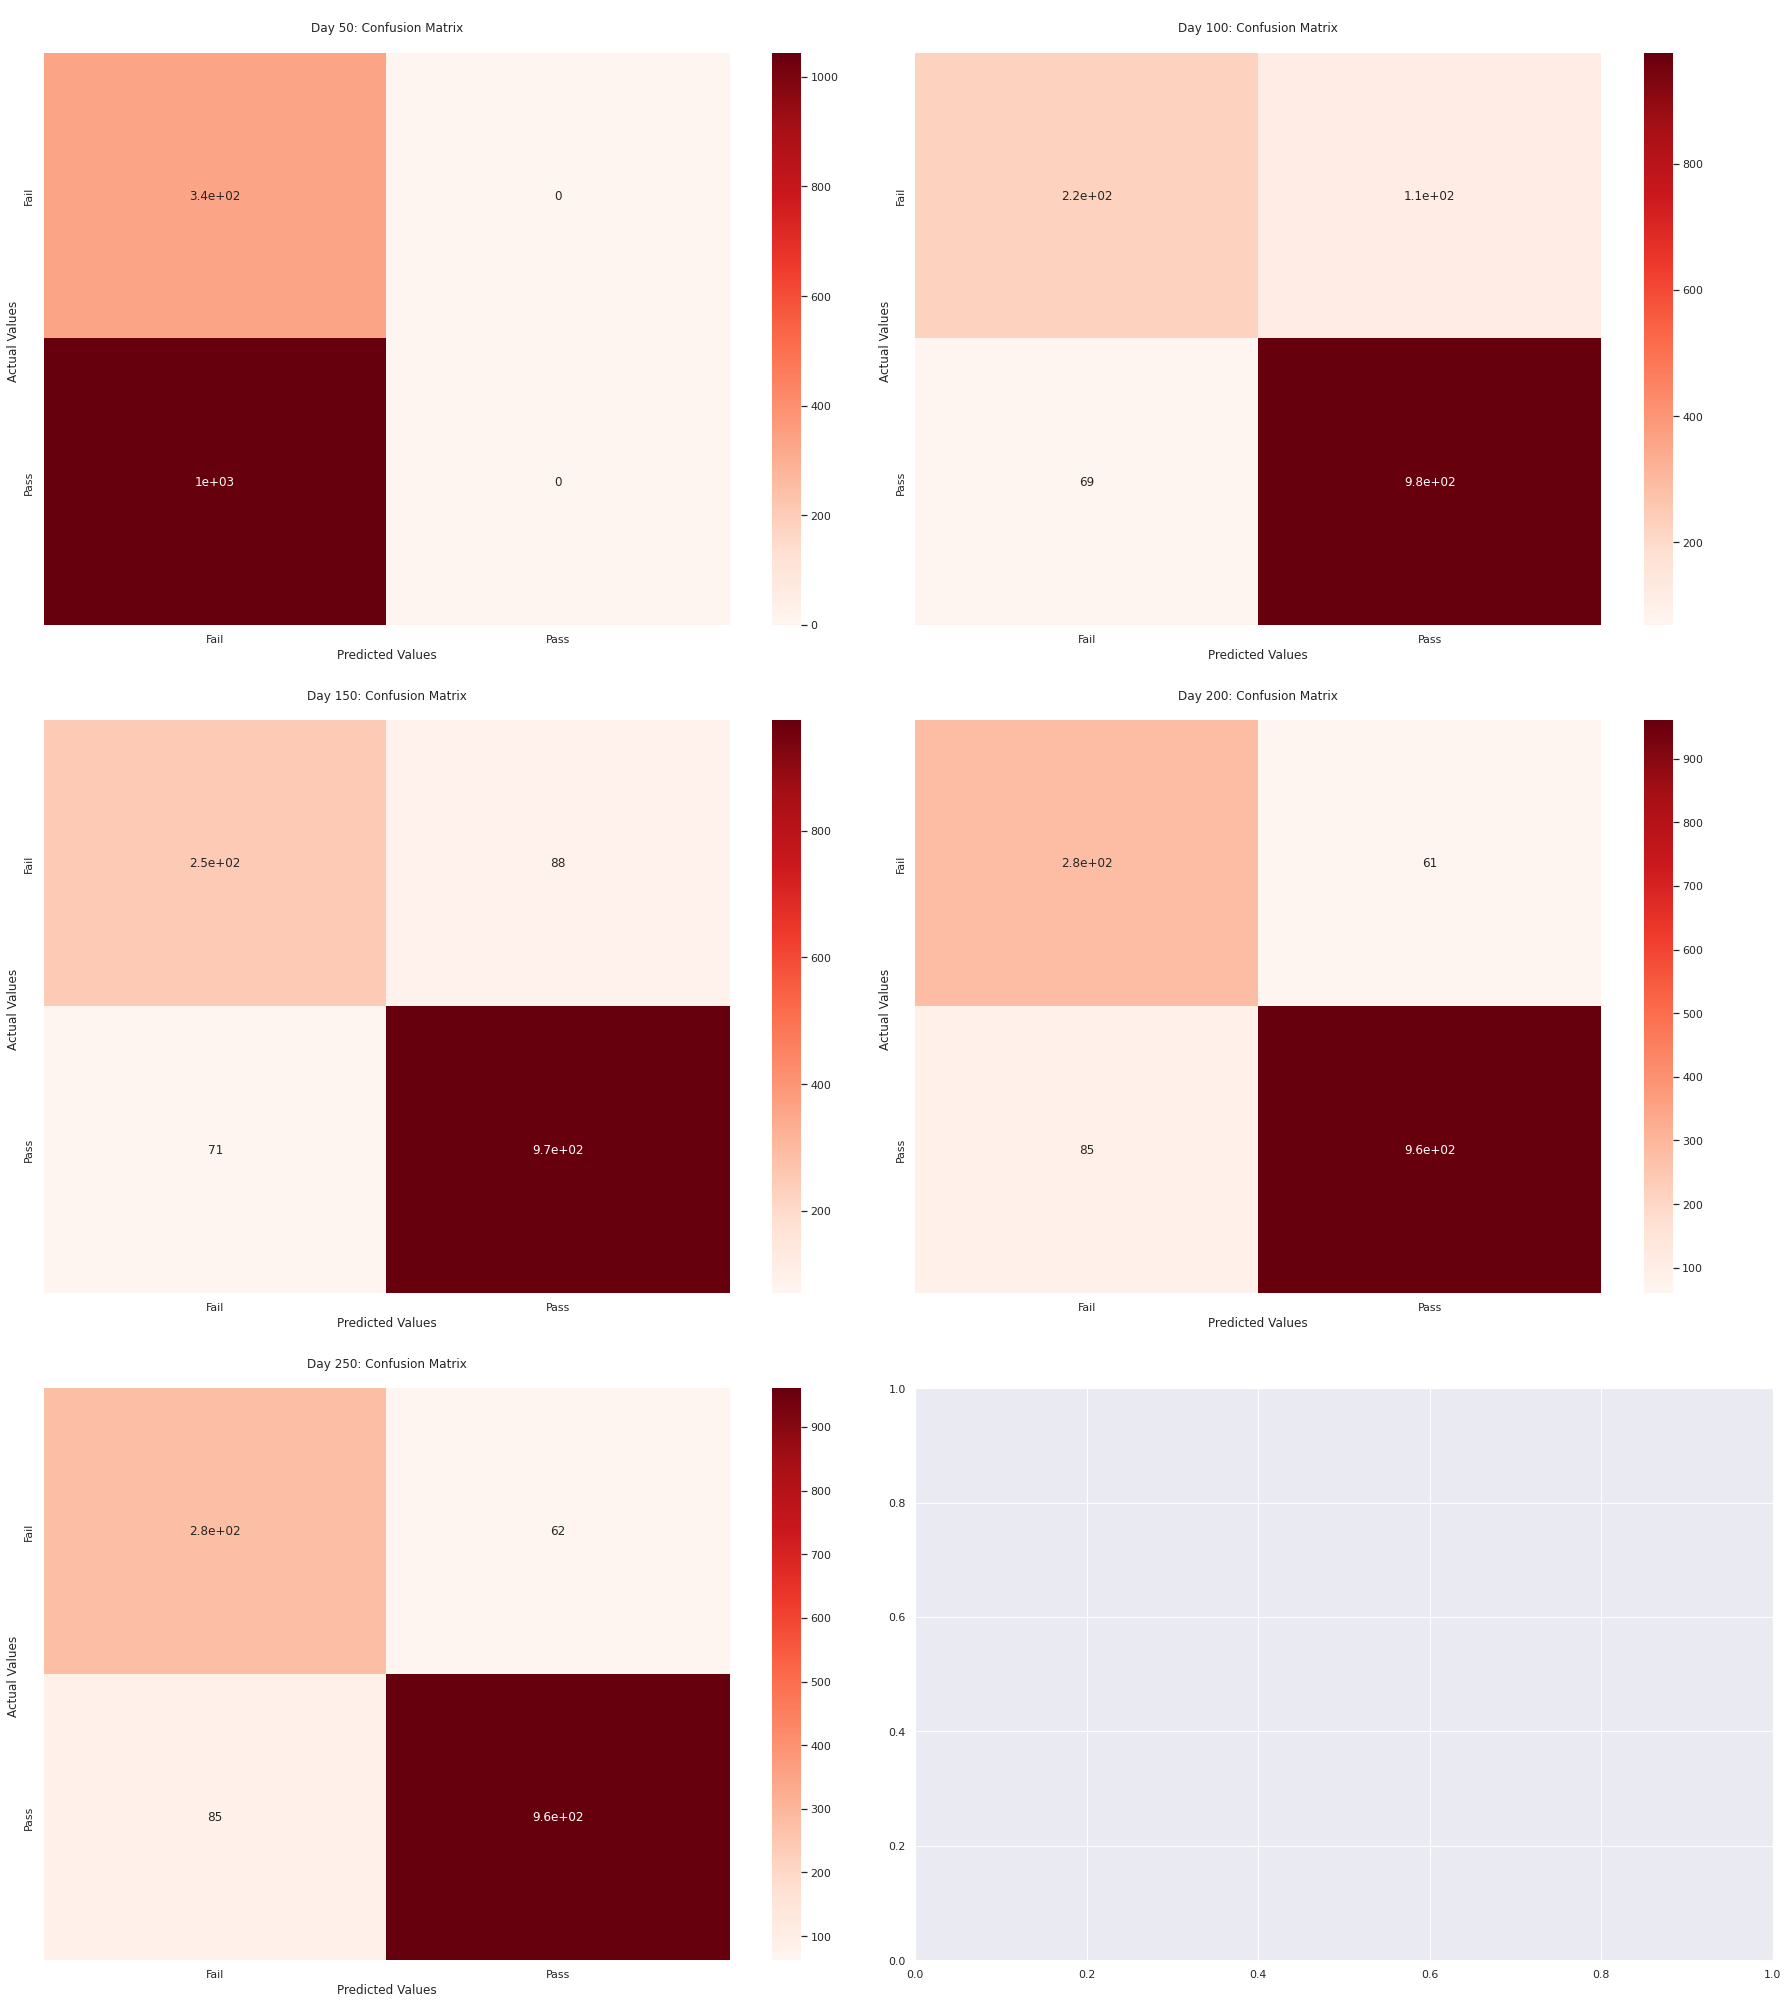

In [ ]:
plot_confusion_matrix(performance_results_lrw)

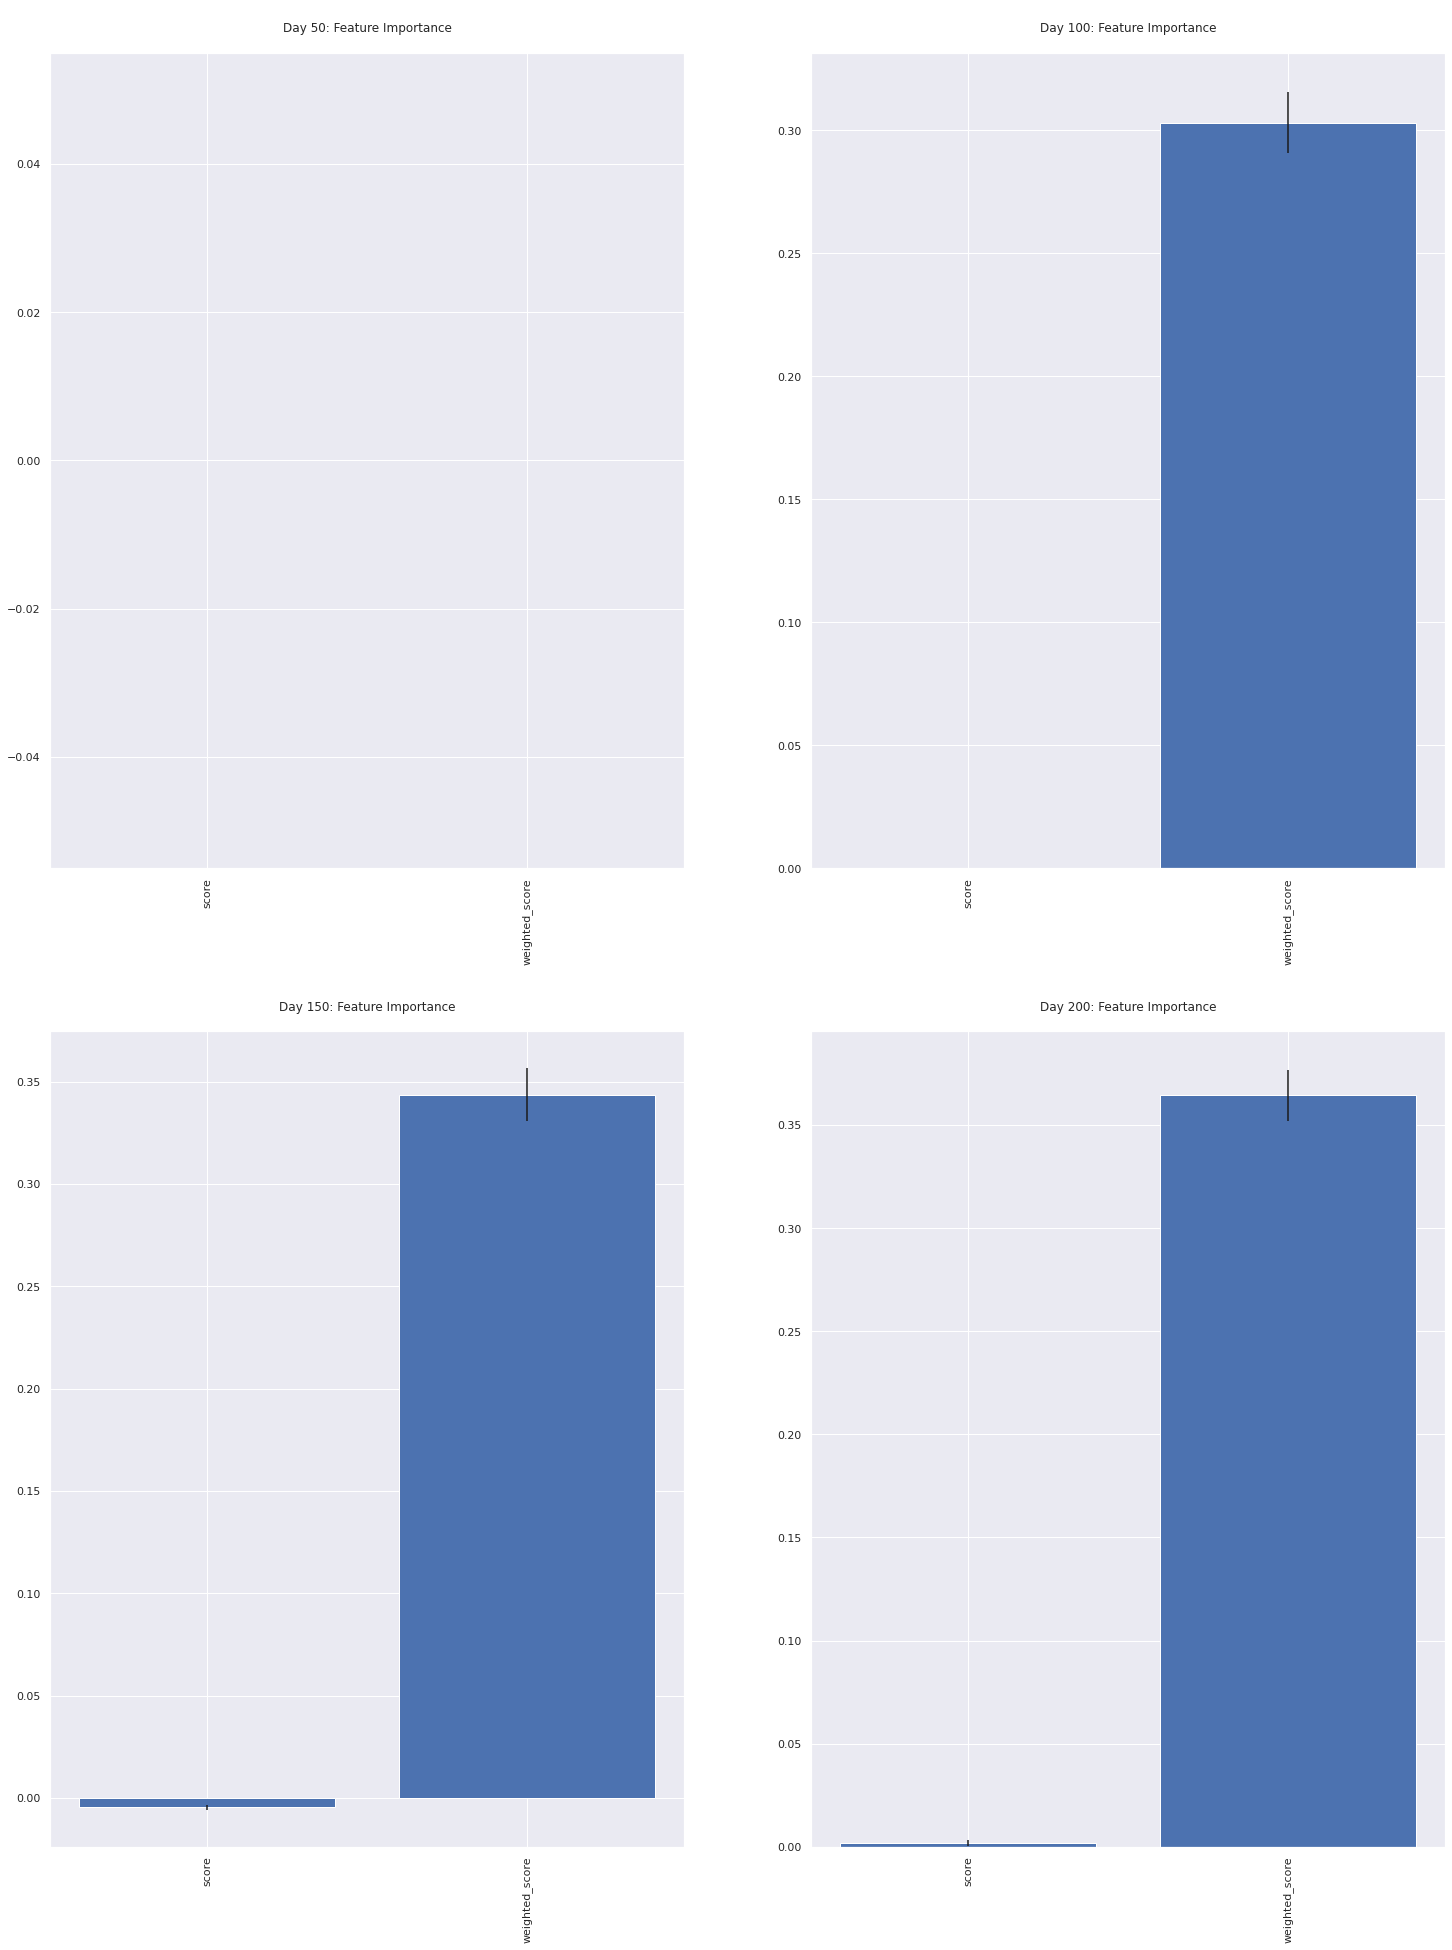

In [ ]:
plot_feature_importance(performance_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

performance_results_rf = []
performance_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_rf.append([acc, f1, prec, recall, conf])
  performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.715
Best parameters set:
	clf__n_estimators: 100
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.814
Best parameters set:
	clf__n_estimators: 120
Accuracy: 0.846820809248555, F1 Score: 0.9019426456984273, Precision: 0.8728737690241719, Recall: 0.9330143540669856


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.861
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.8773448773448773, F1 Score: 0.9204864359214219, Precision: 0.9002744739249772, Recall: 0.9416267942583733


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.886
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.8903318903318903, F1 Score: 0.9288389513108614, Precision: 0.9092575618698442, Recall: 0.9492822966507177


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{'

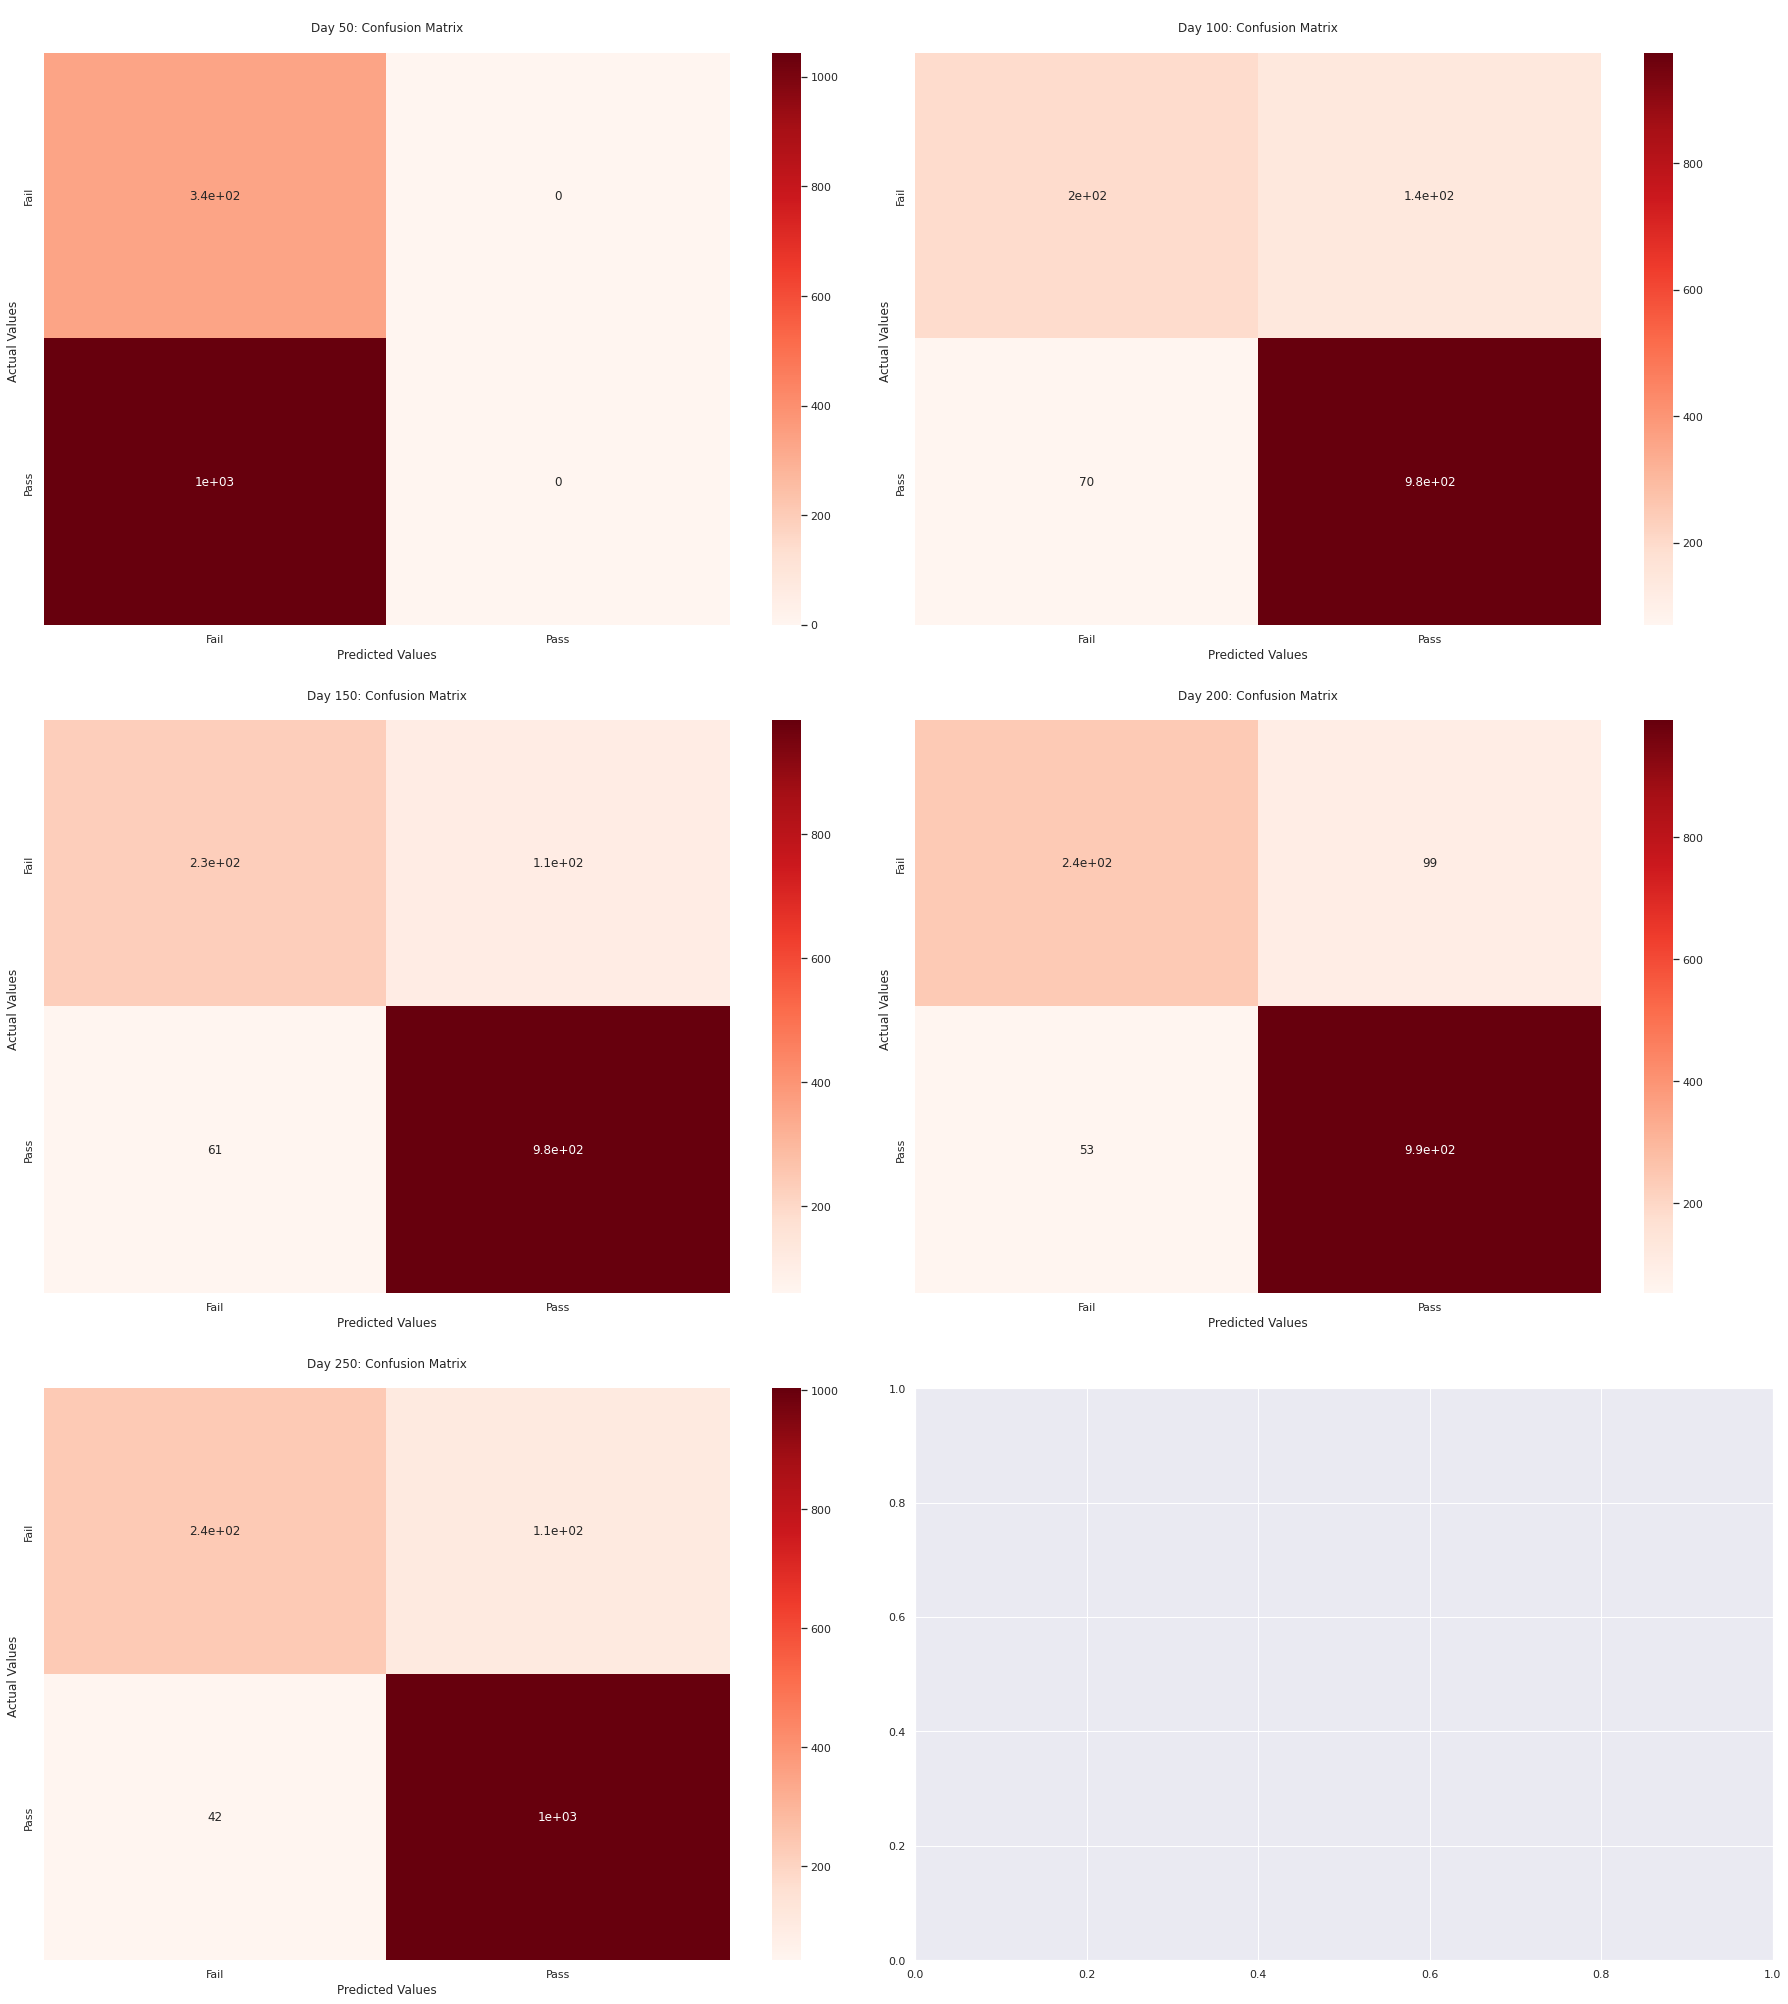

In [ ]:
plot_confusion_matrix(performance_results_rf)

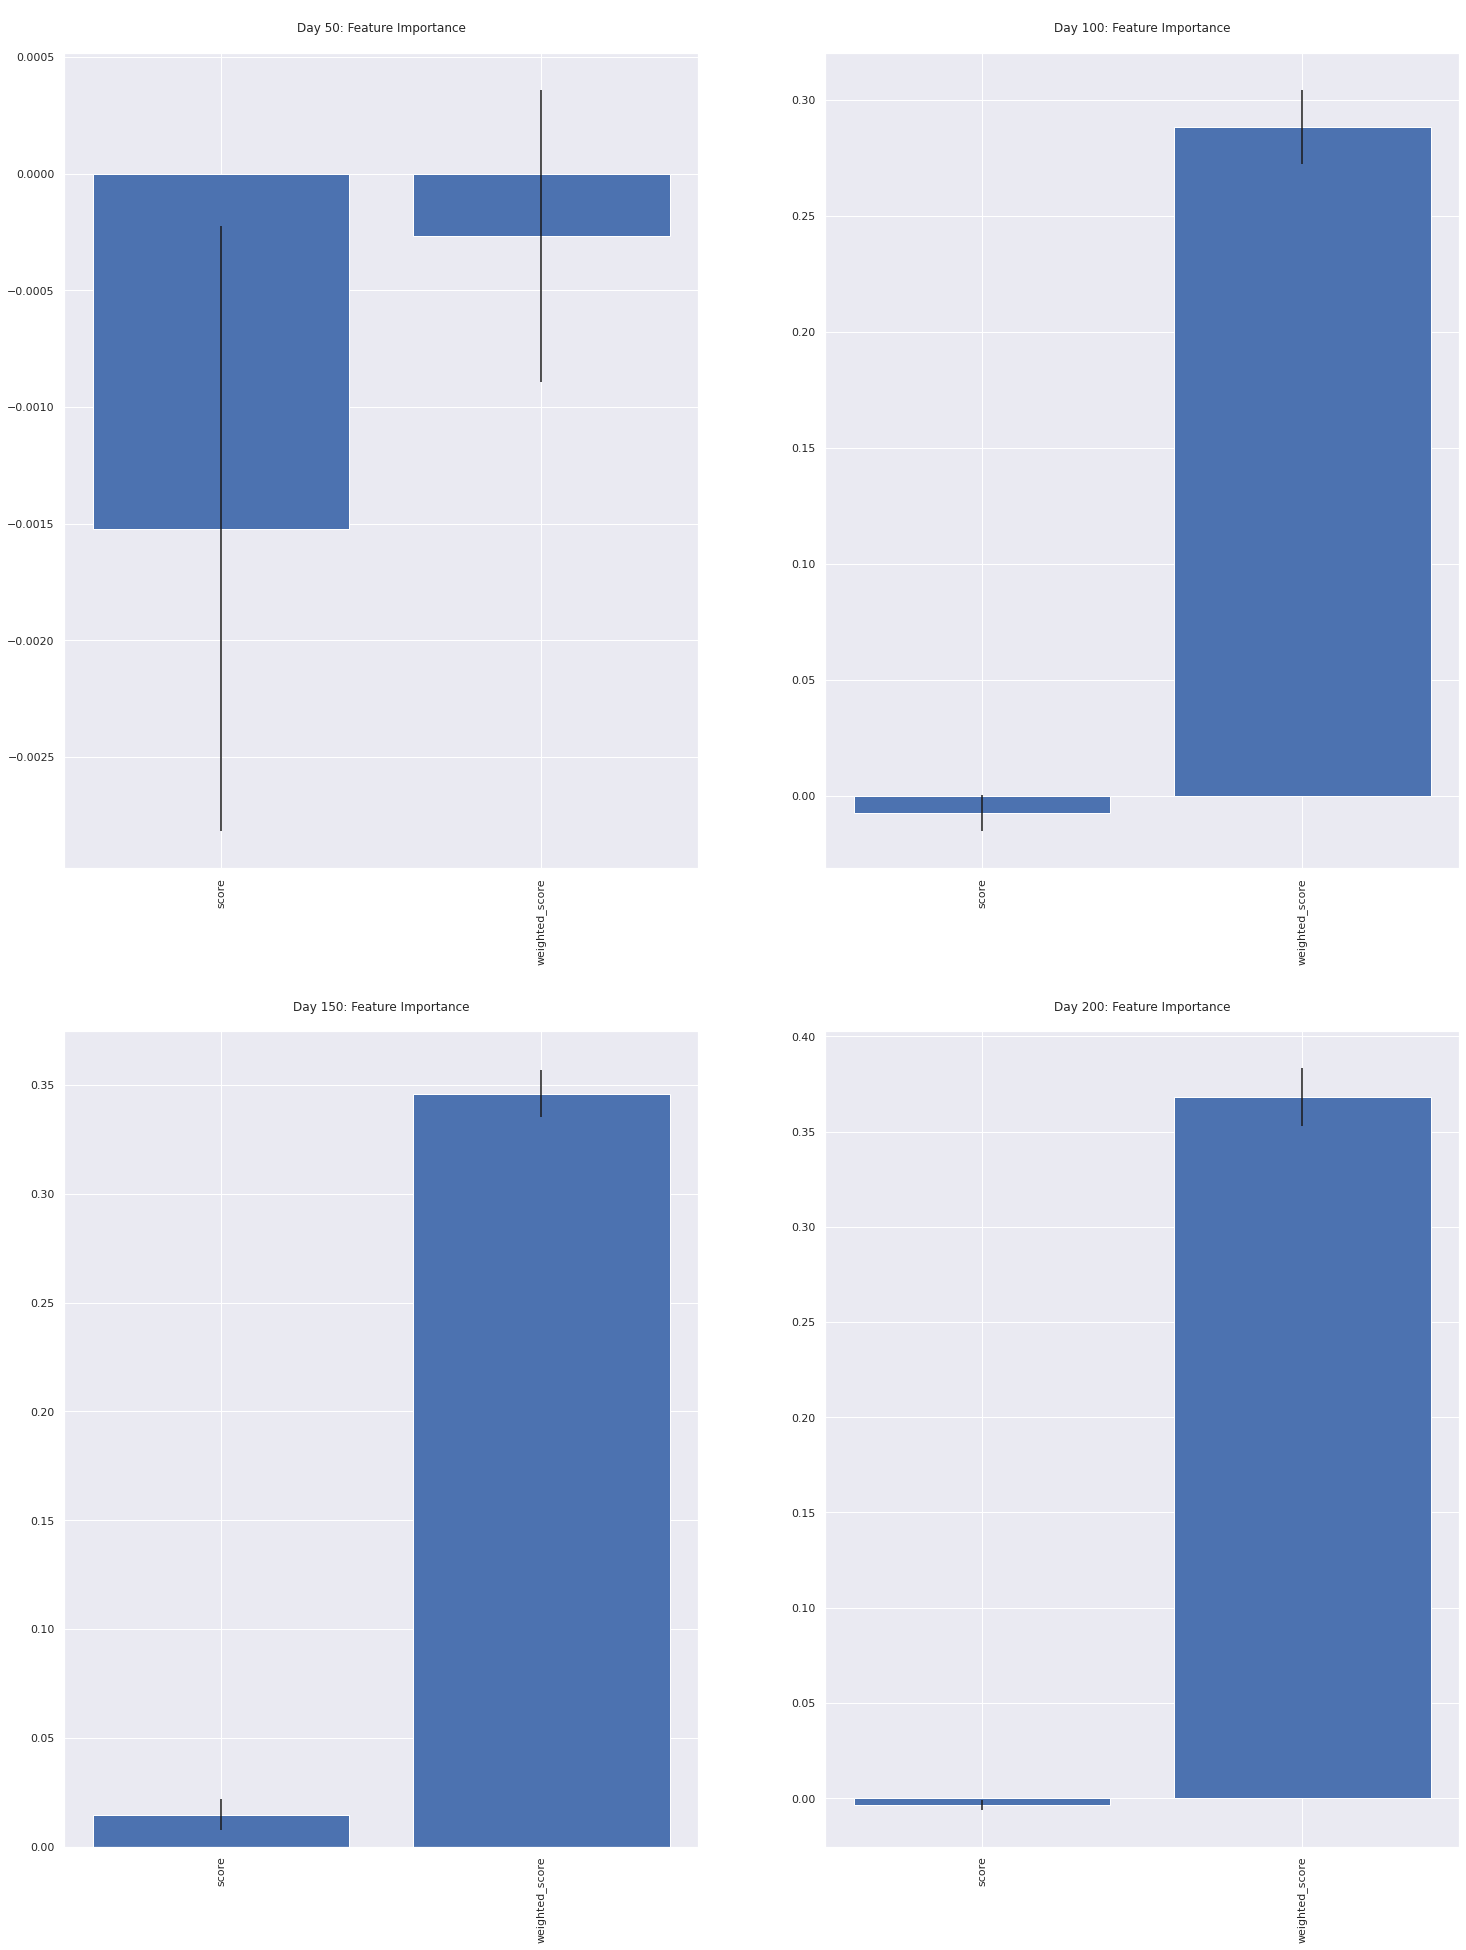

In [ ]:
plot_feature_importance(performance_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

performance_results_ab = []
performance_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_ab.append([acc, f1, prec, recall, conf])
  performance_features_ab.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.704
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.30021754894851344, F1 Score: 0.15720524017467252, Precision: 0.8910891089108911, Recall: 0.08620689655172414


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.845
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.865606936416185, F1 Score: 0.9174800354924579, Precision: 0.8552522746071133, Recall: 0.9894736842105263


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.870
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.8773448773448

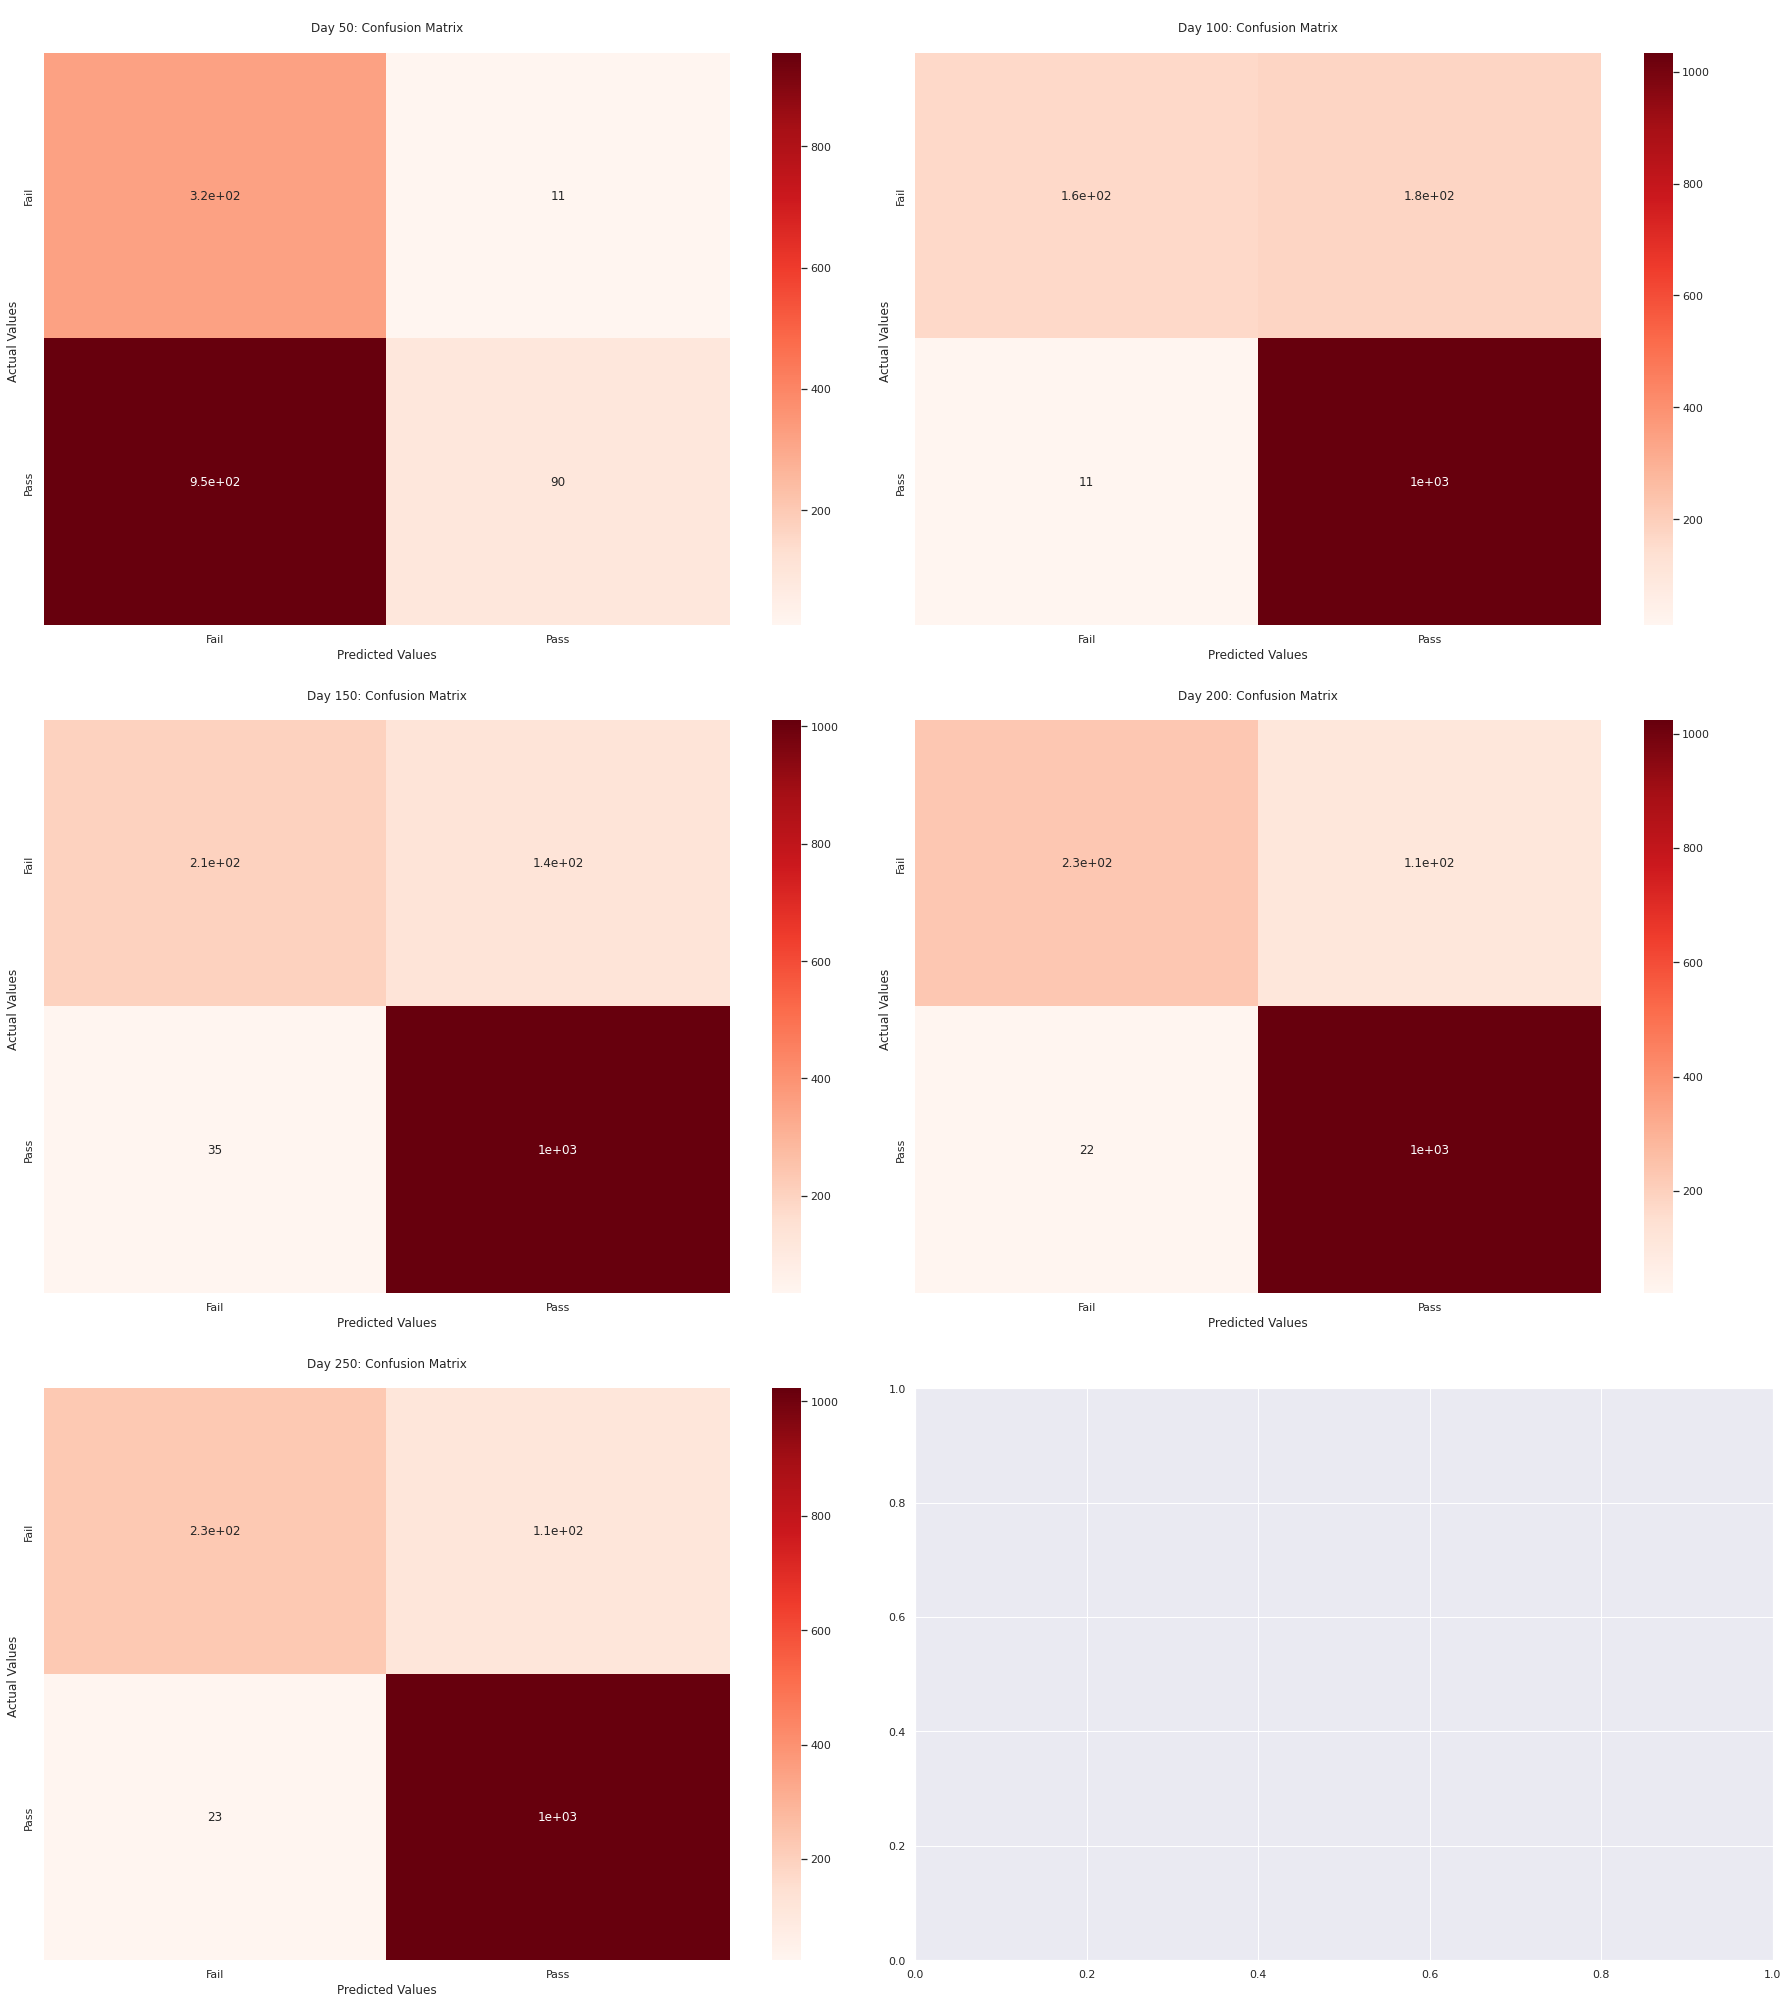

In [ ]:
plot_confusion_matrix(performance_results_ab)

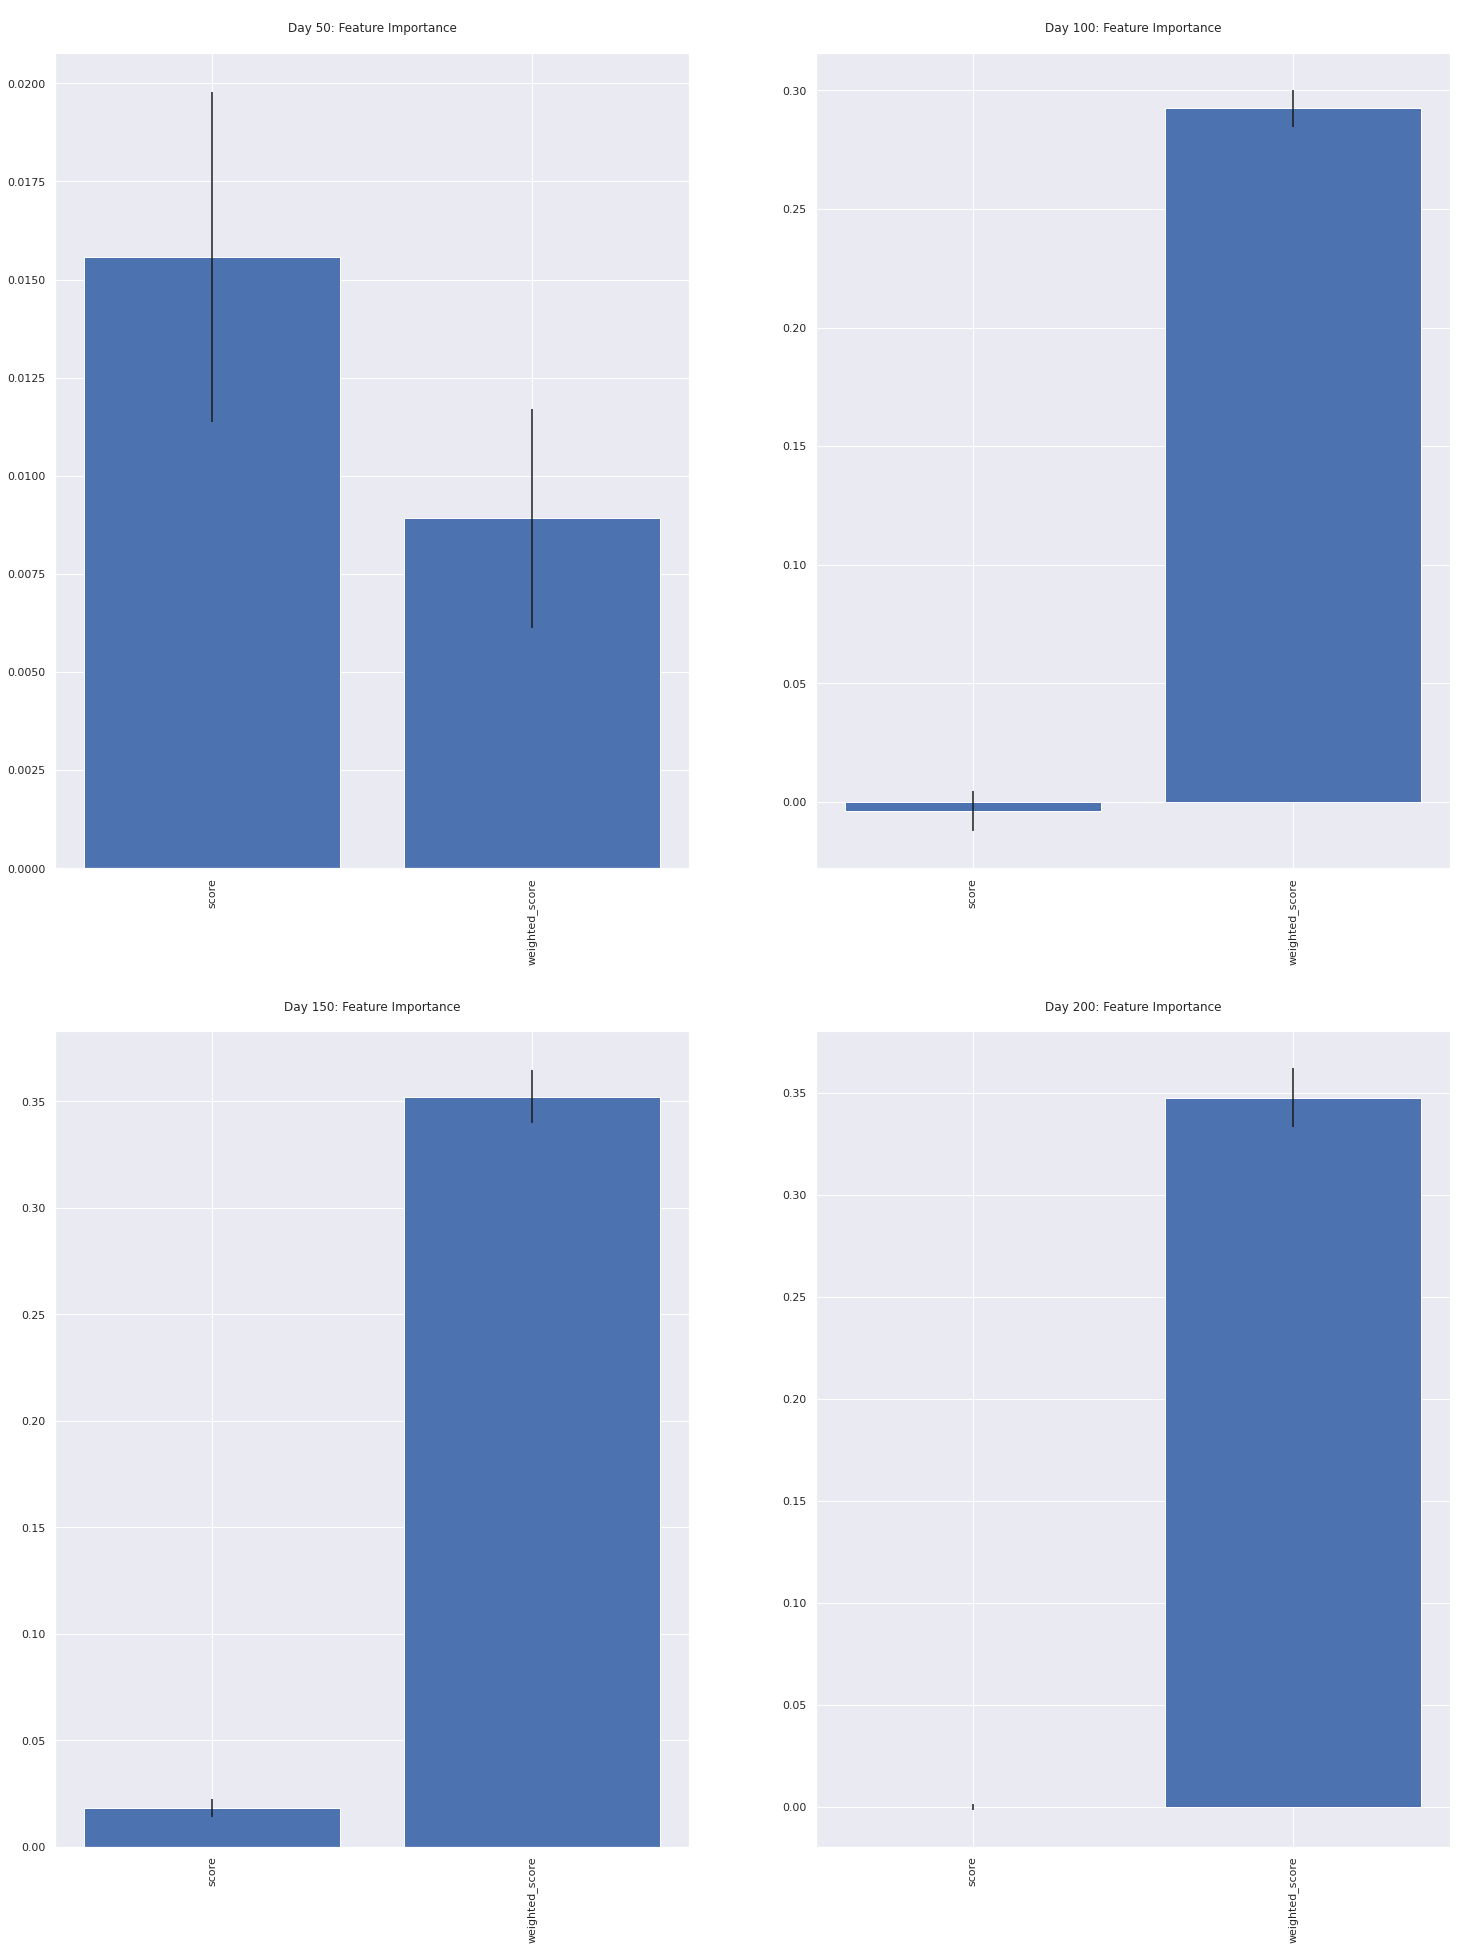

In [ ]:
plot_feature_importance(performance_features_ab)

##### Plot results overview

In [ ]:
performance_classifier_results = [performance_results_du, performance_results_nb, performance_results_lr, performance_results_lrw, performance_results_rf, performance_results_ab]
performance_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

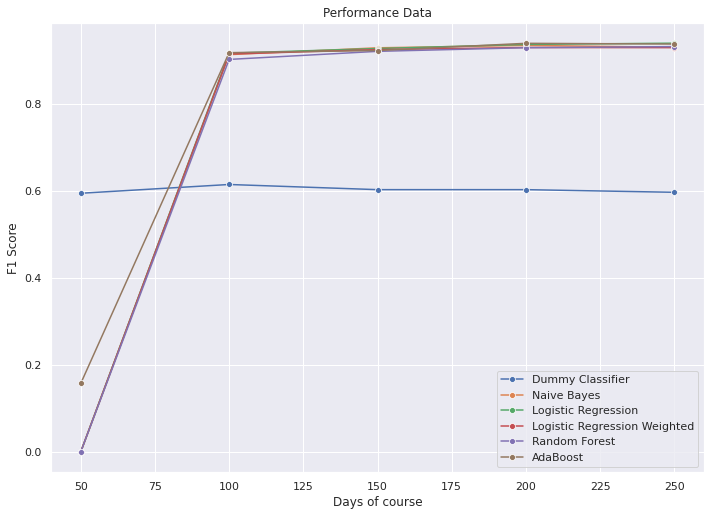

In [ ]:
plot_days_compare(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

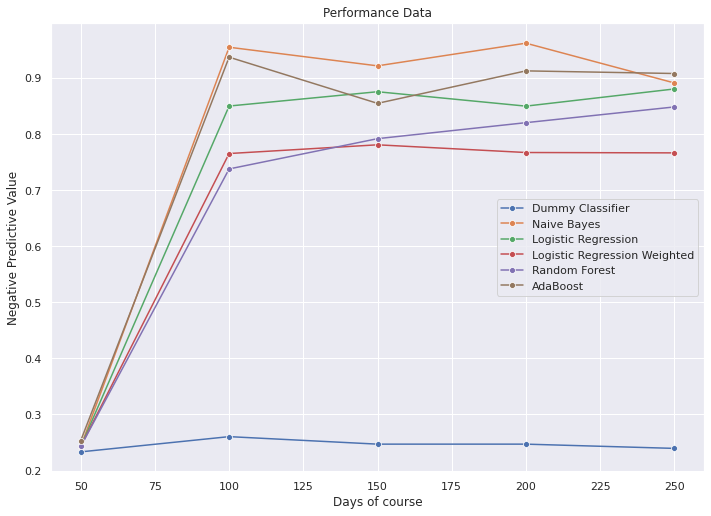

In [ ]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

#### All data (Demographic, Learning Behaviour, Performance)

- Demographic and learning behaviour used throughout classifier
- Performance added for the last two predictions (200, 250) days

##### Prepare data for prediction

In [ ]:
all_df = {}
for i in df.keys():
  all_df[i] = split_dataframe_by_data_type(df[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [ ]:
all_df[50]

code_presentation  id_student gender  ... score weighted_score final_result
0                2013B       33915      F  ...  90.0         22.680            1
1                2013B       35544      M  ...  86.0         21.672            1
2                2013B       35860      M  ...  84.0         21.168            1
3                2013B       42668      M  ...  74.0         18.648            1
4                2013B       43273      M  ...  81.0         20.412            1
...                ...         ...    ...  ...   ...            ...          ...
4797             2014J     2681198      M  ...  66.0          8.316            1
4798             2014J     2682682      F  ...  96.0         12.096            1
4799             2014J     2683857      M  ...  72.0          9.072            1
4800             2014J     2693932      M  ...  90.0         11.340            1
4801             2014J     2697921      M  ...  94.0         11.844            1

[4802 rows x 27 columns]

In [ ]:
for i in list(df)[1:2]:
  all_df[i] = all_df[i].drop(columns=["score","weighted_score"])

for i in list(df)[2:]:
  all_df[i] = all_df[i].drop(columns=["score"])

In [ ]:
all_df[50]

code_presentation  id_student  ... ouelluminate final_result
0                2013B       33915  ...     1.454545            1
1                2013B       35544  ...     0.000000            1
2                2013B       35860  ...     0.000000            1
3                2013B       42668  ...     0.000000            1
4                2013B       43273  ...     0.000000            1
...                ...         ...  ...          ...          ...
4797             2014J     2681198  ...     0.000000            1
4798             2014J     2682682  ...     0.000000            1
4799             2014J     2683857  ...     0.000000            1
4800             2014J     2693932  ...     0.000000            1
4801             2014J     2697921  ...     0.000000            1

[4802 rows x 25 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(all_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['dualpane', 'glossary', 'mean_click', 'questionnaire', 'subpage',
       'ouwiki', 'oucollaborate', 'quiz', 'page', 'url', 'resource', 'forumng',
       'oucontent', 'homepage'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['dualpane', 'glossary', 'mean_click', 'questionnaire', 'subpage',
       'ouwiki', 'oucollaborate', 'quiz', 'page', 'url', 'resource', 'forumng',
       'oucontent', 'homepage'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['repeatactivity', 'dualpane', 'glossary', 'mean_click', 'questionnaire',
       'subpage', 'ouwiki', 'oucollaborate', 'quiz', 'page', 'url', 'resource',
       'forumng', 'oucontent', 'homepage', 'weighted_score'],
      dtype='o

In [ ]:
X_train[50]

gender_F  gender_M  ...  oucontent  homepage
1072       0.0       1.0  ...   0.297030  0.086810
1073       0.0       1.0  ...   0.425482  0.232355
1074       0.0       1.0  ...   0.315017  0.070837
1075       0.0       1.0  ...   0.418608  0.102662
1076       1.0       0.0  ...   0.270056  0.167500
...        ...       ...  ...        ...       ...
2513       0.0       1.0  ...   0.339260  0.208344
2514       0.0       1.0  ...   0.556527  0.063950
2515       0.0       1.0  ...   0.056931  0.069764
2516       0.0       1.0  ...   0.249264  0.110978
2517       0.0       1.0  ...   0.545865  0.041322

[1446 rows x 49 columns]

###### Undersampling

In [ ]:
Y_train[50].value_counts()

1    1028
0     418
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = TomekLinks() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 984, 0: 407})
Resample dataset shape Counter({1: 844, 0: 407})
Sampling for day 50
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({1: 882, 0: 418})
Sampling for day 100
Original dataset shape: Counter({1: 1028, 0: 418})
Resample dataset shape Counter({1: 909, 0: 418})
Sampling for day 150
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({1: 917, 0: 419})
Sampling for day 200
Original dataset shape: Counter({1: 1028, 0: 419})
Resample dataset shape Counter({1: 925, 0: 419})
Sampling for day 250
Original dataset shape: Counter({1: 1028, 0: 425})
Resample dataset shape Counter({1: 940, 0: 425})


###### Reduce dimensions

In [ ]:
for i in df.keys():
  pca = PCA(n_components='mle')

  X_train[i] = pca.fit_transform(X_train[i], Y_train[i])                             
  
  X_test[i] = pca.transform(X_test[i])

In [ ]:
X_train[250].shape

(1453, 46)

###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0         1         2   ...        17        18        19
0     0.622762  1.109845 -0.470504  ...  0.200804 -0.087413  0.006897
1     0.551880 -0.580229 -0.096281  ... -0.137190  0.006164 -0.005729
2    -0.693986 -0.213145 -0.268482  ...  0.070682 -0.277501  0.004403
3    -0.743738 -0.065762 -0.306660  ... -0.066450 -0.153306 -0.005222
4     1.094906  0.916048  1.065543  ... -0.147268 -0.127174  0.001928
...        ...       ...       ...  ...       ...       ...       ...
1448 -0.717920 -0.242196 -0.182929  ...  0.069319  0.288893 -0.011533
1449 -0.670698 -0.192673 -0.236074  ...  0.130403 -0.065697  0.009566
1450  0.608375 -0.748491 -0.279832  ... -0.445152 -0.069341 -0.002513
1451  0.555144 -0.608178 -0.165453  ...  0.048541  0.128576 -0.002735
1452  0.500545 -0.625872 -0.126948  ... -0.122173  0.068033  0.005267

[1453 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

all_results_du = []
all_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_du.append([acc, f1, prec, recall, conf])
  all_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.485
Best parameters set:
Accuracy: 0.5060698027314112, F1 Score: 0.6052152819890844, Precision: 0.7595129375951294, Recall: 0.5030241935483871


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best

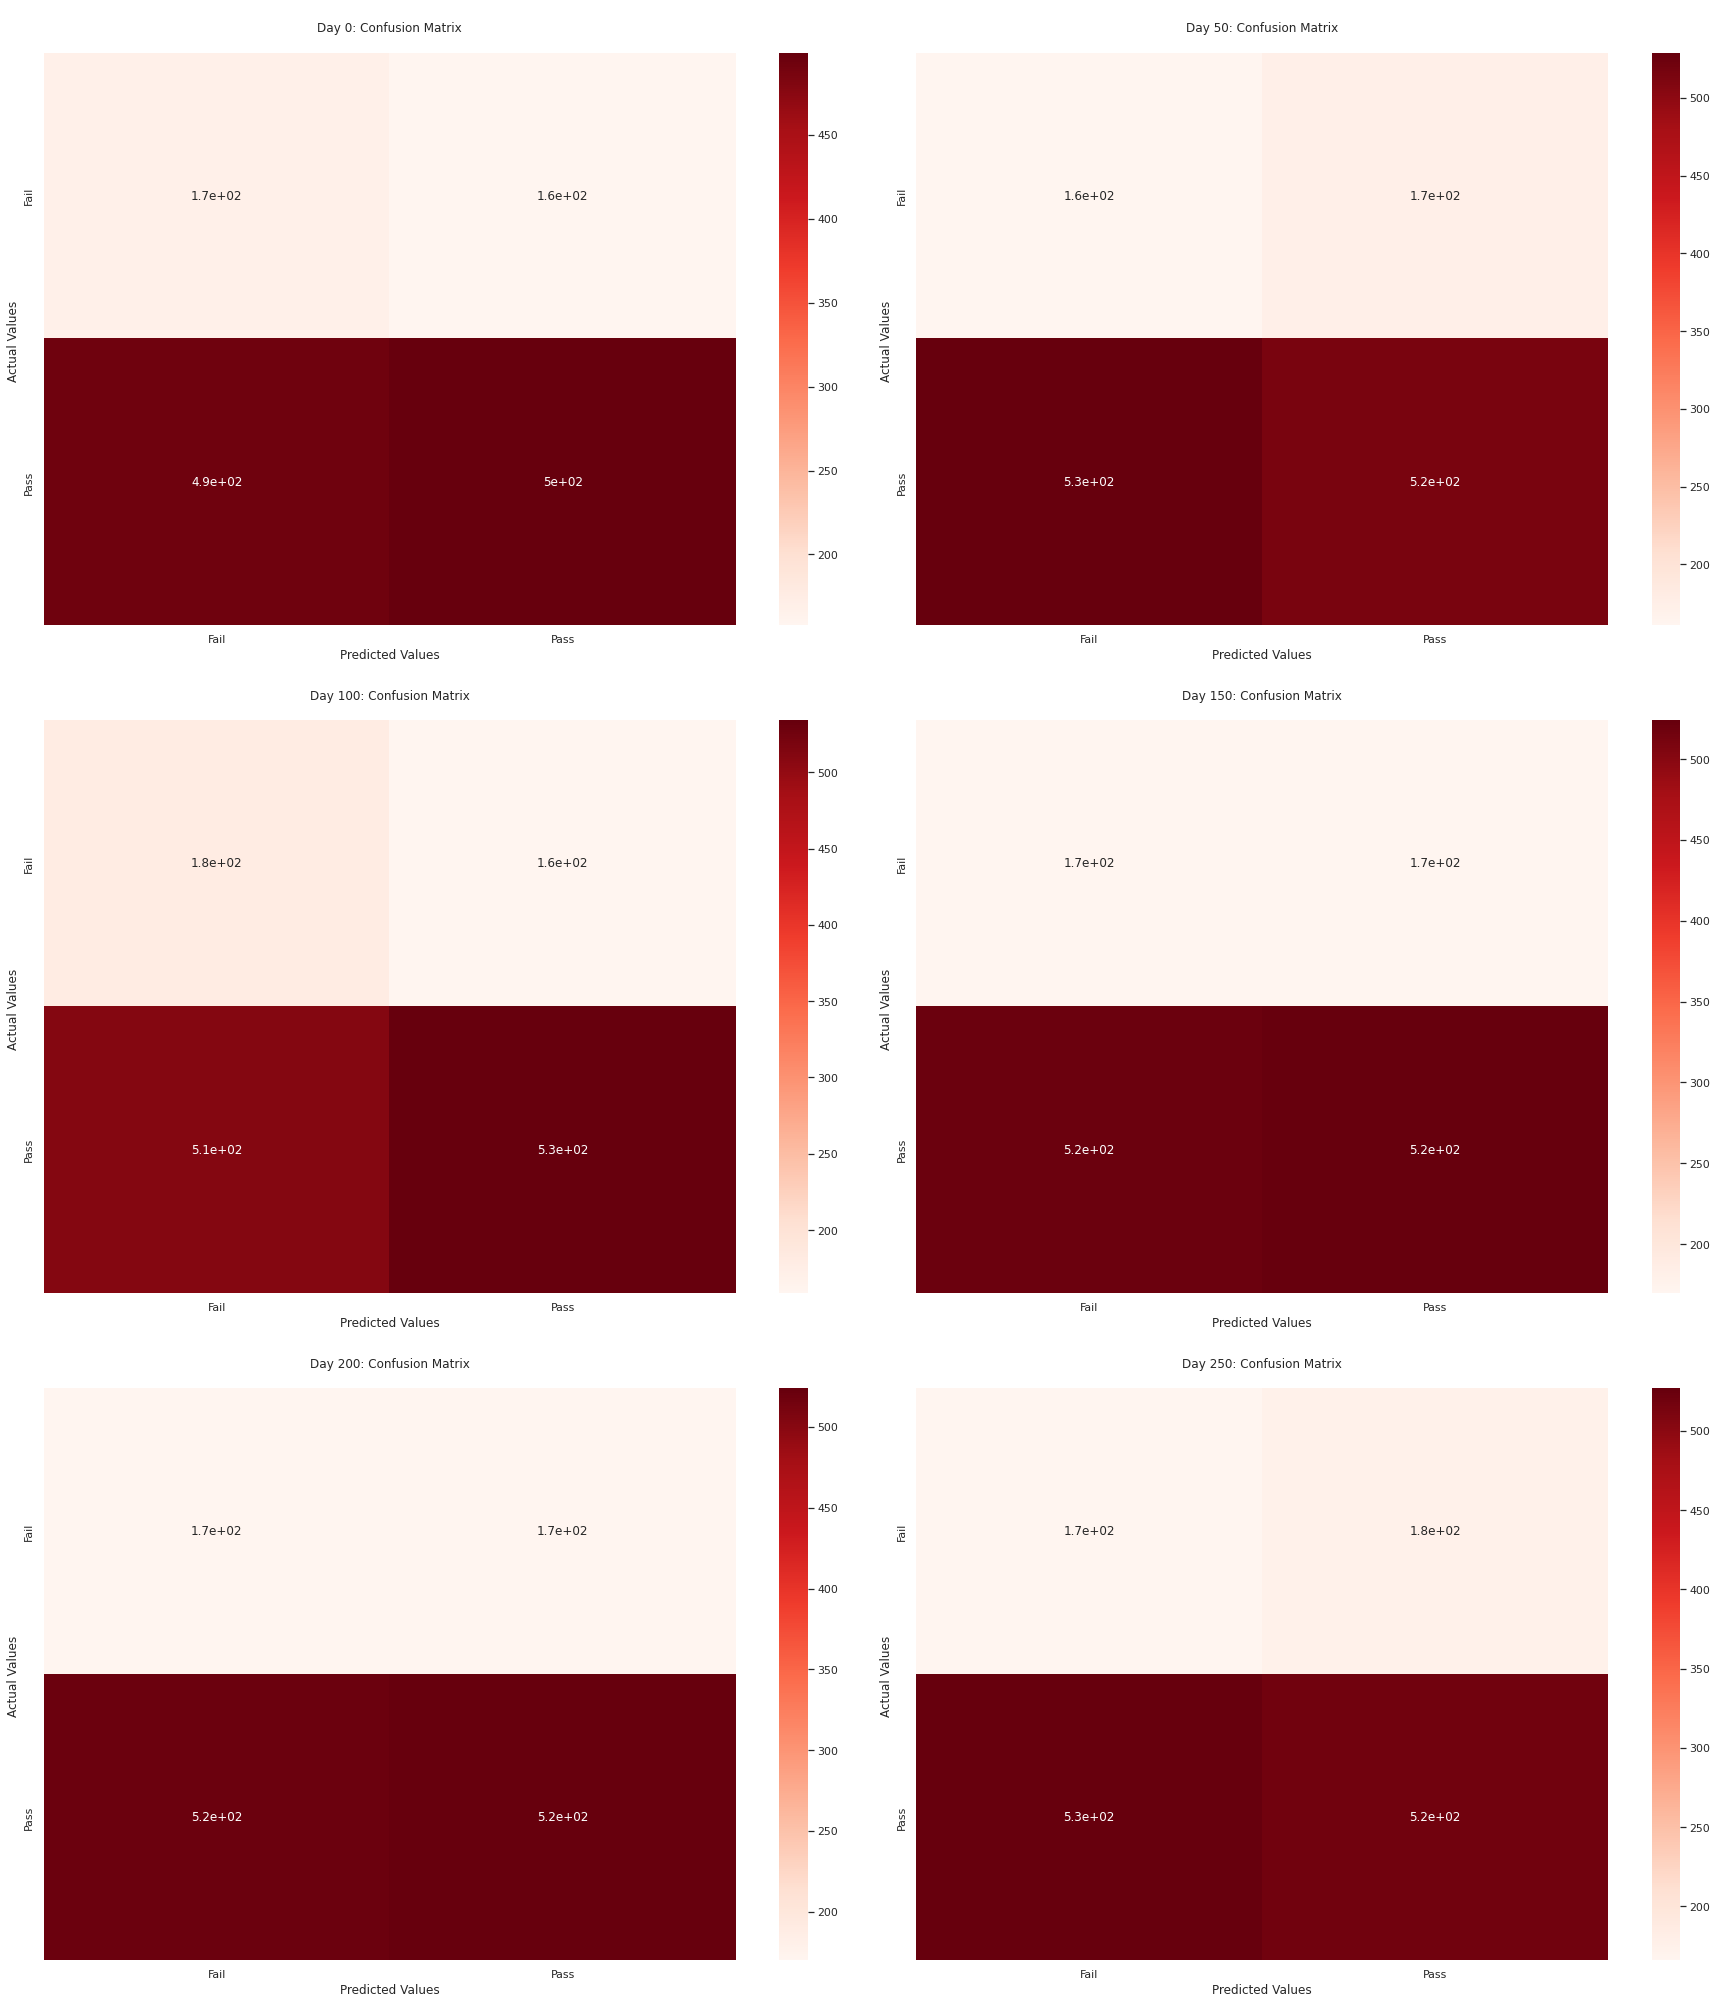

In [ ]:
plot_confusion_matrix(all_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

all_results_nb = []

pipeline = Pipeline([
    ('clf', GaussianNB()),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_nb.append([acc, f1, prec, recall, conf])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.609
Best parameters set:
Accuracy: 0.6949924127465857, F1 Score: 0.7961460446247465, Precision: 0.8010204081632653, Recall: 0.7913306451612904


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.654
Best parameters set:
Accuracy: 0.728788977519942, F1 Score: 0.8172043010752689, Precision: 0.8343313373253493, Recall: 0.8007662835249042


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.712
Best parameters set:
Accuracy: 0.8208092485549133, F1 Score: 0.8918918918918918, Precision: 0.8190552441953562, Recall: 0.9789473684210527


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.701
Best 

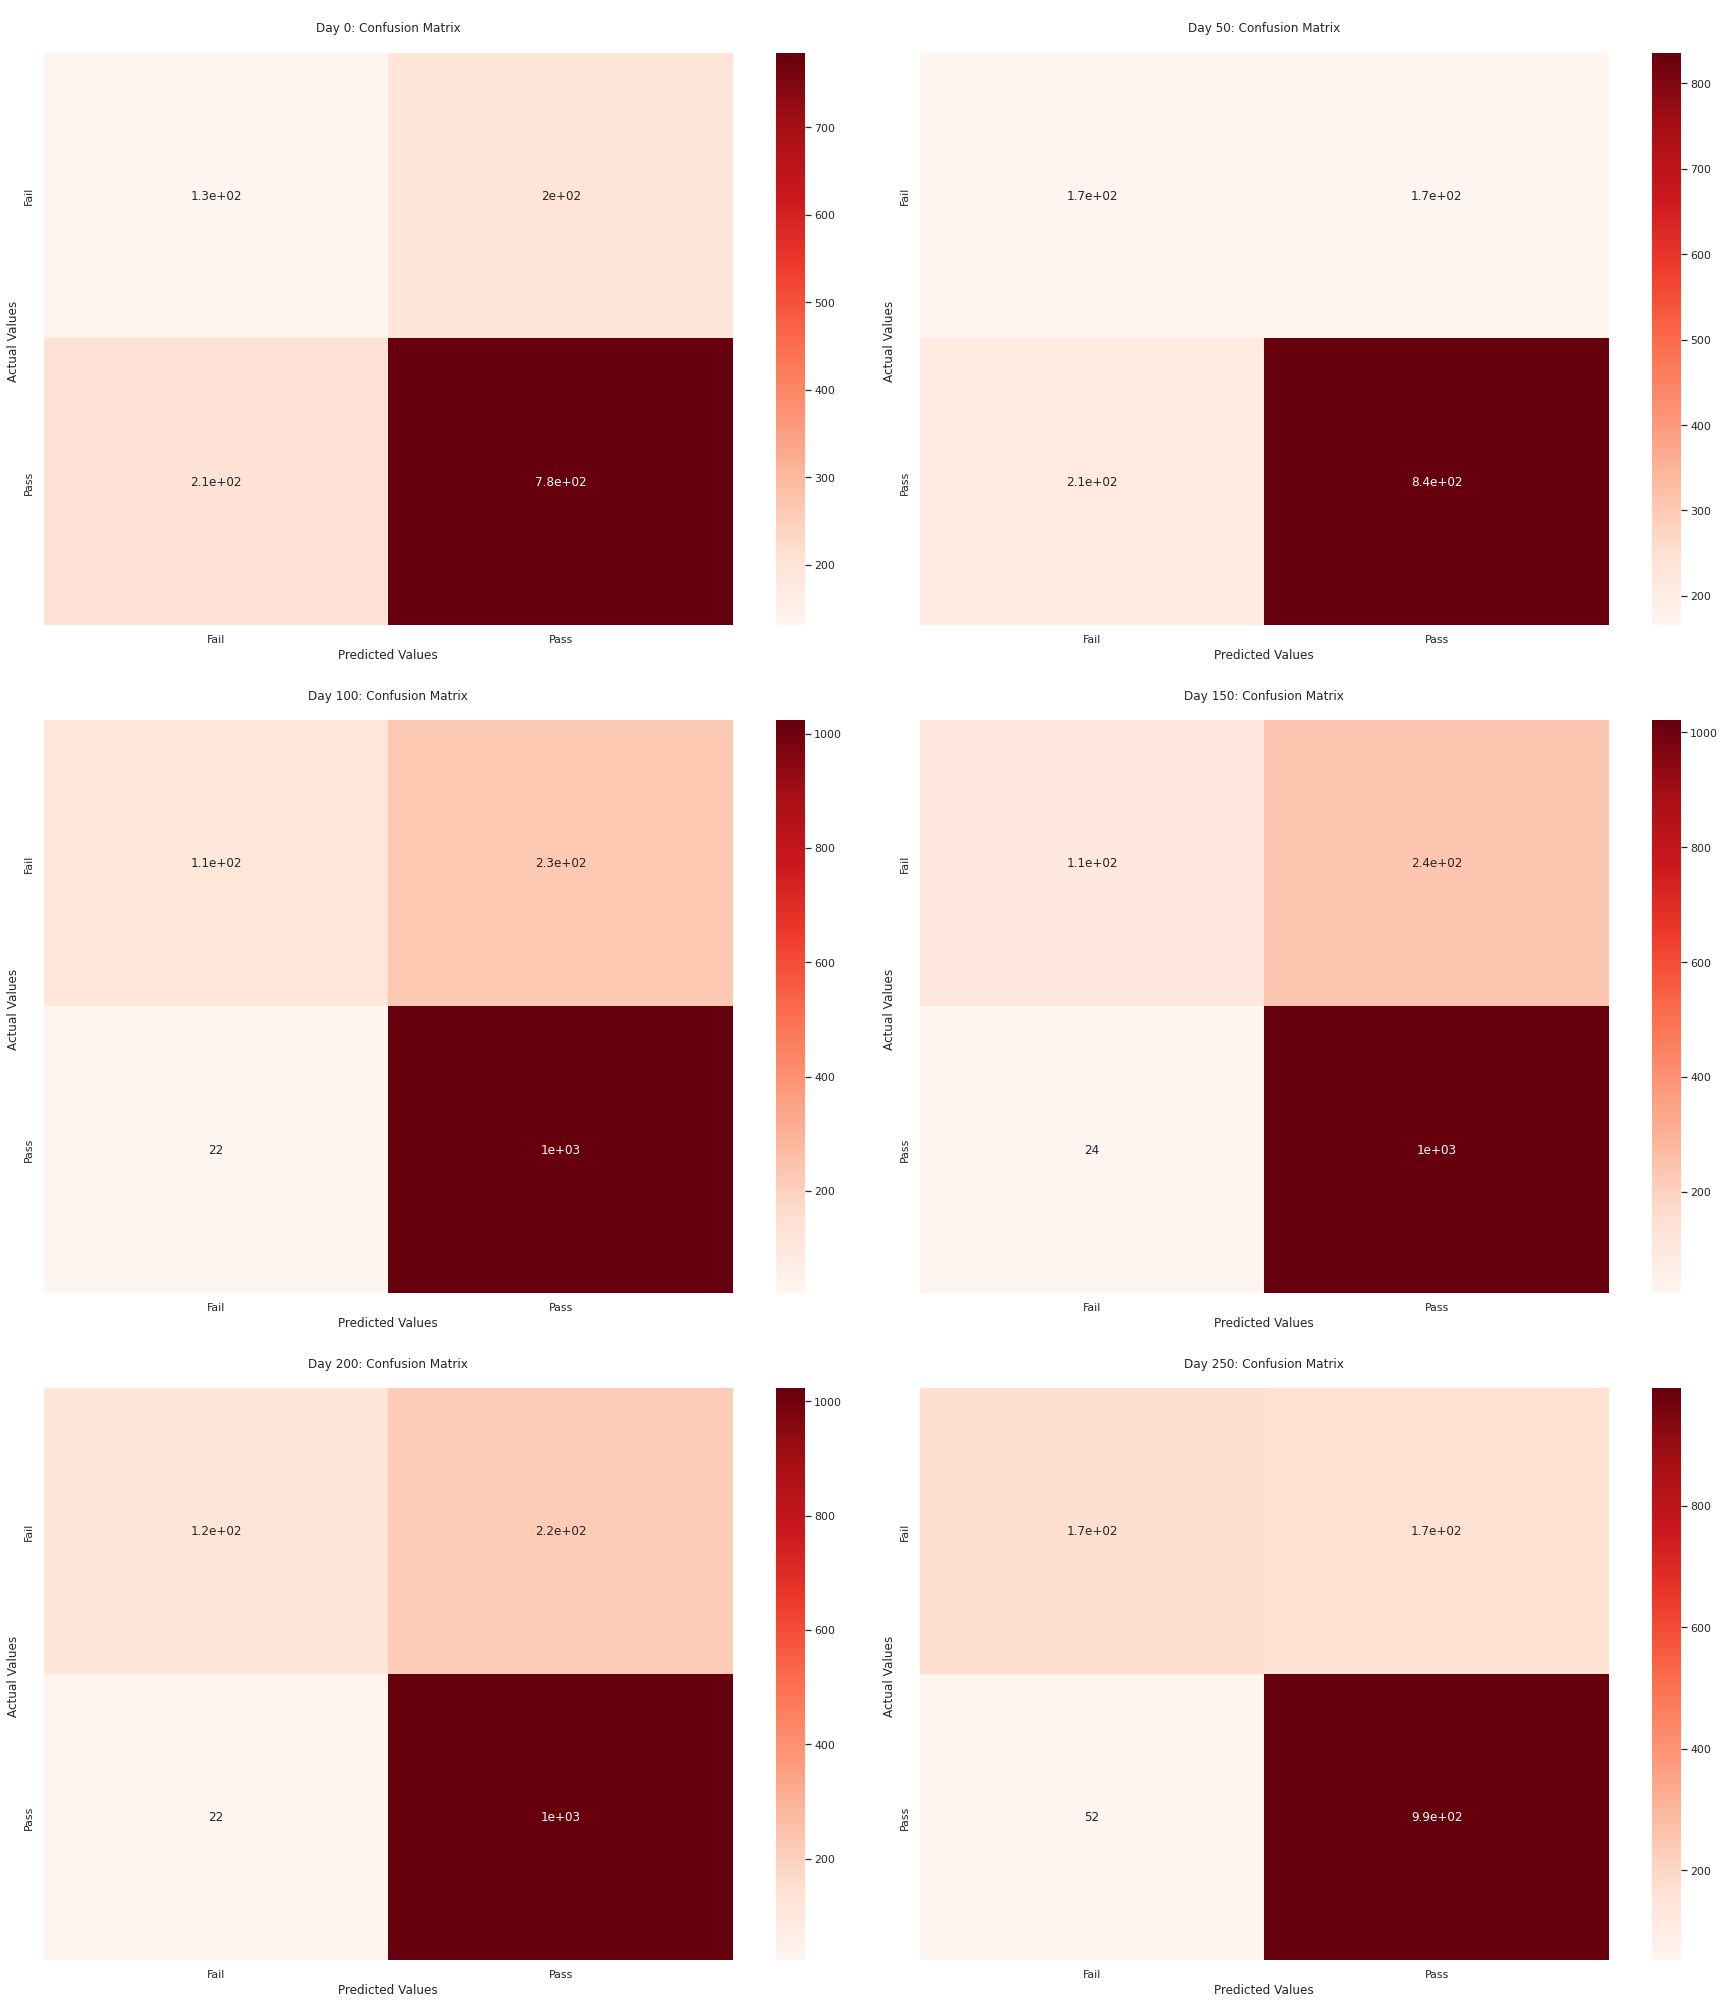

In [ ]:
plot_confusion_matrix(all_results_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

all_results_predict_proba_lr = []
all_results_predict_lr = []

all_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lr.append([acc, f1, prec, recall, conf])
  all_results_predict_proba_lr.append(predictions_proba)
  all_results_predict_lr.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.595
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7314112291350531, F1 Score: 0.8301343570057581, Precision: 0.7921245421245421, Recall: 0.8719758064516129


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.657
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7556200145032632, F1 Score: 0.8430367955286446, Precision: 0.8204895738893926, Recall: 0.8668582375478927


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.840
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.865606936416185, F1 Score: 0.9148351648351649, Precision: 0.8770851624231782, Recall: 0.955980861244

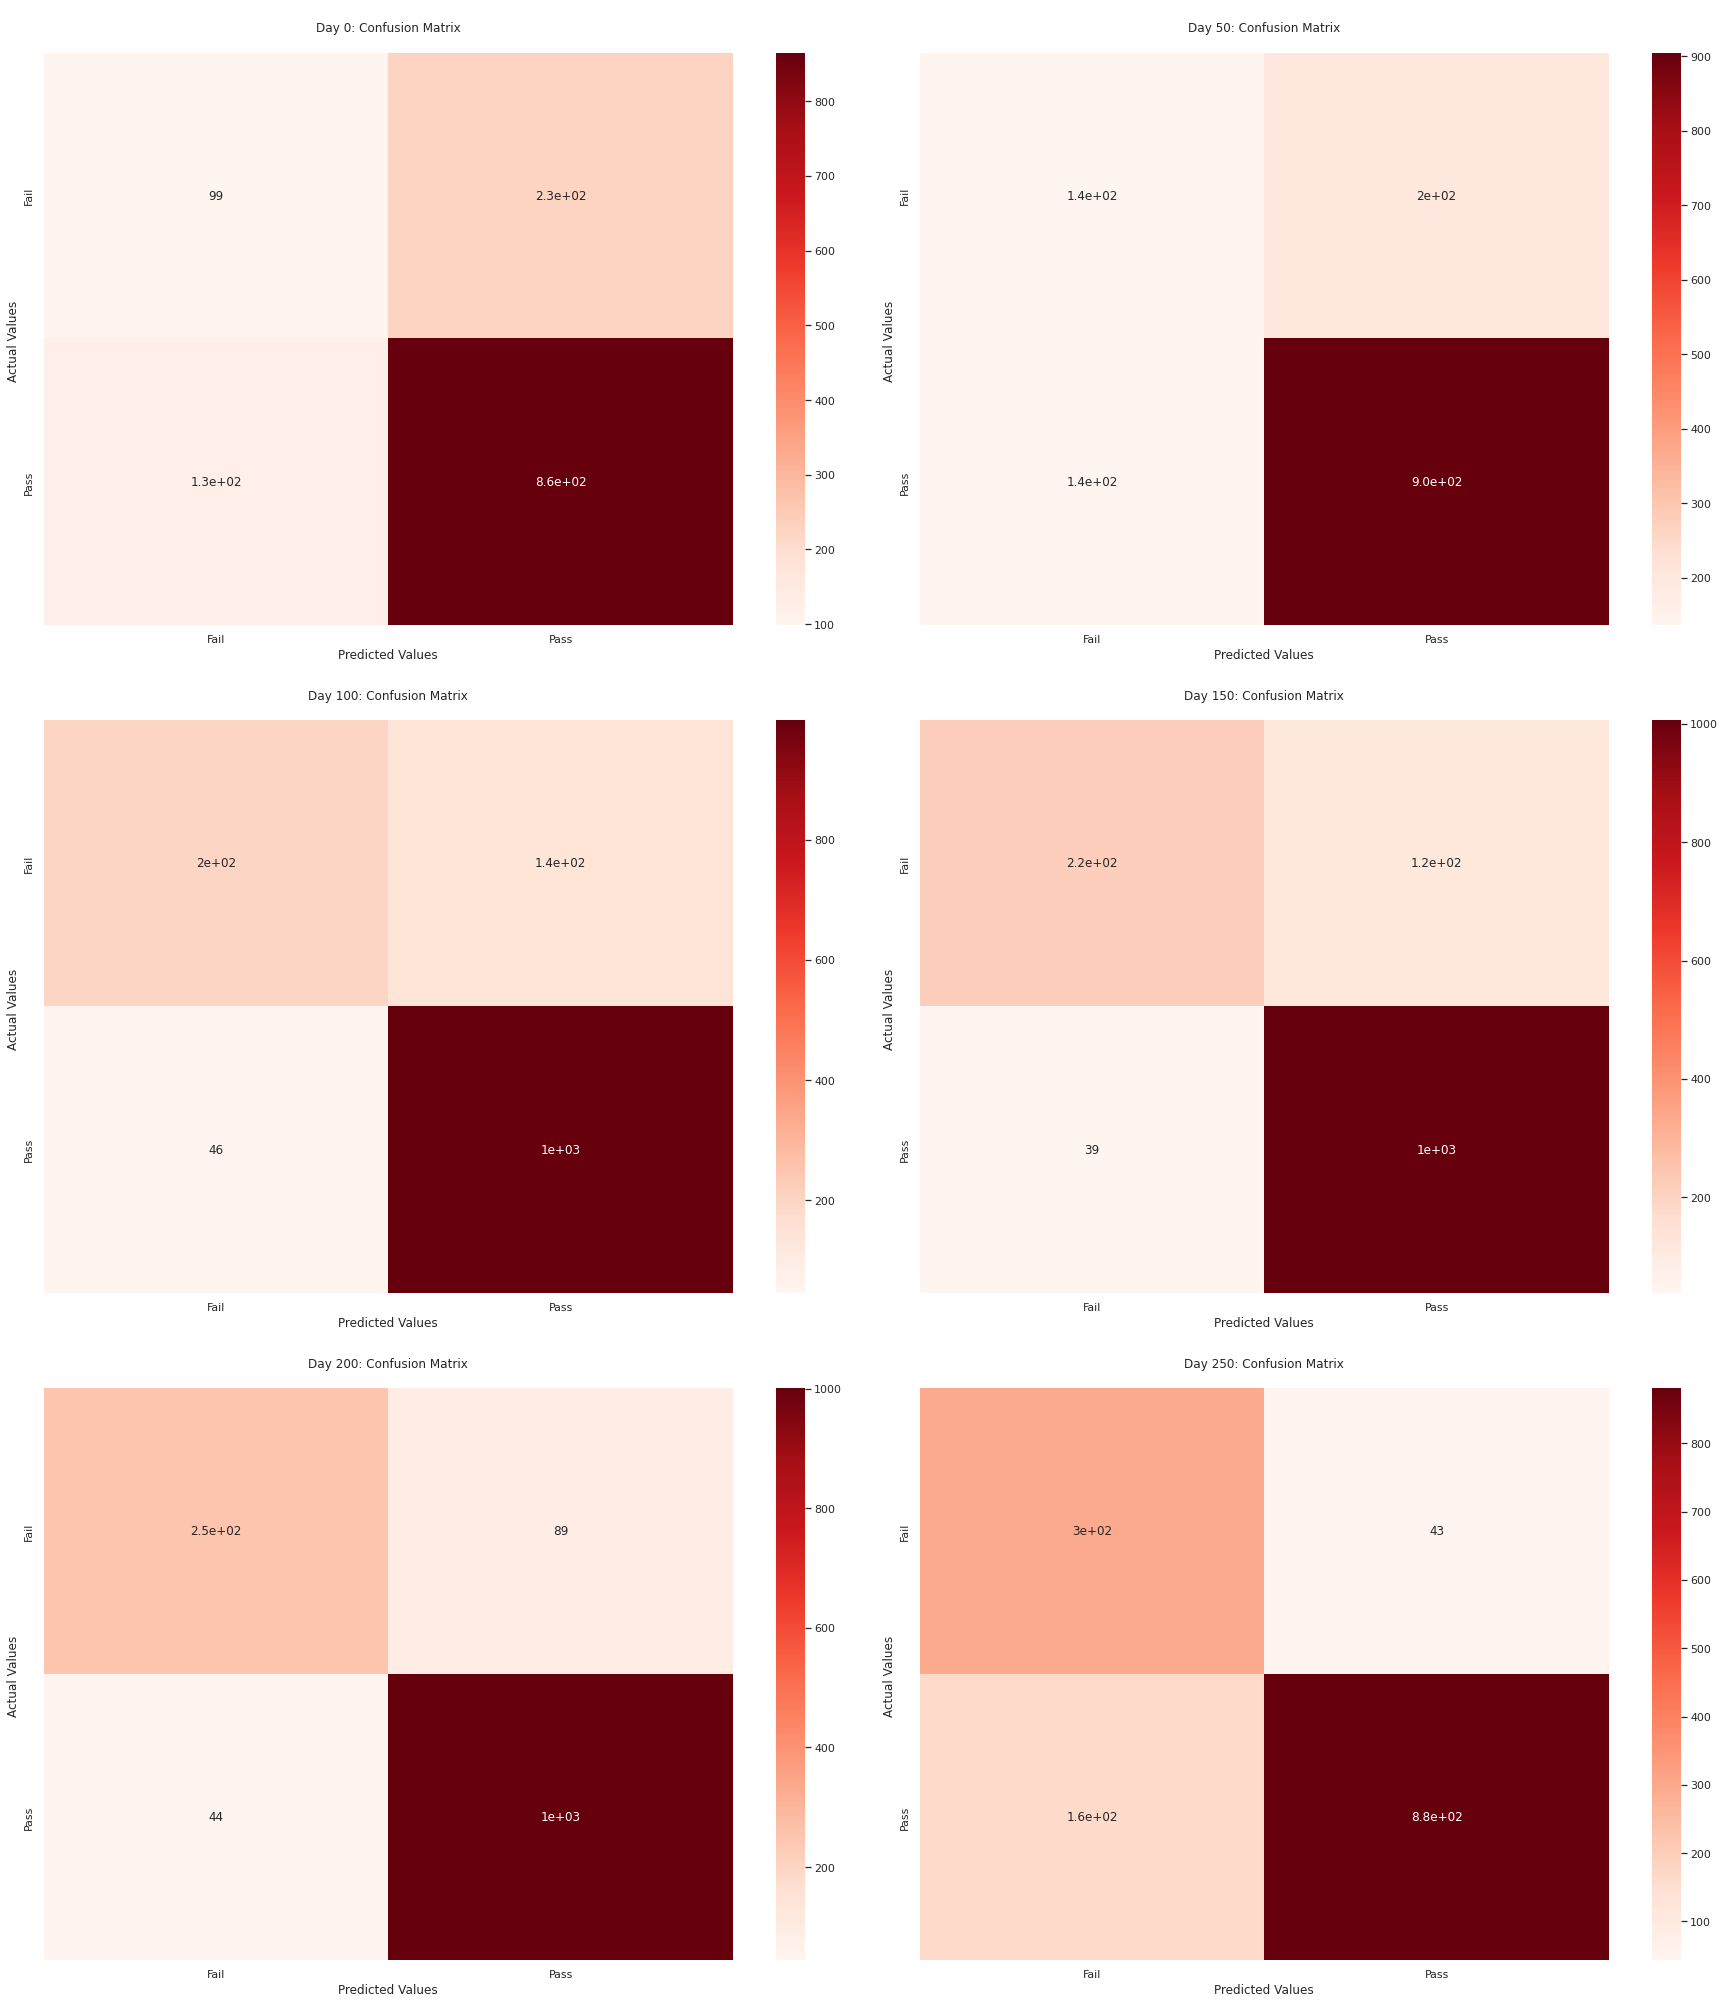

In [ ]:
plot_confusion_matrix(all_results_lr)

##### WeightedLogisticRegression

In [ ]:
all_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.623
Best parameters set:
Accuracy: 0.6145675265553869, F1 Score: 0.7018779342723005, Precision: 0.8398876404494382, Recall: 0.6028225806451613


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.673
Best parameters set:
Accuracy: 0.6439448875997099, F1 Score: 0.7279778393351801, Precision: 0.8633377135348226, Recall: 0.6293103448275862


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.819
Best parameters set:
Accuracy: 0.8497109826589595, F1 Score: 0.9, Precision: 0.9043478260869565, Recall: 0.8956937799043062


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.858
Best parameters set

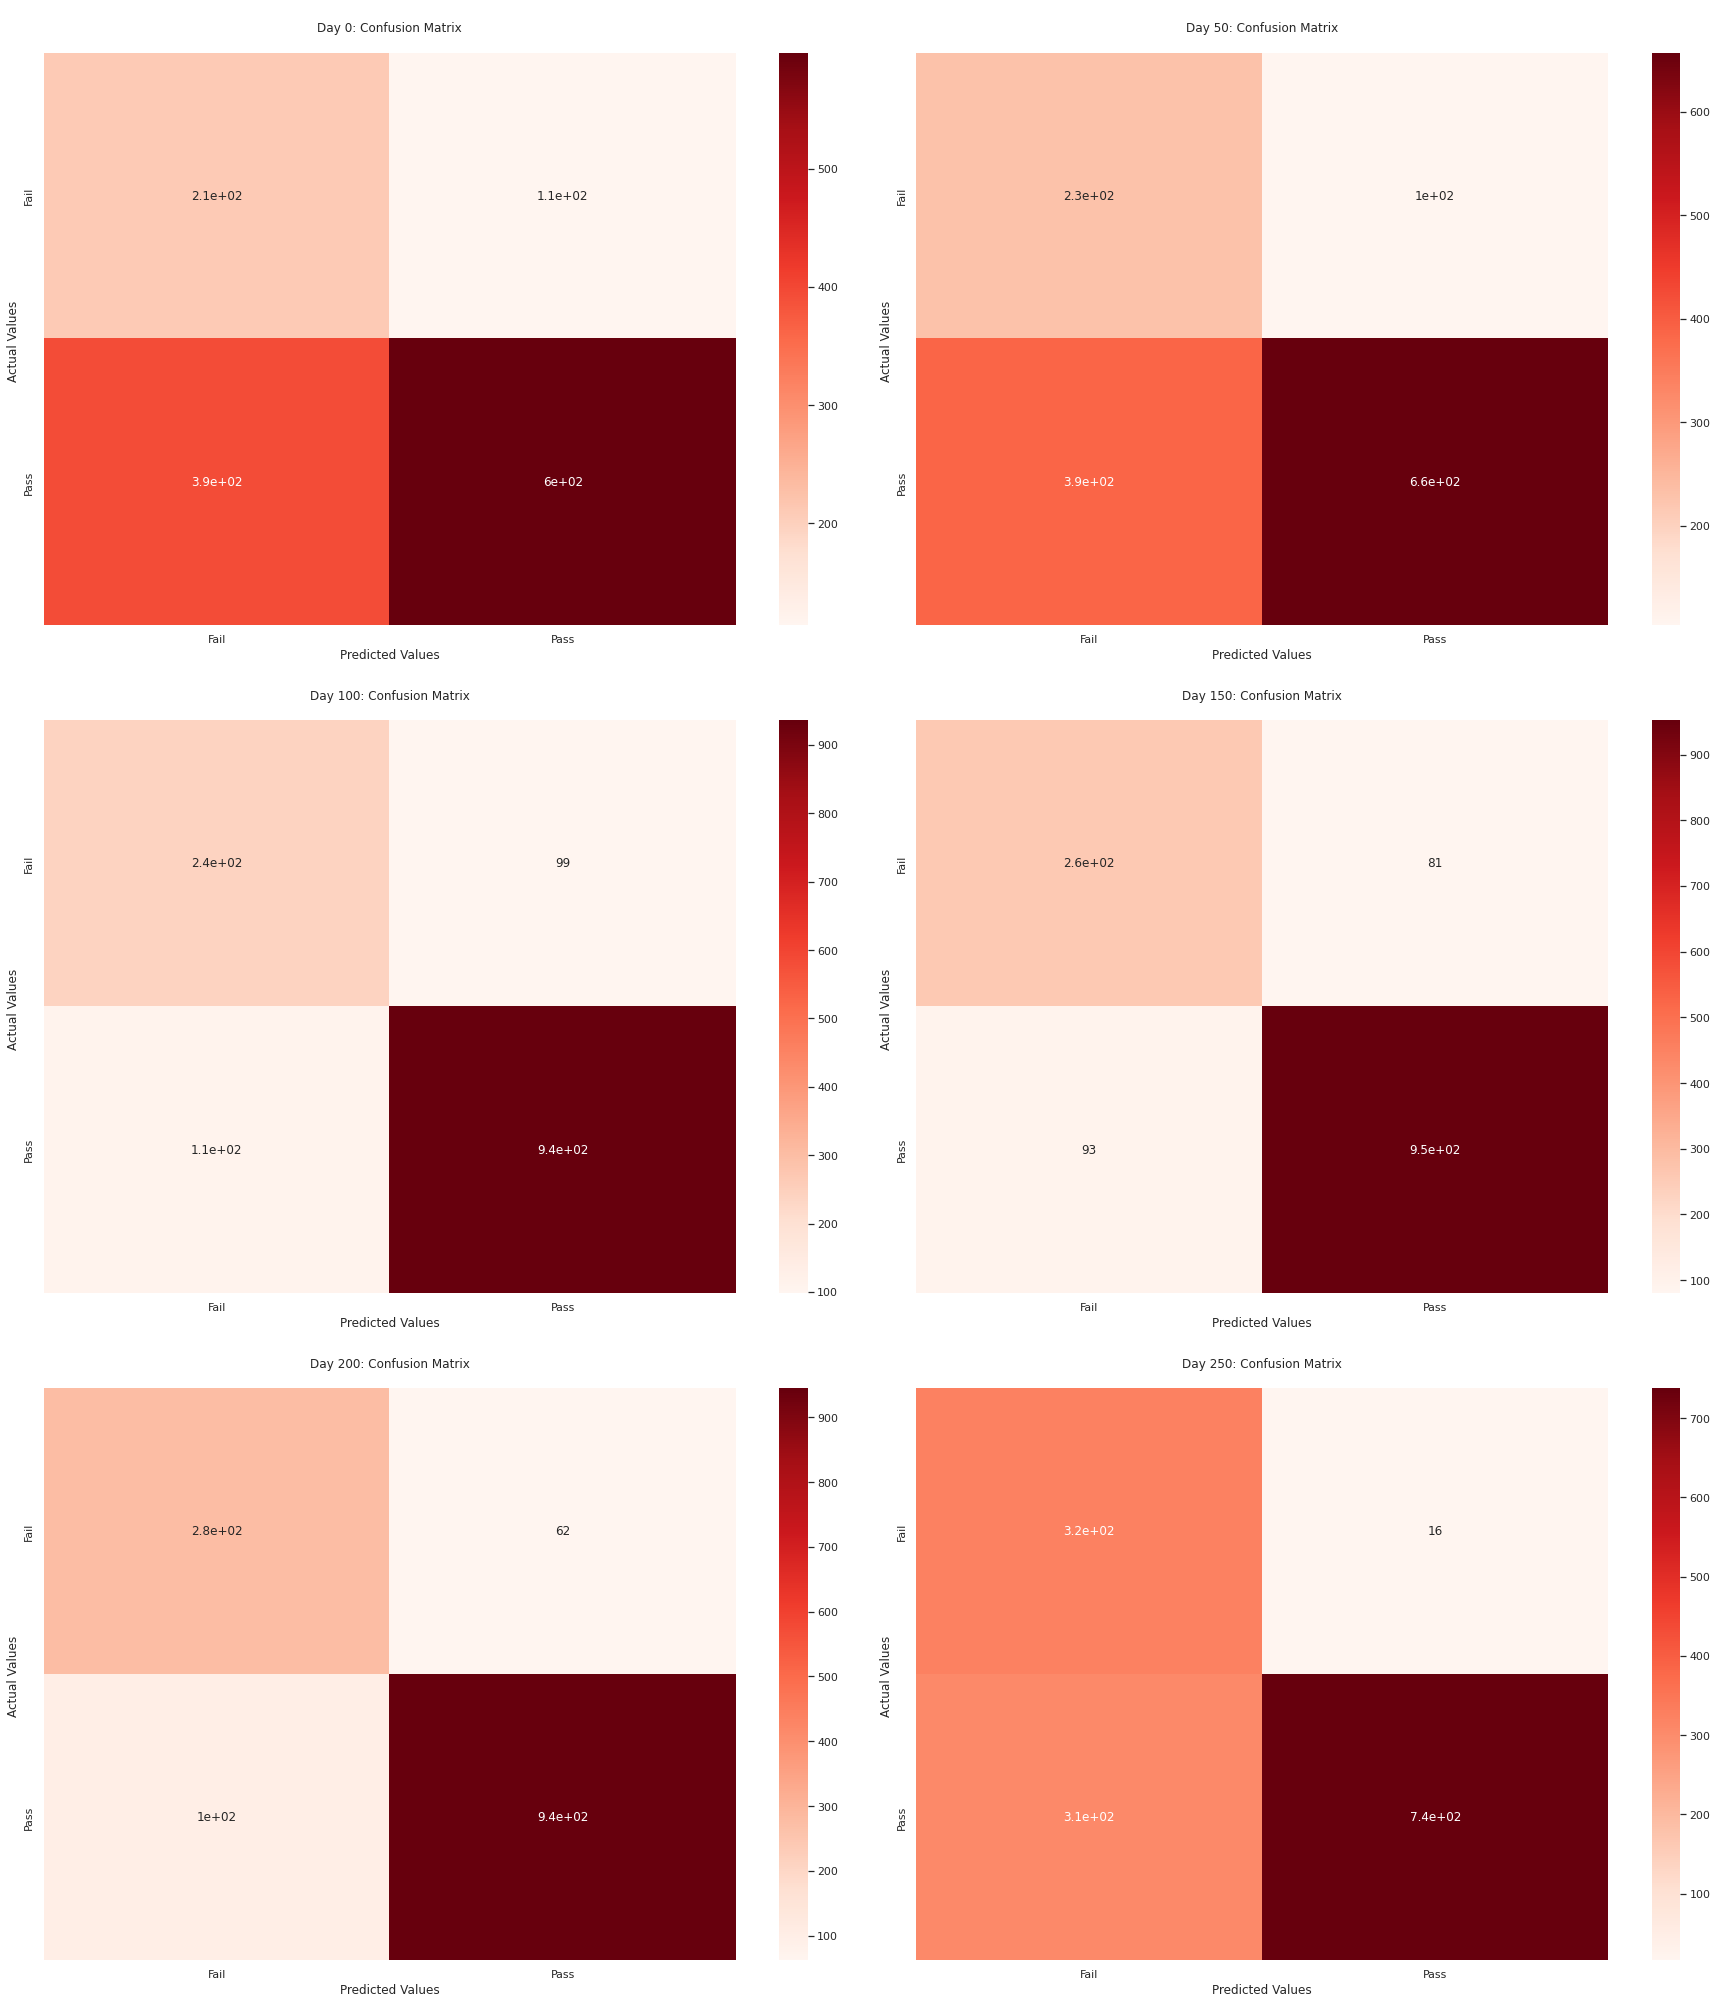

In [ ]:
plot_confusion_matrix(all_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

all_results_rf = []
all_results_predict_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_rf.append([acc, f1, prec, recall, conf])
  all_results_predict_rf.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.601
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.7314112291350531, F1 Score: 0.8317490494296577, Precision: 0.7868705035971223, Recall: 0.8820564516129032


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.613
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.7302393038433648, F1 Score: 0.8266542404473439, Precision: 0.8049001814882033, Recall: 0.8496168582375478


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.799
Best parameters set:
	clf__n_estimator

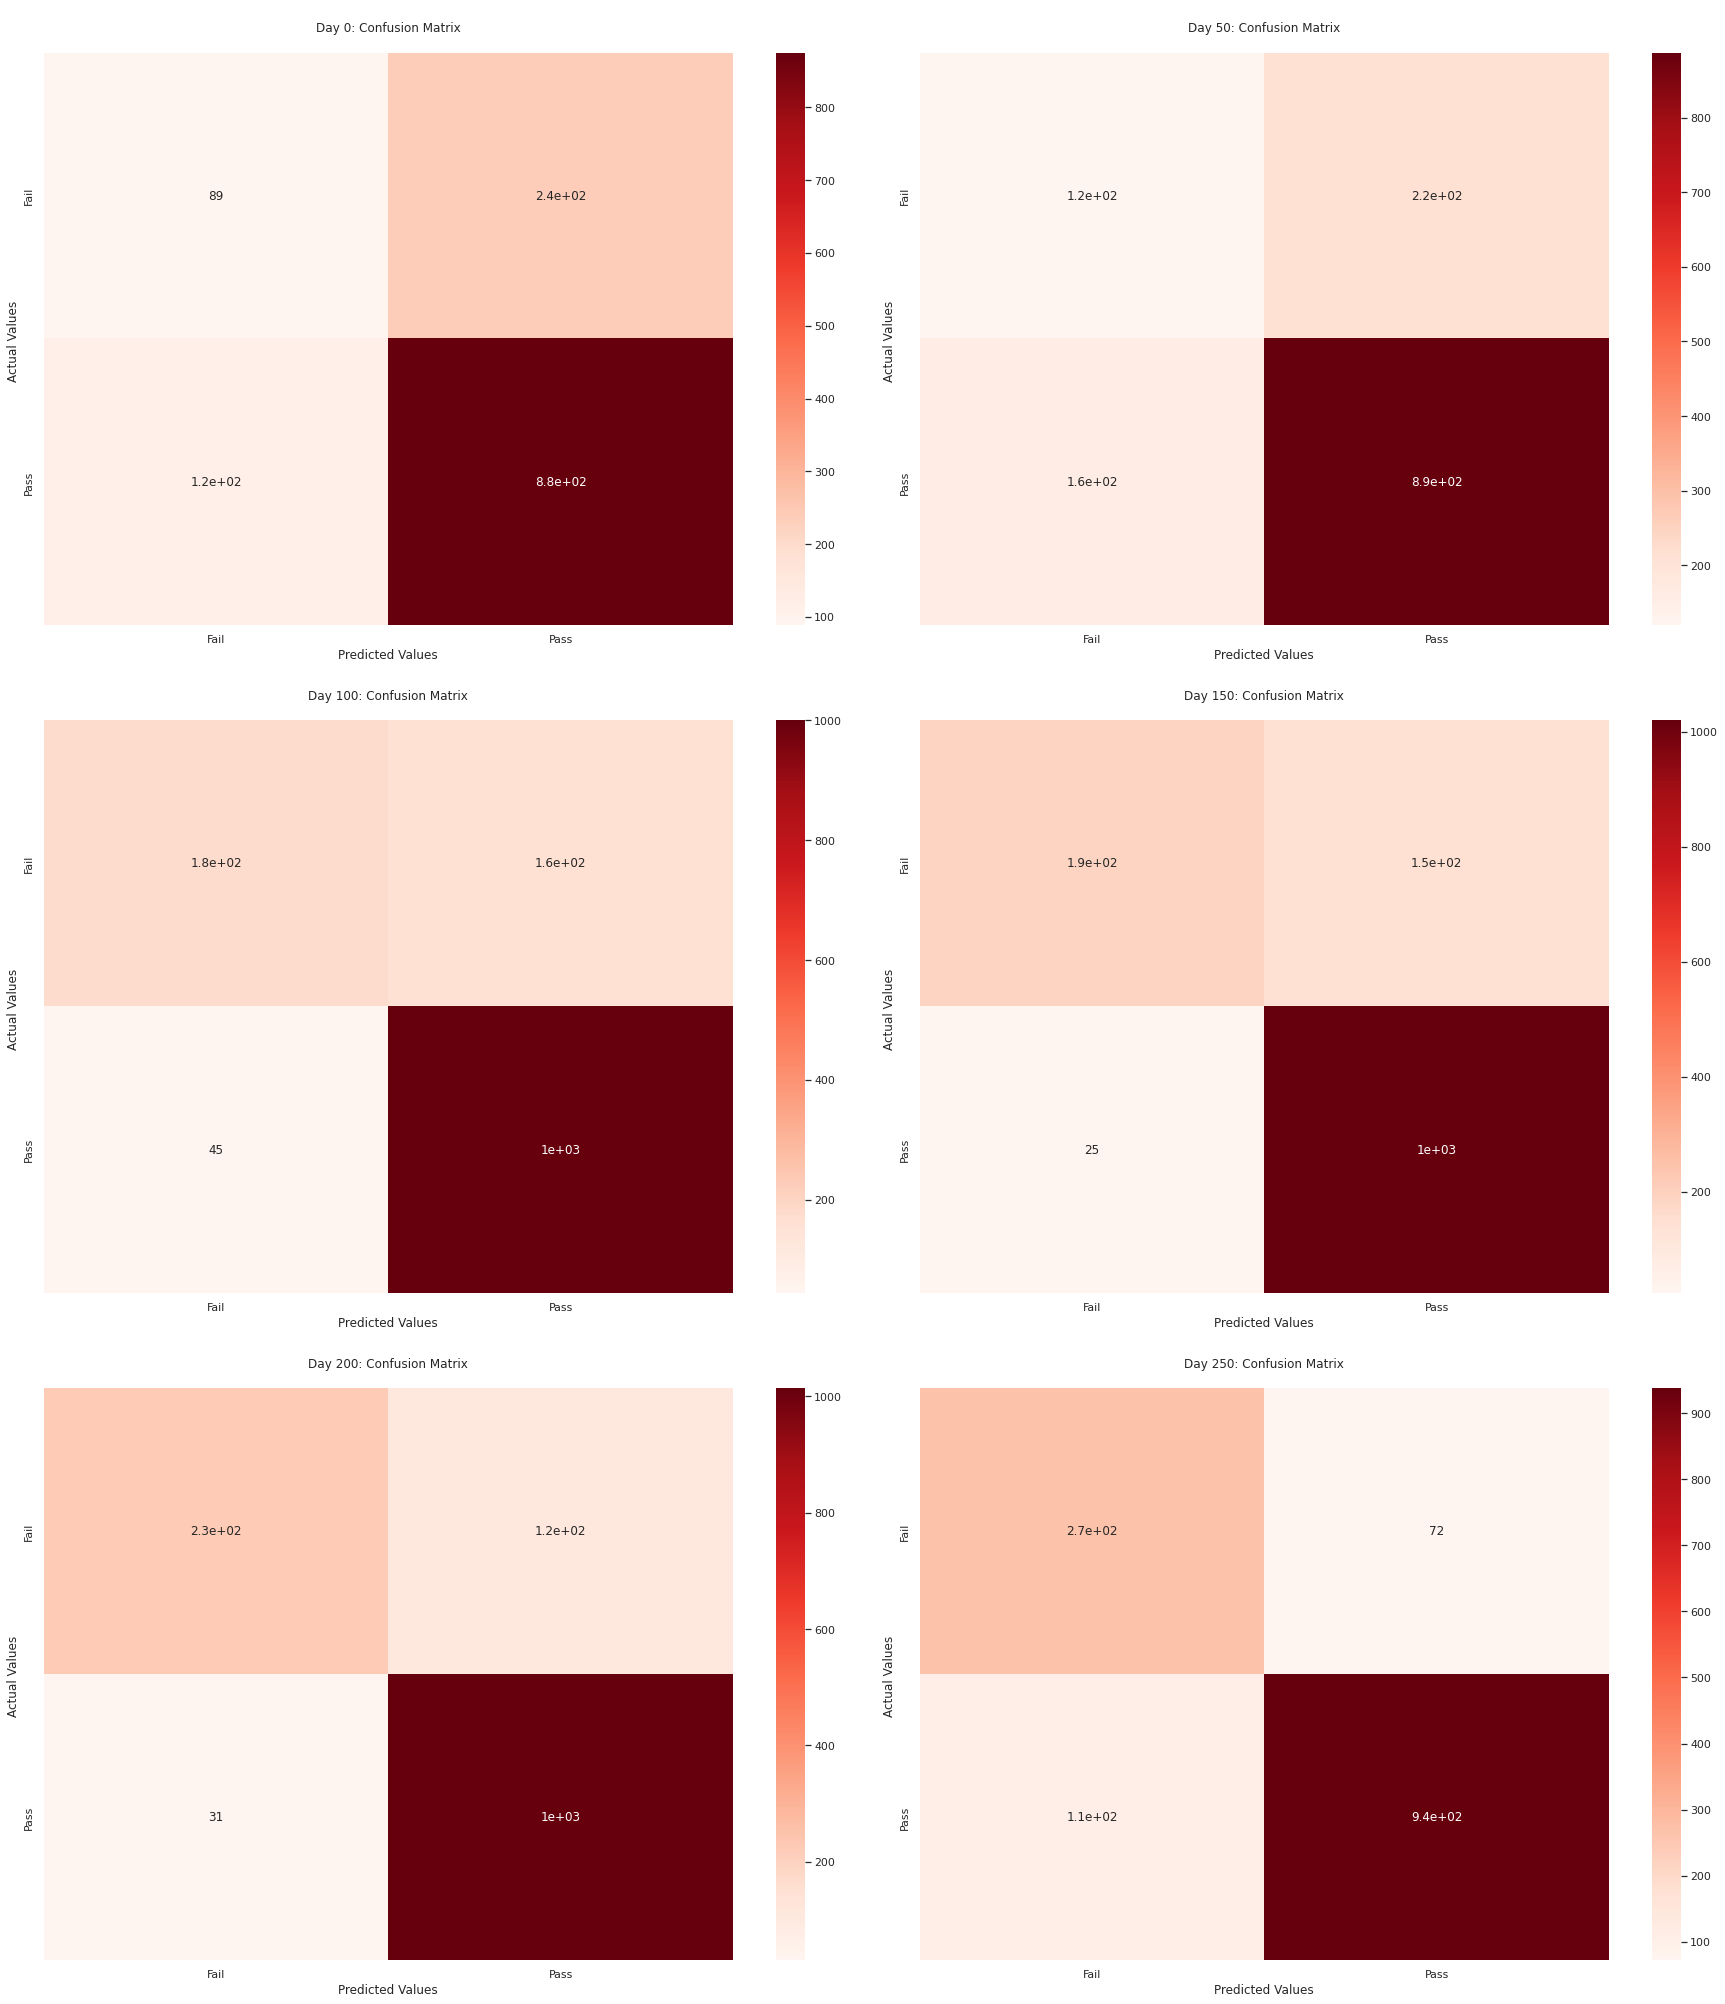

In [ ]:
plot_confusion_matrix(all_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

all_results_ab = []
all_results_predict_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_ab.append([acc, f1, prec, recall, conf])
  all_results_predict_ab.append(predictions)
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.613
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7071320182094082, F1 Score: 0.8081510934393639, Precision: 0.7970588235294118, Recall: 0.8195564516129032


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.637
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.7440174039158811, F1 Score: 0.8371019843101062, Precision: 0.8076580587711487, Recall: 0.8687739463601533


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.827
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8641618497109826, F1 Sc

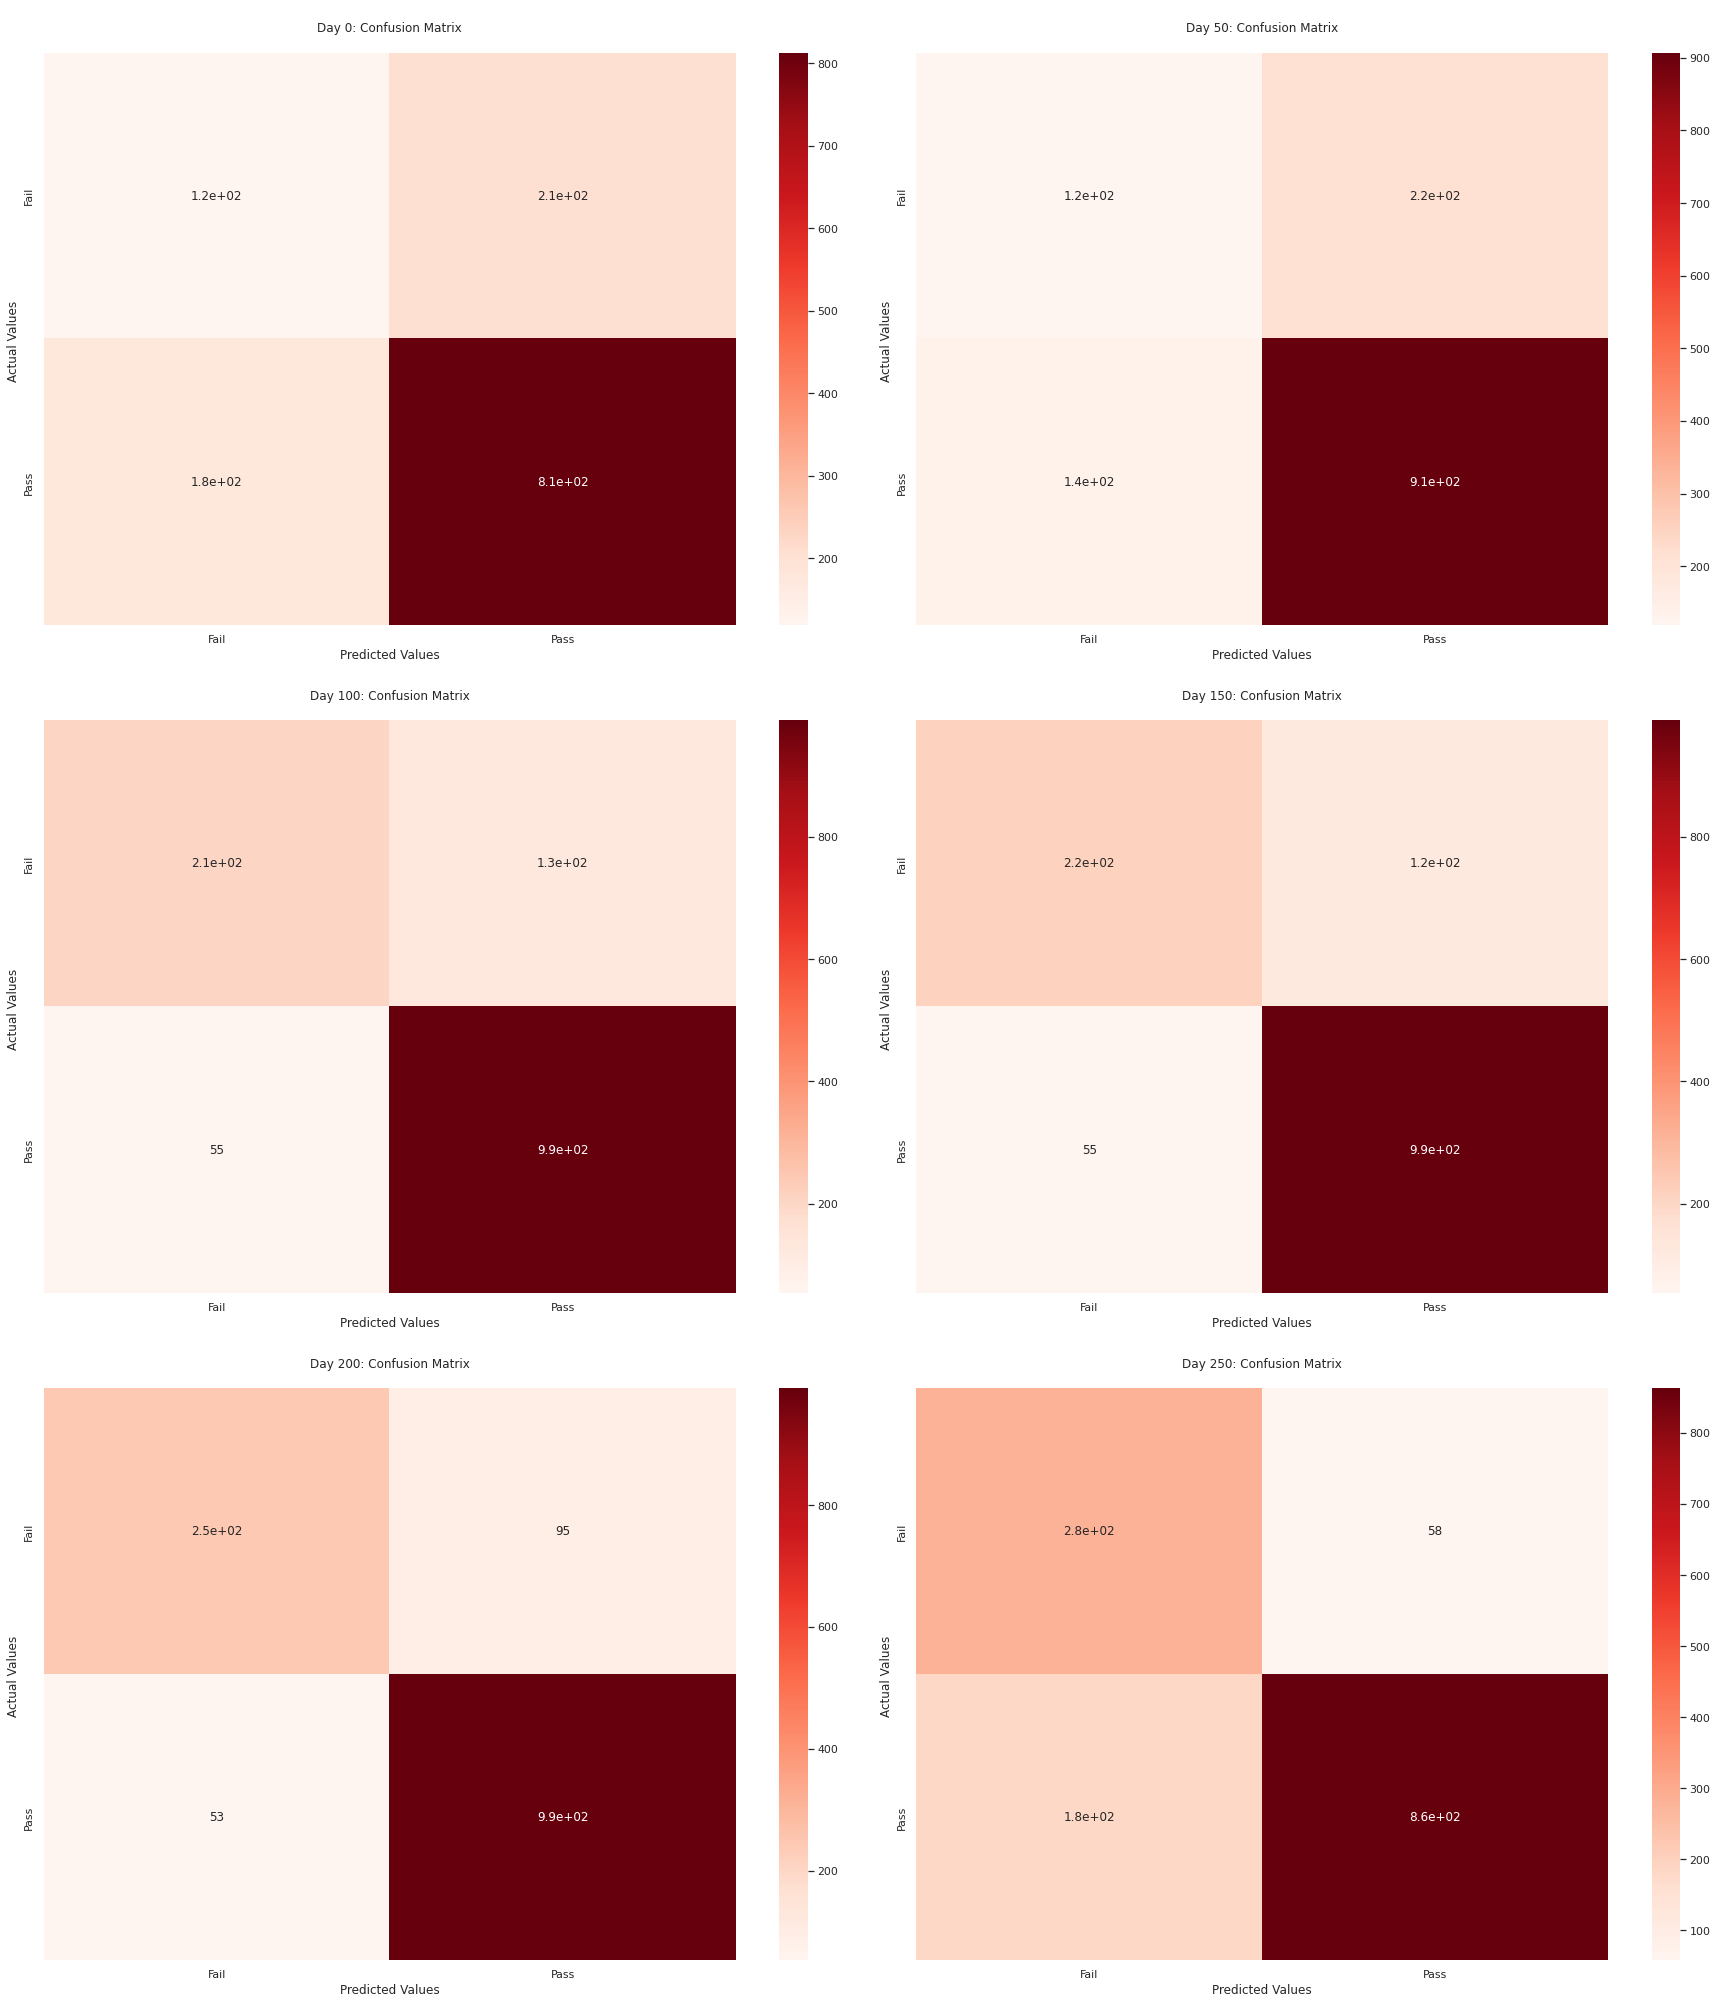

In [ ]:
plot_confusion_matrix(all_results_ab)

##### Plot results overview

In [ ]:
all_classifier_results = [all_results_du, all_results_nb, all_results_lr, all_results_lrw, all_results_rf, all_results_ab]
all_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

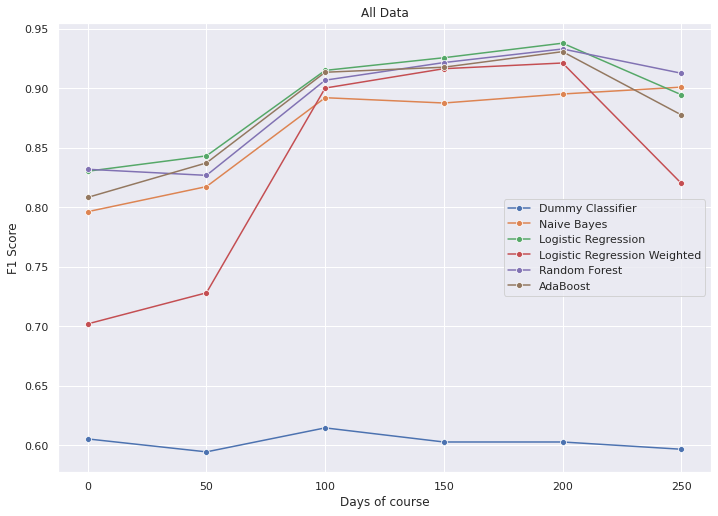

In [ ]:
plot_days_compare(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

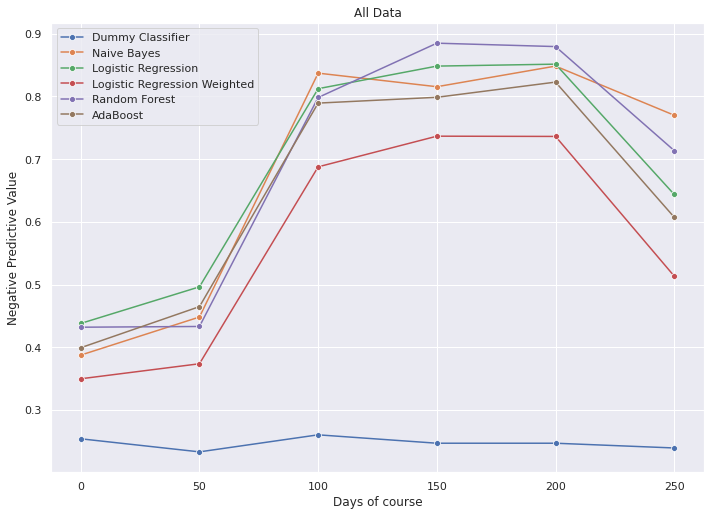

In [ ]:
plot_days_compare_npv(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

#### Three classifiers

In [ ]:
confusion_matrix_combine_three = []
keys= list(df)

for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine_three.append(np.zeros([2,2]))

  for j in range(len(all_results_predict_lr[i])):
    sum_predict = all_results_predict_lr[i][j] + all_results_predict_rf[i][j] + all_results_predict_ab[i][j]
    if sum_predict <= 1:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine_three[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,1] += 1
    else:
      confusion_matrix_combine_three[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine_three)):
  print(confusion_matrix_combine_three[i])

[[101. 225.]
 [128. 864.]]
[[126. 209.]
 [133. 911.]]
[[ 194.  145.]
 [  36. 1009.]]
[[ 204.  137.]
 [  30. 1015.]]
[[ 241.  100.]
 [  36. 1009.]]
[[286.  55.]
 [134. 912.]]


#### Combine Classifier Results

In [ ]:
confusion_matrix_combine = []
performance_weight = [0,0,0,0.0,0.5,0.5]
keys= list(df)


for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine.append(np.zeros([2,2]))
  for j in range(len(all_results_predict_proba_lr[i])):
    all_result = all_results_predict_proba_lr[i][j] * (1-performance_weight[i])

    if performance_weight[i] != 0:
      performance_result = performance_predict_proba_nb[i-1][j] * (performance_weight[i])
    else:
      performance_result = 0
    
    final_result = all_result + performance_result
    
    if final_result[0]>0.55:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine[i][0,1] += 1
    else:
      confusion_matrix_combine[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine)):
  print(confusion_matrix_combine[i])

[[ 76. 250.]
 [ 87. 905.]]
[[111. 224.]
 [ 97. 947.]]
[[ 192.  147.]
 [  36. 1009.]]
[[ 211.  130.]
 [  32. 1013.]]
[[ 237.  104.]
 [  24. 1021.]]
[[282.  59.]
 [103. 943.]]
